In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
np.random.seed(42)

In [2]:
charset = {
                'digit_0' : 0,
                'digit_1' : 1,
                'digit_2' : 2,
                'digit_3' : 3,
                'digit_4' : 4,
                'digit_5' : 5,
                'digit_6' : 6,
                'digit_7' : 7,
                'digit_8' : 8,
                'digit_9' : 9,
}
train_data = pd.read_csv('./dataset/digit_all_augmented.csv')
test_data  = pd.read_csv('./dataset/test_digits_data.csv')
X_train = train_data.iloc[:, 1:-1].values
y_train = train_data.iloc[:, -1]
y_train = y_train.replace(charset)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = .2)

In [3]:
from sklearn.preprocessing import MinMaxScaler
mm = MinMaxScaler()
X_train = mm.fit_transform(X_train)
# X_dev   = mm.fit_transform(X_dev)
X_test = mm.fit_transform(X_test)

In [10]:
print("Data\t\t\t","Before Processing\t","After Processing")
print("=================================================================")
print("Training Set Images:\t" + str(train_data.shape)+"\t\t"+ str(X_train.shape))
print("Training Set Labels:\t" + str(train_data.iloc[:, -1].shape)+"\t\t"+ str(y_train.shape))
# print("Dev Set Images:\t\t" + str(X_dev.shape)+"\t\t"+ str(X_dev.shape))
# print("Dev Set Labels:\t\t" + str(y_dev.shape)+"\t\t\t"+ str(y_dev.shape))
print("Test Set Images:\t" + str(test_data.shape)+"\t\t"+ str(X_test.shape))
print("Test Set Labels:\t" + str(test_data.iloc[:, -1].shape)+"\t\t\t"+ str(test_data.iloc[:, -1].shape))
print("=================================================================")

Data			 Before Processing	 After Processing
Training Set Images:	(85000, 1026)		(68000, 1024)
Training Set Labels:	(85000,)		(68000,)
Test Set Images:	(3000, 1025)		(17000, 1024)
Test Set Labels:	(3000,)			(3000,)


In [18]:

class Classifier:
    def __init__(self, n_inputs, n_neurons = [32,32,10]):
        np.random.seed(42)
    # We have done here n_inputs/n_neurons instead of n_neurons/n_inputs to prevent the Transpose everytime
        self.weights1 = 0.01 * np.random.randn(n_inputs, n_neurons[0]) # The input shape and no of neurons you want to have in the layer
        self.biases1 =  0.01 * np.random.randn(1, n_neurons[0])
        self.weights2 = 0.01 *np.random.randn(n_neurons[0], n_neurons[1]) # The input shape and no of neurons you want to have in the layer
        self.biases2 = 0.01 * np.random.randn(1, n_neurons[1])
        self.weights3 = 0.01 * np.random.randn(n_neurons[1], n_neurons[2])
        self.biases3 = 0.01 * np.random.randn(1, n_neurons[2])
        self.output1 = None
        self.output2 = None
        self.output3 = None
        self.X = None
        self.y = None
        # activatied outputs
        self.output1_act = None
        self.output2_act = None
        self.output3_act = None
    def forward(self, inputs, weights, biases):
        """ The dot product of the input - weights - Biases (y = Wx + b) """
        output = np.dot(inputs, weights) + biases
        if(np.isnan(np.sum(output))):
            raise Exception("NaN values present in FW pass")
        elif(np.isinf(np.sum(output))):
            raise Exception("INF values present in FW Pass")
        
        return output

    def ReLU(self, inputs):
        """ Rectified Linear Activation Function """
        output = np.maximum(0, inputs)
        return output
    
    def Softmax(self, inputs):
    # subtract largest value to prevent overflow
        self.inputs = inputs

        # Get unnormalized probabilities
        exp_values = np.exp(inputs - np.max(inputs, axis=1,
                                            keepdims=True))
        # Normalize them for each sample
        probabilities = exp_values / np.sum(exp_values, axis=1,
                                            keepdims=True)

        if(np.isnan(np.sum(probabilities))):
            raise Exception("NaN values present in Softmax For")
        elif(np.isinf(np.sum(probabilities))):
            raise Exception("INF values present in Softmax For")
        
        return probabilities
        
    def categorical_cross_entropy(self,y_pred, y_true):
        samples = len(y_pred)
        y_pred_clipped = np.clip(y_pred, 1e-6, 1-1e-6)
        # Handling if labels are 1D 
        correct_confidences = None
        if len(y_true.shape) == 1:
#             print(y_pred_clipped[range(samples), :].shape)
            correct_confidences = y_pred_clipped[range(samples), y_true]
        elif len(y_true.shape) ==2:
            correct_confidences = np.sum(y_pred_clipped * y_true, axis =1)
        else:
            raise Exception("Sorry, no numbers below zero")
        
        negative_log_likelihoods = -np.log(correct_confidences)
#         print(negative_log_likelihoods.shape)
        return negative_log_likelihoods 
    
    def linear_backward(self,inputs, weights, dvalues):
        self.dweights_linear = np.dot(inputs.T, dvalues)
        self.dbiases_linear = np.sum(dvalues, axis=0, keepdims=True)
        # Gradient on values
        self.dinput_linear = np.dot(dvalues, weights.T)
        
        if(np.isnan(np.sum(self.dweights_linear))):
            raise Exception("NaN values present in Linear Back")
        elif(np.isinf(np.sum(self.dweights_linear))):
            raise Exception("INF values present in Linear BAck")
        
        
        return self.dweights_linear, self.dinput_linear
    
    def linear_backward_with_l2(self,inputs, weights, dvalues, lambd = 0.5):
        """  """
        m = inputs.shape[1]
        self.dweights_linear = np.dot(inputs.T, dvalues) + (lambd*weights)/m
        self.dbiases_linear = np.sum(dvalues, axis=0, keepdims=True)
        # Gradient on values
        self.dinput_linear = np.dot(dvalues, weights.T) 
        
        if(np.isnan(np.sum(self.dweights_linear))):
            raise Exception("NaN values present in Linear Back")
        elif(np.isinf(np.sum(self.dweights_linear))):
            raise Exception("INF values present in Linear BAck")
        
        
        return self.dweights_linear, self.dinput_linear
    
    def softmax_backward(self,dA, Z):
        """Compute backward pass for softmax activation"""
        softmax_output = self.Softmax(Z) 
        return softmax_output * (1 - softmax_output) * dA

    def ReLU_backward(self,dA, Z):
        
        dZ = np.array(dA, copy=True)
        dZ[Z <= 0] = 0
        if(np.isnan(np.sum(dZ))):
            raise Exception("NaN values present in RELU Back")
        elif(np.isinf(np.sum(dZ))):
            raise Exception("INF values present in RELU BAck")
        return dZ
        
    def categorical_cross_entropy_backward(self, dvalues, y_true):
        # Number of samples
        samples = len(dvalues)
        labels = len(dvalues[0])
        # If labels are sparse, turn them into one-hot vector
        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]
        # Calculate gradient
        self.dinputs = -y_true / dvalues
        # Normalize gradient
        self.dinputs_loss = self.dinputs / samples
        if(np.isnan(np.sum(self.dinputs))):
            raise Exception("NaN values present in Softmax Back")
        elif(np.isinf(np.sum(self.dinputs))):
            raise Exception("INF values present in Softmax_back")
        return self.dinputs
    
    def softmax_categorical_cross_entropy_combined_backward(self, dvalues, y_true):
        samples = len(dvalues)
        #handling Ohe values
        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis=1)
        # Copy so we can safely modify
        self.dinputs_combined = dvalues.copy()
        # Calculate gradient
        self.dinputs_combined[range(samples), y_true] -= 1
        # Normalize gradient
        self.dinputs_combined = self.dinputs_combined / samples
        if(np.isnan(np.sum(self.dinputs_combined))):
            raise Exception("NaN values present in Softmax Back")
        elif(np.isinf(np.sum(self.dinputs_combined))):
            raise Exception("INF values present in Softmax_back")
       
        return self.dinputs_combined
        
    
    def compute_loss(self,y_pred, y_true):
        sample_losses = self.categorical_cross_entropy(y_pred, y_true)
        loss = np.mean(sample_losses)
        return loss
    
    def compute_loss_with_l2(self,y_pred, y_true, lambd = 0.5):
        m = 10
        sample_losses = self.categorical_cross_entropy(y_pred, y_true)
        L2_regularization_cost = (lambd/(2*m))*(np.sum(np.square(self.weights1) + np.sum(np.square(self.weights2) + np.sum(np.square(self.weights3)))))
        loss = np.mean(sample_losses) 
        return loss
    
    
    def forward_pass(self, X):
        self.X = X
        self.output1     = self.forward(self.X, self.weights1, self.biases1)
        self.output1_act = self.ReLU(self.output1)
        self.output2     = self.forward(self.output1_act, self.weights2, self.biases2)
        self.output2_act = self.ReLU(self.output2)
        self.output3     = self.forward(self.output2_act, self.weights3, self.biases3)
        self.output3_act = self.Softmax(self.output3)
#         print("Softmax SUM", np.sum(self.output3_act, axis = 1))
        if(np.isnan(np.sum(self.output3_act))):
            raise Exception("NaN values present in data")
        elif(np.isinf(np.sum(self.output3_act))):
            raise Exception("INF values present in data")
        
        
    def check_inf(self):
        check_weights = np.any(np.isinf(self.weights1)) or np.any(np.isinf(self.weights2)) or np.any(np.isinf(self.weights3))
        check_bias    = np.any(np.isinf(self.biases1)) or np.any(np.isinf(self.biases2)) or np.any(np.isinf(self.biases3))
        return (check_weights or check_bias)
    
    def backward_pass(self, y, learning_rate= 0.1, iteration = 10000):
        self.y = y
        for i in range(iteration):
            self.forward_pass(self.X)
            predictions = np.argmax(self.output3_act, axis=1)
            
            
            gradient_output3_act                  = self.softmax_categorical_cross_entropy_combined_backward(self.output3_act, self.y)
            gradient_output3, gradient_input3     = self.linear_backward(self.output2,self.weights3,gradient_output3_act)
            gradient_output2_act                  = self.ReLU_backward(gradient_input3, self.output2)
            gradient_output2, gradient_input2     = self.linear_backward(self.output1, self.weights2, gradient_output2_act)
            gradient_output1_act                  = self.ReLU_backward(gradient_input2, self.output1)
            gradient_output1, gradient_input1     = self.linear_backward(self.X, self.weights1, gradient_output1_act)
            
            self.weights3  = self.weights3 - learning_rate * gradient_output3
            self.weights2  = self.weights2 - learning_rate * gradient_output2
            self.weights1  = self.weights1 - learning_rate * gradient_output1
            assert np.sum(gradient_output1) != np.nan, "The gradient has nan"
            assert np.sum(gradient_output1) != np.inf, "The gradient has inf"
            if i%100 == 0:

                loss = self.compute_loss(self.output3_act, y)
                self.accuracy = np.mean(predictions==self.y)
                if(self.accuracy > 99.0):
                    break
                print(f'Loss after a iteration {i}:{loss} || Accuracy: {self.accuracy * 100}')
                
    def backward_pass_with_l2(self, y, learning_rate= 0.1, iteration = 10000):
        self.y = y
        self.loss_list = []
        self.acc_list = []
        for i in range(iteration):
            self.forward_pass(self.X)
            predictions = np.argmax(self.output3_act, axis=1)
            
            
            gradient_output3_act                  = self.softmax_categorical_cross_entropy_combined_backward(self.output3_act, self.y)
#             print(gradient_output3_act)
            gradient_output3, gradient_input3     = self.linear_backward_with_l2(self.output2,self.weights3,gradient_output3_act)
            gradient_output2_act                  = self.ReLU_backward(gradient_input3, self.output2)
            gradient_output2, gradient_input2     = self.linear_backward_with_l2(self.output1, self.weights2, gradient_output2_act)
            gradient_output1_act                  = self.ReLU_backward(gradient_input2, self.output1)
            gradient_output1, gradient_input1     = self.linear_backward_with_l2(self.X, self.weights1, gradient_output1_act)
            
            self.weights3  = self.weights3 - learning_rate * gradient_output3
            self.weights2  = self.weights2 - learning_rate * gradient_output2
            self.weights1  = self.weights1 - learning_rate * gradient_output1
            assert np.sum(gradient_output1) != np.nan, "The gradient has nan"
            assert np.sum(gradient_output1) != np.inf, "The gradient has inf"
            loss = self.compute_loss_with_l2(self.output3_act, y)
            self.accuracy = np.mean(predictions==self.y)
            if i%100 == 0:
                self.loss_list.append(loss)
                self.acc_list.append(self.accuracy)
                if(self.accuracy > .99):
                    break
                print(f'Loss after a iteration {i}:{loss} || Accuracy: {self.accuracy * 100}')
        plt.plot(self.loss_list)
        plt.title("Training loss of the model")
    def load_model(self, weights, biases = None):
        self.weights1 = weights['1']
        self.weights2 = weights['2']
        self.weights3 = weights['3']
        
        self.biases1 = weights['b1']
        self.biases2 = weights['b2']
        self.biases3 = weights['b3']
    
    def save_model(self, filename = f'model.pkl'):
        from datetime import date

        today = date.today()

        filename = f'model_{self.accuracy}-{today}.pkl'
        weights = {
                    '1': self.weights1, '2': self.weights2, '3': self.weights3, 
                    'b1':self.biases1,'b2':self.biases2,'b3':self.biases3
        }
        pickle.dump(weights, open(filename, 'wb'))
        

    def predict(self, X_test):
        output1     = self.forward(X_test, self.weights1, self.biases1)
        output1_act = self.ReLU(output1)
        output2     = self.forward(output1_act, self.weights2, self.biases2)
        output2_act = self.ReLU(output2)
        output3     = self.forward(output2_act, self.weights3, self.biases3)
        output3_act = self.Softmax(output3)
        prediction, prediction_prob = np.argmax(output3_act, axis=1), np.max(output3_act, axis=1)
        return prediction, output3_act


In [ ]:
model  = Classifier(1024, [32,32, 10])
model.forward_pass(X_test)
loss = model.compute_loss_with_l2(model.output3_act, y_test)
model.backward_pass_with_l2(y_test, iteration = 3000)


Gradient is [[ 5.91249597e-06  5.80438584e-06  5.84234585e-06 ...  5.91361944e-06
   5.90474990e-06  5.97603879e-06]
 [ 5.91188503e-06  5.80547977e-06 -5.29802432e-05 ...  5.91239388e-06
   5.90542764e-06  5.97682058e-06]
 [ 5.91209432e-06  5.80344592e-06  5.84189199e-06 ...  5.91290966e-06
   5.90491763e-06  5.97638499e-06]
 ...
 [-5.29113514e-05  5.80563702e-06  5.84317125e-06 ...  5.91397154e-06
   5.90487955e-06  5.97596035e-06]
 [ 5.91150445e-06  5.80605229e-06  5.84204335e-06 ...  5.91396049e-06
   5.90574329e-06 -5.28476986e-05]
 [ 5.91207029e-06  5.80544671e-06  5.84270286e-06 ...  5.91307850e-06
  -5.29180615e-05  5.97637282e-06]]
Loss after a iteration 0:2.3026424524216496 || Accuracy: 10.023529411764706
Gradient is [[ 5.91247821e-06  5.80439924e-06  5.84234782e-06 ...  5.91363029e-06
   5.90473713e-06  5.97604053e-06]
 [ 5.91188543e-06  5.80550290e-06 -5.29802413e-05 ...  5.91240802e-06
   5.90541640e-06  5.97682136e-06]
 [ 5.91207764e-06  5.80345966e-06  5.84189284e-06 ... 

Gradient is [[ 5.91225904e-06  5.80456377e-06  5.84237213e-06 ...  5.91377029e-06
   5.90457740e-06  5.97605749e-06]
 [ 5.91189242e-06  5.80578967e-06 -5.29802188e-05 ...  5.91258763e-06
   5.90527862e-06  5.97682974e-06]
 [ 5.91187685e-06  5.80363063e-06  5.84190394e-06 ...  5.91309708e-06
   5.90480075e-06  5.97639289e-06]
 ...
 [-5.29113333e-05  5.80587613e-06  5.84313557e-06 ...  5.91405605e-06
   5.90481418e-06  5.97601844e-06]
 [ 5.91153728e-06  5.80623506e-06  5.84206781e-06 ...  5.91403745e-06
   5.90561746e-06 -5.28476610e-05]
 [ 5.91208992e-06  5.80566092e-06  5.84263546e-06 ...  5.91318896e-06
  -5.29181113e-05  5.97642505e-06]]
Gradient is [[ 5.91224301e-06  5.80457570e-06  5.84237392e-06 ...  5.91378098e-06
   5.90456558e-06  5.97605833e-06]
 [ 5.91189306e-06  5.80581071e-06 -5.29802173e-05 ...  5.91260115e-06
   5.90526863e-06  5.97683025e-06]
 [ 5.91186573e-06  5.80364461e-06  5.84190450e-06 ...  5.91310811e-06
   5.90479614e-06  5.97639058e-06]
 ...
 [-5.29113319e-05  5

Gradient is [[ 5.91204374e-06  5.80472113e-06  5.84239634e-06 ...  5.91391858e-06
   5.90441691e-06  5.97606384e-06]
 [ 5.91190228e-06  5.80607231e-06 -5.29801992e-05 ...  5.91277287e-06
   5.90514533e-06  5.97683518e-06]
 [ 5.91172754e-06  5.80381594e-06  5.84191155e-06 ...  5.91324729e-06
   5.90473689e-06  5.97635964e-06]
 ...
 [-5.29113124e-05  5.80610044e-06  5.84310331e-06 ...  5.91413772e-06
   5.90475331e-06  5.97607216e-06]
 [ 5.91157121e-06  5.80640172e-06  5.84208930e-06 ...  5.91411351e-06
   5.90549804e-06 -5.28476293e-05]
 [ 5.91210867e-06  5.80586060e-06  5.84257339e-06 ...  5.91329377e-06
  -5.29181590e-05  5.97647238e-06]]
Gradient is [[ 5.91202901e-06  5.80473157e-06  5.84239801e-06 ...  5.91392908e-06
   5.90440580e-06  5.97606386e-06]
 [ 5.91190303e-06  5.80609156e-06 -5.29801980e-05 ...  5.91278577e-06
   5.90513633e-06  5.97683544e-06]
 [ 5.91171733e-06  5.80382834e-06  5.84191210e-06 ...  5.91325769e-06
   5.90473237e-06  5.97635717e-06]
 ...
 [-5.29113108e-05  5

Gradient is [[ 5.91184401e-06  5.80485834e-06  5.84241941e-06 ...  5.91406430e-06
   5.90426509e-06  5.97605903e-06]
 [ 5.91191299e-06  5.80633190e-06 -5.29801836e-05 ...  5.91295000e-06
   5.90502459e-06  5.97683740e-06]
 [ 5.91158870e-06  5.80398019e-06  5.84191950e-06 ...  5.91338933e-06
   5.90467357e-06  5.97632395e-06]
 ...
 [-5.29112893e-05  5.80631200e-06  5.84307397e-06 ...  5.91421647e-06
   5.90469632e-06  5.97612200e-06]
 [ 5.91160454e-06  5.80655380e-06  5.84210816e-06 ...  5.91418855e-06
   5.90538395e-06 -5.28476028e-05]
 [ 5.91212622e-06  5.80604720e-06  5.84251605e-06 ...  5.91339307e-06
  -5.29182047e-05  5.97651547e-06]]
Gradient is [[ 5.91183021e-06  5.80486741e-06  5.84242104e-06 ...  5.91407460e-06
   5.90425452e-06  5.97605827e-06]
 [ 5.91191375e-06  5.80634966e-06 -5.29801825e-05 ...  5.91296235e-06
   5.90501636e-06  5.97683743e-06]
 [ 5.91157908e-06  5.80399116e-06  5.84192011e-06 ...  5.91339917e-06
   5.90466906e-06  5.97632130e-06]
 ...
 [-5.29112876e-05  5

Gradient is [[ 5.91165479e-06  5.80497681e-06  5.84244250e-06 ...  5.91420699e-06
   5.90411971e-06  5.97604343e-06]
 [ 5.91192276e-06  5.80657257e-06 -5.29801704e-05 ...  5.91311912e-06
   5.90491371e-06  5.97683662e-06]
 [ 5.91145632e-06  5.80412521e-06  5.84192842e-06 ...  5.91352353e-06
   5.90460969e-06  5.97628586e-06]
 ...
 [-5.29112644e-05  5.80651408e-06  5.84304905e-06 ...  5.91429145e-06
   5.90464264e-06  5.97616552e-06]
 [ 5.91163577e-06  5.80669294e-06  5.84212519e-06 ...  5.91426239e-06
   5.90527420e-06 -5.28475809e-05]
 [ 5.91214236e-06  5.80622223e-06  5.84246294e-06 ...  5.91348697e-06
  -5.29182484e-05  5.97655491e-06]]
Gradient is [[ 5.91164155e-06  5.80498457e-06  5.84244417e-06 ...  5.91421705e-06
   5.90410952e-06  5.97604192e-06]
 [ 5.91192336e-06  5.80658914e-06 -5.29801696e-05 ...  5.91313088e-06
   5.90490612e-06  5.97683648e-06]
 [ 5.91144700e-06  5.80413491e-06  5.84192909e-06 ...  5.91353278e-06
   5.90460511e-06  5.97628307e-06]
 ...
 [-5.29112625e-05  5

Gradient is [[ 5.91147189e-06  5.80507663e-06  5.84246620e-06 ...  5.91434635e-06
   5.90397879e-06  5.97601752e-06]
 [ 5.91193021e-06  5.80679760e-06 -5.29801588e-05 ...  5.91328039e-06
   5.90481101e-06  5.97683328e-06]
 [ 5.91132704e-06  5.80425244e-06  5.84193833e-06 ...  5.91364986e-06
   5.90454474e-06  5.97624553e-06]
 ...
 [-5.29112362e-05  5.80670768e-06  5.84302922e-06 ...  5.91436259e-06
   5.90459069e-06  5.97620394e-06]
 [ 5.91166409e-06  5.80681854e-06  5.84214000e-06 ...  5.91433439e-06
   5.90516926e-06 -5.28475633e-05]
 [ 5.91215690e-06  5.80638667e-06  5.84241357e-06 ...  5.91357561e-06
  -5.29182901e-05  5.97659118e-06]]
Gradient is [[ 5.91145897e-06  5.80508300e-06  5.84246796e-06 ...  5.91435621e-06
   5.90396883e-06  5.97601522e-06]
 [ 5.91193065e-06  5.80681310e-06 -5.29801580e-05 ...  5.91329167e-06
   5.90480390e-06  5.97683290e-06]
 [ 5.91131785e-06  5.80426079e-06  5.84193909e-06 ...  5.91365866e-06
   5.90454001e-06  5.97624250e-06]
 ...
 [-5.29112341e-05  5

Gradient is [[ 5.91129141e-06  5.80515665e-06  5.84249173e-06 ...  5.91448355e-06
   5.90383990e-06  5.97598033e-06]
 [ 5.91193480e-06  5.80700875e-06 -5.29801473e-05 ...  5.91343558e-06
   5.90471377e-06  5.97682636e-06]
 [ 5.91119788e-06  5.80436114e-06  5.84195010e-06 ...  5.91377069e-06
   5.90447728e-06  5.97620111e-06]
 ...
 [-5.29112069e-05  5.80689382e-06  5.84301229e-06 ...  5.91443115e-06
   5.90454109e-06  5.97623920e-06]
 [ 5.91168856e-06  5.80693086e-06  5.84215299e-06 ...  5.91440479e-06
   5.90506831e-06 -5.28475501e-05]
 [ 5.91216968e-06  5.80654119e-06  5.84236767e-06 ...  5.91365937e-06
  -5.29183302e-05  5.97662447e-06]]
Gradient is [[ 5.91127849e-06  5.80516159e-06  5.84249362e-06 ...  5.91449328e-06
   5.90383000e-06  5.97597729e-06]
 [ 5.91193498e-06  5.80702335e-06 -5.29801465e-05 ...  5.91344644e-06
   5.90470700e-06  5.97682574e-06]
 [ 5.91118858e-06  5.80436820e-06  5.84195099e-06 ...  5.91377912e-06
   5.90447237e-06  5.97619778e-06]
 ...
 [-5.29112049e-05  5

Gradient is [[ 5.91112231e-06  5.80521266e-06  5.84251726e-06 ...  5.91460920e-06
   5.90371099e-06  5.97593637e-06]
 [ 5.91193536e-06  5.80719429e-06 -5.29801367e-05 ...  5.91357462e-06
   5.90462726e-06  5.97681700e-06]
 [ 5.91107533e-06  5.80444573e-06  5.84196256e-06 ...  5.91387836e-06
   5.90441188e-06  5.97615574e-06]
 ...
 [-5.29111803e-05  5.80706701e-06  5.84300129e-06 ...  5.91449388e-06
   5.90449824e-06  5.97627108e-06]
 [ 5.91170653e-06  5.80702611e-06  5.84216490e-06 ...  5.91446931e-06
   5.90497595e-06 -5.28475417e-05]
 [ 5.91217969e-06  5.80667646e-06  5.84232774e-06 ...  5.91373283e-06
  -5.29183658e-05  5.97665313e-06]]
Gradient is [[ 5.91110917e-06  5.80521621e-06  5.84251931e-06 ...  5.91461879e-06
   5.90370105e-06  5.97593258e-06]
 [ 5.91193522e-06  5.80720818e-06 -5.29801359e-05 ...  5.91358510e-06
   5.90462074e-06  5.97681618e-06]
 [ 5.91106574e-06  5.80445157e-06  5.84196360e-06 ...  5.91388646e-06
   5.90440672e-06  5.97615207e-06]
 ...
 [-5.29111782e-05  5

Gradient is [[ 5.91094892e-06  5.80524978e-06  5.84254546e-06 ...  5.91473333e-06
   5.90358103e-06  5.97588217e-06]
 [ 5.91193141e-06  5.80737079e-06 -5.29801254e-05 ...  5.91370887e-06
   5.90454360e-06  5.97680481e-06]
 [ 5.91094810e-06  5.80451398e-06  5.84197701e-06 ...  5.91398172e-06
   5.90434358e-06  5.97610574e-06]
 ...
 [-5.29111532e-05  5.80723577e-06  5.84299154e-06 ...  5.91455475e-06
   5.90445741e-06  5.97630072e-06]
 [ 5.91171914e-06  5.80711247e-06  5.84217700e-06 ...  5.91453323e-06
   5.90488431e-06 -5.28475371e-05]
 [ 5.91218773e-06  5.80680420e-06  5.84229019e-06 ...  5.91380231e-06
  -5.29183999e-05  5.97667977e-06]]
Gradient is [[ 5.91093531e-06  5.80525182e-06  5.84254775e-06 ...  5.91474283e-06
   5.90357095e-06  5.97587755e-06]
 [ 5.91193090e-06  5.80738403e-06 -5.29801245e-05 ...  5.91371900e-06
   5.90453726e-06  5.97680375e-06]
 [ 5.91093806e-06  5.80451855e-06  5.84197821e-06 ...  5.91398949e-06
   5.90433820e-06  5.97610169e-06]
 ...
 [-5.29111511e-05  5

Gradient is [[ 5.91075415e-06  5.80526705e-06  5.84257967e-06 ...  5.91486599e-06
   5.90343819e-06  5.97581095e-06]
 [ 5.91192144e-06  5.80755201e-06 -5.29801116e-05 ...  5.91384872e-06
   5.90445541e-06  5.97678815e-06]
 [ 5.91080329e-06  5.80456846e-06  5.84199528e-06 ...  5.91408886e-06
   5.90426565e-06  5.97604584e-06]
 ...
 [-5.29111236e-05  5.80741353e-06  5.84298257e-06 ...  5.91461828e-06
   5.90441545e-06  5.97633042e-06]
 [ 5.91172038e-06  5.80718873e-06  5.84218903e-06 ...  5.91460333e-06
   5.90478373e-06 -5.28475348e-05]
 [ 5.91219404e-06  5.80693374e-06  5.84225216e-06 ...  5.91387288e-06
  -5.29184348e-05  5.97670634e-06]]
Gradient is [[ 5.91073983e-06  5.80526734e-06  5.84258230e-06 ...  5.91487544e-06
   5.90342784e-06  5.97580530e-06]
 [ 5.91192049e-06  5.80756463e-06 -5.29801106e-05 ...  5.91385855e-06
   5.90444915e-06  5.97678680e-06]
 [ 5.91079208e-06  5.80457142e-06  5.84199656e-06 ...  5.91409704e-06
   5.90425956e-06  5.97604143e-06]
 ...
 [-5.29111214e-05  5

Gradient is [[ 5.91054756e-06  5.80526182e-06  5.84261961e-06 ...  5.91499761e-06
   5.90329040e-06  5.97572318e-06]
 [ 5.91190463e-06  5.80772474e-06 -5.29800956e-05 ...  5.91398435e-06
   5.90436792e-06  5.97676727e-06]
 [ 5.91063671e-06  5.80459833e-06  5.84201346e-06 ...  5.91420752e-06
   5.90417516e-06  5.97598143e-06]
 ...
 [-5.29110935e-05  5.80758805e-06  5.84297514e-06 ...  5.91467989e-06
   5.90437533e-06  5.97635767e-06]
 [ 5.91170651e-06  5.80724526e-06  5.84220032e-06 ...  5.91467514e-06
   5.90468044e-06 -5.28475362e-05]
 [ 5.91219767e-06  5.80705536e-06  5.84221645e-06 ...  5.91393923e-06
  -5.29184681e-05  5.97673082e-06]]
Gradient is [[ 5.91053343e-06  5.80526188e-06  5.84262275e-06 ...  5.91500632e-06
   5.90328051e-06  5.97571485e-06]
 [ 5.91190314e-06  5.80773675e-06 -5.29800944e-05 ...  5.91399389e-06
   5.90436165e-06  5.97676560e-06]
 [ 5.91062427e-06  5.80459956e-06  5.84201488e-06 ...  5.91421594e-06
   5.90416843e-06  5.97597650e-06]
 ...
 [-5.29110913e-05  5

Gradient is [[ 5.91034103e-06  5.80524868e-06  5.84266619e-06 ...  5.91512008e-06
   5.90314756e-06  5.97559991e-06]
 [ 5.91187975e-06  5.80788902e-06 -5.29800769e-05 ...  5.91411614e-06
   5.90427956e-06  5.97674177e-06]
 [ 5.91045802e-06  5.80460631e-06  5.84202977e-06 ...  5.91432225e-06
   5.90408158e-06  5.97591367e-06]
 ...
 [-5.29110629e-05  5.80776009e-06  5.84296924e-06 ...  5.91473969e-06
   5.90433676e-06  5.97638283e-06]
 [ 5.91168284e-06  5.80728906e-06  5.84221327e-06 ...  5.91474666e-06
   5.90457619e-06 -5.28475441e-05]
 [ 5.91219831e-06  5.80716909e-06  5.84218282e-06 ...  5.91400157e-06
  -5.29184996e-05  5.97675337e-06]]
Gradient is [[ 5.91032550e-06  5.80524658e-06  5.84266974e-06 ...  5.91512887e-06
   5.90313696e-06  5.97559053e-06]
 [ 5.91187761e-06  5.80790047e-06 -5.29800754e-05 ...  5.91412542e-06
   5.90427317e-06  5.97673978e-06]
 [ 5.91044468e-06  5.80460601e-06  5.84203093e-06 ...  5.91433029e-06
   5.90407472e-06  5.97590864e-06]
 ...
 [-5.29110608e-05  5

Gradient is [[ 5.91012965e-06  5.80520798e-06  5.84271508e-06 ...  5.91523504e-06
   5.90300502e-06  5.97547167e-06]
 [ 5.91184804e-06  5.80803498e-06 -5.29800563e-05 ...  5.91423560e-06
   5.90419585e-06  5.97671389e-06]
 [ 5.91027718e-06  5.80459193e-06  5.84204703e-06 ...  5.91442600e-06
   5.90398904e-06  5.97584387e-06]
 ...
 [-5.29110342e-05  5.80791863e-06  5.84296530e-06 ...  5.91479373e-06
   5.90430238e-06  5.97640465e-06]
 [ 5.91165065e-06  5.80731755e-06  5.84222721e-06 ...  5.91481293e-06
   5.90447773e-06 -5.28475576e-05]
 [ 5.91219590e-06  5.80726782e-06  5.84215336e-06 ...  5.91405588e-06
  -5.29185274e-05  5.97677270e-06]]
Gradient is [[ 5.91011250e-06  5.80520359e-06  5.84271910e-06 ...  5.91524396e-06
   5.90299362e-06  5.97546117e-06]
 [ 5.91184524e-06  5.80804593e-06 -5.29800545e-05 ...  5.91424469e-06
   5.90418935e-06  5.97671155e-06]
 [ 5.91026255e-06  5.80458982e-06  5.84204855e-06 ...  5.91443393e-06
   5.90398163e-06  5.97583808e-06]
 ...
 [-5.29110320e-05  5

Gradient is [[ 5.90987617e-06  5.80512815e-06  5.84277531e-06 ...  5.91536151e-06
   5.90283892e-06  5.97531516e-06]
 [ 5.91180326e-06  5.80818396e-06 -5.29800301e-05 ...  5.91436205e-06
   5.90410316e-06  5.97667858e-06]
 [ 5.91006177e-06  5.80454751e-06  5.84207066e-06 ...  5.91453665e-06
   5.90388118e-06  5.97575667e-06]
 ...
 [-5.29110027e-05  5.80808819e-06  5.84296275e-06 ...  5.91485069e-06
   5.90426696e-06  5.97642619e-06]
 [ 5.91160317e-06  5.80733284e-06  5.84224466e-06 ...  5.91488472e-06
   5.90436897e-06 -5.28475801e-05]
 [ 5.91218975e-06  5.80736643e-06  5.84212338e-06 ...  5.91411075e-06
  -5.29185556e-05  5.97679163e-06]]
Gradient is [[ 5.90985687e-06  5.80512085e-06  5.84277997e-06 ...  5.91537066e-06
   5.90282648e-06  5.97530316e-06]
 [ 5.91179958e-06  5.80819422e-06 -5.29800280e-05 ...  5.91437101e-06
   5.90409638e-06  5.97667581e-06]
 [ 5.91004543e-06  5.80454305e-06  5.84207258e-06 ...  5.91454453e-06
   5.90387310e-06  5.97574990e-06]
 ...
 [-5.29110004e-05  5

Gradient is [[ 5.90961147e-06  5.80501502e-06  5.84284031e-06 ...  5.91548192e-06
   5.90267048e-06  5.97514999e-06]
 [ 5.91175011e-06  5.80831338e-06 -5.29800010e-05 ...  5.91447802e-06
   5.90401328e-06  5.97663969e-06]
 [ 5.90983851e-06  5.80447528e-06  5.84209901e-06 ...  5.91463889e-06
   5.90377174e-06  5.97566212e-06]
 ...
 [-5.29109727e-05  5.80824506e-06  5.84296215e-06 ...  5.91490261e-06
   5.90423544e-06  5.97644446e-06]
 [ 5.91153970e-06  5.80733922e-06  5.84226554e-06 ...  5.91495085e-06
   5.90426205e-06 -5.28476074e-05]
 [ 5.91218025e-06  5.80745062e-06  5.84209723e-06 ...  5.91415851e-06
  -5.29185802e-05  5.97680733e-06]]
Gradient is [[ 5.90958978e-06  5.80500466e-06  5.84284575e-06 ...  5.91549133e-06
   5.90265687e-06  5.97513642e-06]
 [ 5.91174552e-06  5.80832300e-06 -5.29799986e-05 ...  5.91448690e-06
   5.90400620e-06  5.97663643e-06]
 [ 5.90982030e-06  5.80446843e-06  5.84210151e-06 ...  5.91464676e-06
   5.90376290e-06  5.97565425e-06]
 ...
 [-5.29109703e-05  5

Gradient is [[ 5.90928827e-06  5.80484600e-06  5.84292298e-06 ...  5.91561586e-06
   5.90247045e-06  5.97494718e-06]
 [ 5.91167860e-06  5.80844348e-06 -5.29799635e-05 ...  5.91460218e-06
   5.90391148e-06  5.97659047e-06]
 [ 5.90957020e-06  5.80436082e-06  5.84213977e-06 ...  5.91474994e-06
   5.90364322e-06  5.97553870e-06]
 ...
 [-5.29109393e-05  5.80841555e-06  5.84296360e-06 ...  5.91495731e-06
   5.90420340e-06  5.97646298e-06]
 [ 5.91145312e-06  5.80733005e-06  5.84229255e-06 ...  5.91502269e-06
   5.90414095e-06 -5.28476462e-05]
 [ 5.91216551e-06  5.80753340e-06  5.84207105e-06 ...  5.91420655e-06
  -5.29186052e-05  5.97682204e-06]]
Gradient is [[ 5.90926350e-06  5.80483184e-06  5.84292947e-06 ...  5.91562562e-06
   5.90245536e-06  5.97493154e-06]
 [ 5.91167288e-06  5.80845235e-06 -5.29799605e-05 ...  5.91461105e-06
   5.90390398e-06  5.97658663e-06]
 [ 5.90954997e-06  5.80435104e-06  5.84214326e-06 ...  5.91475799e-06
   5.90363371e-06  5.97552845e-06]
 ...
 [-5.29109368e-05  5

Gradient is [[ 5.90891726e-06  5.80461825e-06  5.84302214e-06 ...  5.91575591e-06
   5.90224762e-06  5.97471124e-06]
 [ 5.91158131e-06  5.80857611e-06 -5.29799183e-05 ...  5.91472290e-06
   5.90379800e-06  5.97653444e-06]
 [ 5.90926875e-06  5.80420106e-06  5.84219463e-06 ...  5.91486381e-06
   5.90350323e-06  5.97538263e-06]
 ...
 [-5.29109044e-05  5.80858828e-06  5.84296724e-06 ...  5.91501120e-06
   5.90417377e-06  5.97647979e-06]
 [ 5.91134569e-06  5.80729683e-06  5.84232508e-06 ...  5.91509579e-06
   5.90401362e-06 -5.28476971e-05]
 [ 5.91214514e-06  5.80760721e-06  5.84204701e-06 ...  5.91425127e-06
  -5.29186286e-05  5.97683419e-06]]
Gradient is [[ 5.90888861e-06  5.80459935e-06  5.84302993e-06 ...  5.91576623e-06
   5.90223067e-06  5.97469293e-06]
 [ 5.91157350e-06  5.80858522e-06 -5.29799148e-05 ...  5.91473155e-06
   5.90378954e-06  5.97653007e-06]
 [ 5.90924559e-06  5.80418761e-06  5.84219904e-06 ...  5.91487209e-06
   5.90349262e-06  5.97537040e-06]
 ...
 [-5.29109018e-05  5

Gradient is [[ 5.90848632e-06  5.80431761e-06  5.84314121e-06 ...  5.91590452e-06
   5.90199617e-06  5.97443531e-06]
 [ 5.91146380e-06  5.80869591e-06 -5.29798627e-05 ...  5.91484612e-06
   5.90367683e-06  5.97646101e-06]
 [ 5.90892256e-06  5.80398561e-06  5.84226383e-06 ...  5.91498111e-06
   5.90334649e-06  5.97519753e-06]
 ...
 [-5.29108679e-05  5.80876351e-06  5.84297310e-06 ...  5.91506507e-06
   5.90414652e-06  5.97649486e-06]
 [ 5.91121259e-06  5.80722964e-06  5.84236516e-06 ...  5.91516940e-06
   5.90388199e-06 -5.28477628e-05]
 [ 5.91211792e-06  5.80767083e-06  5.84202517e-06 ...  5.91429297e-06
  -5.29186505e-05  5.97684326e-06]]
Gradient is [[ 5.90845288e-06  5.80429300e-06  5.84315064e-06 ...  5.91591552e-06
   5.90197691e-06  5.97441387e-06]
 [ 5.91145490e-06  5.80870383e-06 -5.29798581e-05 ...  5.91485522e-06
   5.90366808e-06  5.97645390e-06]
 [ 5.90889587e-06  5.80396788e-06  5.84226944e-06 ...  5.91498964e-06
   5.90333454e-06  5.97518309e-06]
 ...
 [-5.29108652e-05  5

Gradient is [[ 5.90798104e-06  5.80393008e-06  5.84328628e-06 ...  5.91606343e-06
   5.90170887e-06  5.97411115e-06]
 [ 5.91132663e-06  5.80879786e-06 -5.29797931e-05 ...  5.91497328e-06
   5.90355118e-06  5.97635423e-06]
 [ 5.90852173e-06  5.80370617e-06  5.84235162e-06 ...  5.91510230e-06
   5.90316938e-06  5.97497848e-06]
 ...
 [-5.29108257e-05  5.80894565e-06  5.84297526e-06 ...  5.91511627e-06
   5.90412739e-06  5.97651476e-06]
 [ 5.91104765e-06  5.80712676e-06  5.84241478e-06 ...  5.91524604e-06
   5.90373841e-06 -5.28478470e-05]
 [ 5.91208195e-06  5.80772359e-06  5.84200745e-06 ...  5.91433239e-06
  -5.29186724e-05  5.97684699e-06]]
Gradient is [[ 5.90794170e-06  5.80389860e-06  5.84329783e-06 ...  5.91607523e-06
   5.90168680e-06  5.97408585e-06]
 [ 5.91131571e-06  5.80880435e-06 -5.29797876e-05 ...  5.91498251e-06
   5.90354176e-06  5.97634587e-06]
 [ 5.90849072e-06  5.80368345e-06  5.84235875e-06 ...  5.91511115e-06
   5.90315585e-06  5.97496130e-06]
 ...
 [-5.29108225e-05  5

Gradient is [[ 5.90738618e-06  5.80344293e-06  5.84346475e-06 ...  5.91623499e-06
   5.90137855e-06  5.97372852e-06]
 [ 5.91115774e-06  5.80887812e-06 -5.29797081e-05 ...  5.91510506e-06
   5.90341249e-06  5.97622686e-06]
 [ 5.90805484e-06  5.80335060e-06  5.84246354e-06 ...  5.91522899e-06
   5.90296815e-06  5.97471678e-06]
 ...
 [-5.29107793e-05  5.80913501e-06  5.84297894e-06 ...  5.91516726e-06
   5.90411359e-06  5.97653426e-06]
 [ 5.91084673e-06  5.80700088e-06  5.84247177e-06 ...  5.91531455e-06
   5.90358800e-06 -5.28479436e-05]
 [ 5.91203587e-06  5.80776405e-06  5.84199371e-06 ...  5.91436940e-06
  -5.29186940e-05  5.97684556e-06]]
Gradient is [[ 5.90733991e-06  5.80340471e-06  5.84347892e-06 ...  5.91624781e-06
   5.90135309e-06  5.97369891e-06]
 [ 5.91114418e-06  5.80888285e-06 -5.29797013e-05 ...  5.91511473e-06
   5.90340190e-06  5.97621679e-06]
 [ 5.90801850e-06  5.80332181e-06  5.84247262e-06 ...  5.91523837e-06
   5.90295262e-06  5.97469615e-06]
 ...
 [-5.29107759e-05  5

Gradient is [[ 5.90668214e-06  5.80284429e-06  5.84368458e-06 ...  5.91642355e-06
   5.90099413e-06  5.97327698e-06]
 [ 5.91094835e-06  5.80893055e-06 -5.29796033e-05 ...  5.91524471e-06
   5.90325523e-06  5.97607289e-06]
 [ 5.90750594e-06  5.80290209e-06  5.84260637e-06 ...  5.91536499e-06
   5.90273499e-06  5.97440213e-06]
 ...
 [-5.29107290e-05  5.80933416e-06  5.84298534e-06 ...  5.91521921e-06
   5.90410437e-06  5.97655240e-06]
 [ 5.91059905e-06  5.80682605e-06  5.84254456e-06 ...  5.91538797e-06
   5.90341839e-06 -5.28480671e-05]
 [ 5.91197730e-06  5.80779001e-06  5.84198435e-06 ...  5.91440440e-06
  -5.29187158e-05  5.97683799e-06]]
Gradient is [[ 5.90662685e-06  5.80279591e-06  5.84370219e-06 ...  5.91643782e-06
   5.90096419e-06  5.97324146e-06]
 [ 5.91093165e-06  5.80893306e-06 -5.29795949e-05 ...  5.91525510e-06
   5.90324319e-06  5.97606073e-06]
 [ 5.90746319e-06  5.80286604e-06  5.84261794e-06 ...  5.91537513e-06
   5.90271696e-06  5.97437739e-06]
 ...
 [-5.29107252e-05  5

Gradient is [[ 5.90583669e-06  5.80208776e-06  5.84395923e-06 ...  5.91663501e-06
   5.90053921e-06  5.97273272e-06]
 [ 5.91068900e-06  5.80894776e-06 -5.29794732e-05 ...  5.91539585e-06
   5.90307485e-06  5.97588541e-06]
 [ 5.90685734e-06  5.80234189e-06  5.84278831e-06 ...  5.91551338e-06
   5.90246312e-06  5.97402341e-06]
 ...
 [-5.29106727e-05  5.80954730e-06  5.84299468e-06 ...  5.91527322e-06
   5.90410112e-06  5.97657004e-06]
 [ 5.91029389e-06  5.80659111e-06  5.84263793e-06 ...  5.91546783e-06
   5.90322456e-06 -5.28482245e-05]
 [ 5.91190356e-06  5.80779892e-06  5.84198040e-06 ...  5.91443784e-06
  -5.29187386e-05  5.97682265e-06]]
Gradient is [[ 5.90577001e-06  5.80202678e-06  5.84398139e-06 ...  5.91665113e-06
   5.90050356e-06  5.97268964e-06]
 [ 5.91066821e-06  5.80894751e-06 -5.29794628e-05 ...  5.91540713e-06
   5.90306090e-06  5.97587053e-06]
 [ 5.90680662e-06  5.80229717e-06  5.84280312e-06 ...  5.91552451e-06
   5.90244198e-06  5.97399351e-06]
 ...
 [-5.29106684e-05  5

Gradient is [[ 5.90491346e-06  5.80122482e-06  5.84433150e-06 ...  5.91685224e-06
   5.90006691e-06  5.97209318e-06]
 [ 5.91036520e-06  5.80892114e-06 -5.29793107e-05 ...  5.91556180e-06
   5.90286357e-06  5.97565568e-06]
 [ 5.90608513e-06  5.80164780e-06  5.84302141e-06 ...  5.91567792e-06
   5.90214147e-06  5.97356488e-06]
 ...
 [-5.29106084e-05  5.80978123e-06  5.84300700e-06 ...  5.91532973e-06
   5.90410522e-06  5.97658834e-06]
 [ 5.90991612e-06  5.80628136e-06  5.84275894e-06 ...  5.91555652e-06
   5.90299826e-06 -5.28484250e-05]
 [ 5.91181084e-06  5.80778816e-06  5.84198359e-06 ...  5.91447028e-06
  -5.29187638e-05  5.97679748e-06]]
Gradient is [[ 5.90484196e-06  5.80115680e-06  5.84436142e-06 ...  5.91686858e-06
   5.90003090e-06  5.97204315e-06]
 [ 5.91033925e-06  5.80891738e-06 -5.29792976e-05 ...  5.91557433e-06
   5.90284711e-06  5.97563742e-06]
 [ 5.90602464e-06  5.80159255e-06  5.84304042e-06 ...  5.91569040e-06
   5.90211631e-06  5.97352867e-06]
 ...
 [-5.29106034e-05  5

Gradient is [[ 5.90380635e-06  5.80015230e-06  5.84479633e-06 ...  5.91710141e-06
   5.89950992e-06  5.97131866e-06]
 [ 5.90996008e-06  5.80883527e-06 -5.29791089e-05 ...  5.91574527e-06
   5.90261386e-06  5.97537179e-06]
 [ 5.90515483e-06  5.80078703e-06  5.84333073e-06 ...  5.91587228e-06
   5.90174351e-06  5.97299336e-06]
 ...
 [-5.29105314e-05  5.81006158e-06  5.84301655e-06 ...  5.91539021e-06
   5.90412534e-06  5.97661581e-06]
 [ 5.90944540e-06  5.80587585e-06  5.84291653e-06 ...  5.91565800e-06
   5.90272910e-06 -5.28486815e-05]
 [ 5.91169351e-06  5.80775302e-06  5.84199598e-06 ...  5.91450263e-06
  -5.29187933e-05  5.97675907e-06]]
Gradient is [[ 5.90371765e-06  5.80006493e-06  5.84483370e-06 ...  5.91712102e-06
   5.89946536e-06  5.97125665e-06]
 [ 5.90992721e-06  5.80882614e-06 -5.29790926e-05 ...  5.91575918e-06
   5.90259420e-06  5.97534888e-06]
 [ 5.90508064e-06  5.80071765e-06  5.84335739e-06 ...  5.91588848e-06
   5.90171014e-06  5.97294581e-06]
 ...
 [-5.29105254e-05  5

Gradient is [[ 5.90242147e-06  5.79877647e-06  5.84538039e-06 ...  5.91740098e-06
   5.89881408e-06  5.97035498e-06]
 [ 5.90943696e-06  5.80866177e-06 -5.29788543e-05 ...  5.91595331e-06
   5.90230748e-06  5.97501221e-06]
 [ 5.90400314e-06  5.79973198e-06  5.84375134e-06 ...  5.91611295e-06
   5.90122229e-06  5.97226046e-06]
 ...
 [-5.29104464e-05  5.81040036e-06  5.84302757e-06 ...  5.91545864e-06
   5.90415539e-06  5.97664724e-06]
 [ 5.90883759e-06  5.80533938e-06  5.84312098e-06 ...  5.91579407e-06
   5.90239035e-06 -5.28490139e-05]
 [ 5.91153398e-06  5.80767630e-06  5.84202220e-06 ...  5.91453311e-06
  -5.29188371e-05  5.97669857e-06]]
Gradient is [[ 5.90230951e-06  5.79866438e-06  5.84542769e-06 ...  5.91742465e-06
   5.89875776e-06  5.97027745e-06]
 [ 5.90939394e-06  5.80864532e-06 -5.29788336e-05 ...  5.91596935e-06
   5.90228280e-06  5.97498300e-06]
 [ 5.90391093e-06  5.79964748e-06  5.84378568e-06 ...  5.91613158e-06
   5.90118041e-06  5.97220183e-06]
 ...
 [-5.29104399e-05  5

Gradient is [[ 5.90080109e-06  5.79714475e-06  5.84606598e-06 ...  5.91773686e-06
   5.89799846e-06  5.96923747e-06]
 [ 5.90880816e-06  5.80839886e-06 -5.29785523e-05 ...  5.91617644e-06
   5.90195284e-06  5.97458884e-06]
 [ 5.90266371e-06  5.79852123e-06  5.84427445e-06 ...  5.91637469e-06
   5.90061388e-06  5.97140304e-06]
 ...
 [-5.29103537e-05  5.81077216e-06  5.84303977e-06 ...  5.91552775e-06
   5.90419422e-06  5.97668209e-06]
 [ 5.90812212e-06  5.80468755e-06  5.84338276e-06 ...  5.91594521e-06
   5.90200170e-06 -5.28494472e-05]
 [ 5.91133156e-06  5.80755353e-06  5.84206438e-06 ...  5.91455989e-06
  -5.29188994e-05  5.97661416e-06]]
Gradient is [[ 5.90066005e-06  5.79700194e-06  5.84612571e-06 ...  5.91776547e-06
   5.89792740e-06  5.96914068e-06]
 [ 5.90875267e-06  5.80837344e-06 -5.29785259e-05 ...  5.91619511e-06
   5.90192203e-06  5.97455182e-06]
 [ 5.90254802e-06  5.79841620e-06  5.84432034e-06 ...  5.91639677e-06
   5.90056107e-06  5.97132902e-06]
 ...
 [-5.29103462e-05  5

Gradient is [[ 5.89874399e-06  5.79505526e-06  5.84693863e-06 ...  5.91814608e-06
   5.89695969e-06  5.96783211e-06]
 [ 5.90798769e-06  5.80799730e-06 -5.29781648e-05 ...  5.91643948e-06
   5.90150227e-06  5.97404660e-06]
 [ 5.90098981e-06  5.79699695e-06  5.84494542e-06 ...  5.91668816e-06
   5.89984476e-06  5.97033315e-06]
 ...
 [-5.29102407e-05  5.81124759e-06  5.84304613e-06 ...  5.91557618e-06
   5.90428687e-06  5.97675334e-06]
 [ 5.90720913e-06  5.80383718e-06  5.84372591e-06 ...  5.91612679e-06
   5.90151358e-06 -5.28500042e-05]
 [ 5.91107041e-06  5.80737804e-06  5.84212743e-06 ...  5.91459067e-06
  -5.29189829e-05  5.97649904e-06]]
Gradient is [[ 5.89856351e-06  5.79487136e-06  5.84701531e-06 ...  5.91818120e-06
   5.89686835e-06  5.96770940e-06]
 [ 5.90791467e-06  5.80795914e-06 -5.29781305e-05 ...  5.91646176e-06
   5.90146255e-06  5.97399879e-06]
 [ 5.90084424e-06  5.79686391e-06  5.84500441e-06 ...  5.91671487e-06
   5.89977737e-06  5.97024021e-06]
 ...
 [-5.29102303e-05  5

Gradient is [[ 5.89608710e-06  5.79234304e-06  5.84807004e-06 ...  5.91865373e-06
   5.89561028e-06  5.96603330e-06]
 [ 5.90689443e-06  5.80739031e-06 -5.29776578e-05 ...  5.91675874e-06
   5.90091021e-06  5.97333580e-06]
 [ 5.89885887e-06  5.79504287e-06  5.84581567e-06 ...  5.91707418e-06
   5.89884785e-06  5.96897408e-06]
 ...
 [-5.29100904e-05  5.81187008e-06  5.84303890e-06 ...  5.91561819e-06
   5.90442073e-06  5.97686667e-06]
 [ 5.90602342e-06  5.80271172e-06  5.84418293e-06 ...  5.91635100e-06
   5.90088441e-06 -5.28507329e-05]
 [ 5.91072886e-06  5.80713123e-06  5.84221956e-06 ...  5.91462840e-06
  -5.29190985e-05  5.97634141e-06]]
Gradient is [[ 5.89585151e-06  5.79210212e-06  5.84817057e-06 ...  5.91869780e-06
   5.89549025e-06  5.96587455e-06]
 [ 5.90679574e-06  5.80733227e-06 -5.29776125e-05 ...  5.91678626e-06
   5.90085704e-06  5.97327214e-06]
 [ 5.89867105e-06  5.79487012e-06  5.84589293e-06 ...  5.91710765e-06
   5.89875914e-06  5.96885450e-06]
 ...
 [-5.29100773e-05  5

Gradient is [[ 5.89258613e-06  5.78876174e-06  5.84956532e-06 ...  5.91929585e-06
   5.89382070e-06  5.96368538e-06]
 [ 5.90540590e-06  5.80647670e-06 -5.29769807e-05 ...  5.91715626e-06
   5.90011151e-06  5.97238335e-06]
 [ 5.89609836e-06  5.79252065e-06  5.84697963e-06 ...  5.91757983e-06
   5.89753262e-06  5.96722713e-06]
 ...
 [-5.29098967e-05  5.81265379e-06  5.84301705e-06 ...  5.91566731e-06
   5.90459198e-06  5.97701968e-06]
 [ 5.90445325e-06  5.80119927e-06  5.84480138e-06 ...  5.91663409e-06
   5.90005395e-06 -5.28517029e-05]
 [ 5.91028155e-06  5.80678666e-06  5.84235738e-06 ...  5.91467822e-06
  -5.29192571e-05  5.97610698e-06]]
Gradient is [[ 5.89227249e-06  5.78844090e-06  5.84969922e-06 ...  5.91935231e-06
   5.89365987e-06  5.96347599e-06]
 [ 5.90527023e-06  5.80638990e-06 -5.29769195e-05 ...  5.91719091e-06
   5.90003887e-06  5.97229728e-06]
 [ 5.89585341e-06  5.79229827e-06  5.84708501e-06 ...  5.91762552e-06
   5.89741462e-06  5.96707311e-06]
 ...
 [-5.29098795e-05  5

Gradient is [[ 5.88786672e-06  5.78393902e-06  5.85158486e-06 ...  5.92012627e-06
   5.89139067e-06  5.96055118e-06]
 [ 5.90332935e-06  5.80510218e-06 -5.29760537e-05 ...  5.91766336e-06
   5.89900363e-06  5.97107731e-06]
 [ 5.89243392e-06  5.78919915e-06  5.84856136e-06 ...  5.91825259e-06
   5.89574781e-06  5.96492927e-06]
 ...
 [-5.29096479e-05  5.81367894e-06  5.84297800e-06 ...  5.91573516e-06
   5.90480215e-06  5.97722394e-06]
 [ 5.90232520e-06  5.79912914e-06  5.84565594e-06 ...  5.91700002e-06
   5.89892809e-06 -5.28530201e-05]
 [ 5.90968839e-06  5.80631420e-06  5.84255175e-06 ...  5.91474326e-06
  -5.29194776e-05  5.97579060e-06]]
Gradient is [[ 5.88743788e-06  5.78350136e-06  5.85176892e-06 ...  5.92019997e-06
   5.89116879e-06  5.96026784e-06]
 [ 5.90313725e-06  5.80497060e-06 -5.29759689e-05 ...  5.91770804e-06
   5.89890141e-06  5.97095743e-06]
 [ 5.89210312e-06  5.78889969e-06  5.84870516e-06 ...  5.91831304e-06
   5.89558387e-06  5.96472204e-06]
 ...
 [-5.29096263e-05  5

Gradient is [[ 5.88132504e-06  5.77727785e-06  5.85440086e-06 ...  5.92122253e-06
   5.88798998e-06  5.95625278e-06]
 [ 5.90034888e-06  5.80300240e-06 -5.29747459e-05 ...  5.91832569e-06
   5.89741729e-06  5.96923153e-06]
 [ 5.88746896e-06  5.78469559e-06  5.85071044e-06 ...  5.91910841e-06
   5.89331578e-06  5.96183928e-06]
 ...
 [-5.29092943e-05  5.81505285e-06  5.84291226e-06 ...  5.91583832e-06
   5.90505072e-06  5.97751022e-06]
 [ 5.89936750e-06  5.79623306e-06  5.84686718e-06 ...  5.91748587e-06
   5.89735679e-06 -5.28548533e-05]
 [ 5.90886820e-06  5.80564690e-06  5.84283723e-06 ...  5.91483588e-06
  -5.29198034e-05  5.97534804e-06]]
Gradient is [[ 5.88072165e-06  5.77666493e-06  5.85466138e-06 ...  5.92132087e-06
   5.88767483e-06  5.95585859e-06]
 [ 5.90006934e-06  5.80280019e-06 -5.29746241e-05 ...  5.91838484e-06
   5.89726871e-06  5.96905984e-06]
 [ 5.88701711e-06  5.78428584e-06  5.85090542e-06 ...  5.91918249e-06
   5.89309551e-06  5.96155995e-06]
 ...
 [-5.29092620e-05  5

Gradient is [[ 5.87196546e-06  5.76780010e-06  5.85845464e-06 ...  5.92270435e-06
   5.88307772e-06  5.95017339e-06]
 [ 5.89594305e-06  5.79974073e-06 -5.29728337e-05 ...  5.91921779e-06
   5.89506990e-06  5.96654596e-06]
 [ 5.88049408e-06  5.77840082e-06  5.85372179e-06 ...  5.92022317e-06
   5.88988223e-06  5.95755504e-06]
 ...
 [-5.29088167e-05  5.81685878e-06  5.84278125e-06 ...  5.91596801e-06
   5.90539143e-06  5.97793164e-06]
 [ 5.89512672e-06  5.79206542e-06  5.84863445e-06 ...  5.91814529e-06
   5.89509585e-06 -5.28574789e-05]
 [ 5.90770375e-06  5.80468469e-06  5.84326101e-06 ...  5.91496751e-06
  -5.29202938e-05  5.97471375e-06]]
Gradient is [[ 5.87108591e-06  5.76691252e-06  5.85883680e-06 ...  5.92283925e-06
   5.88261378e-06  5.94960554e-06]
 [ 5.89552580e-06  5.79942262e-06 -5.29726517e-05 ...  5.91929982e-06
   5.89484386e-06  5.96629239e-06]
 [ 5.87984082e-06  5.77781392e-06  5.85400363e-06 ...  5.92032474e-06
   5.88955720e-06  5.95715665e-06]
 ...
 [-5.29087694e-05  5

Gradient is [[ 5.85804685e-06  5.75380820e-06  5.86452400e-06 ...  5.92477110e-06
   5.87569584e-06  5.94123766e-06]
 [ 5.88919847e-06  5.79449870e-06 -5.29699096e-05 ...  5.92047704e-06
   5.89142079e-06  5.96248057e-06]
 [ 5.87019034e-06  5.76917352e-06  5.85816913e-06 ...  5.92177994e-06
   5.88470062e-06  5.95130777e-06]
 ...
 [-5.29080839e-05  5.81944838e-06  5.84248132e-06 ...  5.91608757e-06
   5.90598424e-06  5.97862694e-06]
 [ 5.88879303e-06  5.78583062e-06  5.85131602e-06 ...  5.91907356e-06
   5.89169763e-06 -5.28613893e-05]
 [ 5.90599031e-06  5.80325273e-06  5.84390700e-06 ...  5.91515898e-06
  -5.29210559e-05  5.97377441e-06]]
Gradient is [[ 5.85671033e-06  5.75247050e-06  5.86510905e-06 ...  5.92496259e-06
   5.87498289e-06  5.94038452e-06]
 [ 5.88853742e-06  5.79397630e-06 -5.29696244e-05 ...  5.92059392e-06
   5.89106344e-06  5.96208538e-06]
 [ 5.86921396e-06  5.76830256e-06  5.85859148e-06 ...  5.92192277e-06
   5.88420529e-06  5.95071148e-06]
 ...
 [-5.29080169e-05  5

Gradient is [[ 5.83637632e-06  5.73221929e-06  5.87402630e-06 ...  5.92772459e-06
   5.86409696e-06  5.92750908e-06]
 [ 5.87826090e-06  5.78576826e-06 -5.29652457e-05 ...  5.92228705e-06
   5.88546597e-06  5.95599949e-06]
 [ 5.85442973e-06  5.75518613e-06  5.86498783e-06 ...  5.92401687e-06
   5.87660891e-06  5.94175071e-06]
 ...
 [-5.29070641e-05  5.82325738e-06  5.84193546e-06 ...  5.91625010e-06
   5.90680887e-06  5.97971161e-06]
 [ 5.87889007e-06  5.77609603e-06  5.85557632e-06 ...  5.92042976e-06
   5.88634390e-06 -5.28674787e-05]
 [ 5.90340958e-06  5.80112179e-06  5.84490836e-06 ...  5.91543538e-06
  -5.29222520e-05  5.97236769e-06]]
Gradient is [[ 5.83424034e-06  5.73009940e-06  5.87495876e-06 ...  5.92799189e-06
   5.86295875e-06  5.92617292e-06]
 [ 5.87715981e-06  5.78487961e-06 -5.29647804e-05 ...  5.92245736e-06
   5.88486319e-06  5.95535240e-06]
 [ 5.85289070e-06  5.75382670e-06  5.86565377e-06 ...  5.92422982e-06
   5.87580760e-06  5.94082264e-06]
 ...
 [-5.29069642e-05  5

Gradient is [[ 5.80069272e-06  5.69700155e-06  5.88969008e-06 ...  5.93197971e-06
   5.84492361e-06  5.90527983e-06]
 [ 5.85961009e-06  5.77052424e-06 -5.29573377e-05 ...  5.92503191e-06
   5.87523482e-06  5.94508292e-06]
 [ 5.82880921e-06  5.73271530e-06  5.87608535e-06 ...  5.92740063e-06
   5.86314849e-06  5.92642961e-06]
 ...
 [-5.29055063e-05  5.82935243e-06  5.84083240e-06 ...  5.91644004e-06
   5.90797837e-06  5.98155602e-06]
 [ 5.86249877e-06  5.76003647e-06  5.86273598e-06 ...  5.92249403e-06
   5.87740978e-06 -5.28775082e-05]
 [ 5.89924130e-06  5.79764583e-06  5.84657371e-06 ...  5.91587062e-06
  -5.29242712e-05  5.97008301e-06]]
Gradient is [[ 5.79706010e-06  5.69343664e-06  5.89129350e-06 ...  5.93239034e-06
   5.84295500e-06  5.90302531e-06]
 [ 5.85767642e-06  5.76892522e-06 -5.29565146e-05 ...  5.92529980e-06
   5.87417397e-06  5.94395647e-06]
 [ 5.82623612e-06  5.73048846e-06  5.87720347e-06 ...  5.92772717e-06
   5.86178325e-06  5.92490323e-06]
 ...
 [-5.29053599e-05  5

Gradient is [[ 5.73763040e-06  5.63550946e-06  5.91768558e-06 ...  5.93862766e-06
   5.81040022e-06  5.86626049e-06]
 [ 5.82531330e-06  5.74183563e-06 -5.29426589e-05 ...  5.92944232e-06
   5.85639134e-06  5.92518739e-06]
 [ 5.78457718e-06  5.69495094e-06  5.89521710e-06 ...  5.93258764e-06
   5.83944823e-06  5.90046306e-06]
 ...
 [-5.29029659e-05  5.83952954e-06  5.83874416e-06 ...  5.91675791e-06
   5.90987996e-06  5.98483053e-06]
 [ 5.83342756e-06  5.73174411e-06  5.87563147e-06 ...  5.92577982e-06
   5.86142116e-06 -5.28952050e-05]
 [ 5.89205222e-06  5.79162366e-06  5.84952483e-06 ...  5.91659019e-06
  -5.29278863e-05  5.96613196e-06]]
Gradient is [[ 5.73094007e-06  5.62902830e-06  5.92067116e-06 ...  5.93928041e-06
   5.80669670e-06  5.86213104e-06]
 [ 5.82160493e-06  5.73869979e-06 -5.29410623e-05 ...  5.92988436e-06
   5.85434703e-06  5.92304225e-06]
 [ 5.77992208e-06  5.69101334e-06  5.89722761e-06 ...  5.93309344e-06
   5.83692858e-06  5.89775334e-06]
 ...
 [-5.29027270e-05  5

Gradient is [[ 5.61481168e-06  5.51789862e-06  5.97248655e-06 ...  5.94924302e-06
   5.74134666e-06  5.79107846e-06]
 [ 5.75615075e-06  5.68303562e-06 -5.29127850e-05 ...  5.93688943e-06
   5.81798067e-06  5.88548263e-06]
 [ 5.70001275e-06  5.62399861e-06  5.93175341e-06 ...  5.94108186e-06
   5.79286711e-06  5.85182814e-06]
 ...
 [-5.28991472e-05  5.85729646e-06  5.83480143e-06 ...  5.91730913e-06
   5.91292824e-06  5.99083666e-06]
 [ 5.77687778e-06  5.67748142e-06  5.90107672e-06 ...  5.93126450e-06
   5.83000422e-06 -5.29294263e-05]
 [ 5.87847890e-06  5.78029446e-06  5.85522114e-06 ...  5.91792020e-06
  -5.29349814e-05  5.95869369e-06]]
Gradient is [[ 5.60114864e-06  5.50491445e-06  5.97860786e-06 ...  5.95027009e-06
   5.73354169e-06  5.78271535e-06]
 [ 5.74829652e-06  5.67634619e-06 -5.29093873e-05 ...  5.93764825e-06
   5.81357911e-06  5.88101154e-06]
 [ 5.69066605e-06  5.61625339e-06  5.93578176e-06 ...  5.94193234e-06
   5.78764392e-06  5.84651572e-06]
 ...
 [-5.28987607e-05  5

Gradient is [[ 5.35337113e-06  5.27075872e-06  6.09051930e-06 ...  5.96441708e-06
   5.58839552e-06  5.62936388e-06]
 [ 5.60403425e-06  5.55268757e-06 -5.28462812e-05 ...  5.94949040e-06
   5.73156736e-06  5.79835947e-06]
 [ 5.52480984e-06  5.47987938e-06  6.00768950e-06 ...  5.95492307e-06
   5.69319229e-06  5.75206614e-06]
 ...
 [-5.28916196e-05  5.89341870e-06  5.82584783e-06 ...  5.91820150e-06
   5.91896977e-06  6.00407788e-06]
 [ 5.65528814e-06  5.56336121e-06  5.95638877e-06 ...  5.94062135e-06
   5.76086811e-06 -5.30022863e-05]
 [ 5.85075226e-06  5.75729503e-06  5.86713083e-06 ...  5.92029641e-06
  -5.29498735e-05  5.94357865e-06]]
Gradient is [[ 5.32305893e-06  5.24230247e-06  6.10430656e-06 ...  5.96560257e-06
   5.57014998e-06  5.61037364e-06]
 [ 5.58625486e-06  5.53737601e-06 -5.28384299e-05 ...  5.95071957e-06
   5.72131669e-06  5.78809038e-06]
 [ 5.50486311e-06  5.46357936e-06  6.01637570e-06 ...  5.95623222e-06
   5.68163038e-06  5.74066843e-06]
 ...
 [-5.28906671e-05  5

Gradient is [[ 4.75463733e-06  4.70908668e-06  6.36528441e-06 ...  5.96767803e-06
   5.21061157e-06  5.24117553e-06]
 [ 5.25156998e-06  5.24915038e-06 -5.26887045e-05 ...  5.96659263e-06
   5.52235273e-06  5.59136307e-06]
 [ 5.14254942e-06  5.17166403e-06  6.17452751e-06 ...  5.97193968e-06
   5.46503406e-06  5.53215922e-06]
 ...
 [-5.28657790e-05  5.98786978e-06  5.79813704e-06 ...  5.91903014e-06
   5.93745798e-06  6.04328941e-06]
 [ 5.37336508e-06  5.30071720e-06  6.08724502e-06 ...  5.95362772e-06
   5.59417263e-06 -5.31739633e-05]
 [ 5.79074344e-06  5.70852530e-06  5.89341487e-06 ...  5.92449058e-06
  -5.29828993e-05  5.91131244e-06]]
Gradient is [[ 4.68461943e-06  4.64321689e-06  6.39763648e-06 ...  5.96520230e-06
   5.16414988e-06  5.19388627e-06]
 [ 5.21040700e-06  5.21385880e-06 -5.26701190e-05 ...  5.96766996e-06
   5.49715419e-06  5.56677485e-06]
 [ 5.09944332e-06  5.13754191e-06  6.19334315e-06 ...  5.97287220e-06
   5.43849524e-06  5.50719473e-06]
 ...
 [-5.28615429e-05  6

Gradient is [[ 3.47823488e-06  3.49302852e-06  6.95884695e-06 ...  5.81965230e-06
   4.28512997e-06  4.30548721e-06]
 [ 4.50321813e-06  4.61533575e-06 -5.23467414e-05 ...  5.96095200e-06
   5.04247457e-06  5.13323547e-06]
 [ 4.41890304e-06  4.63294590e-06  6.48741211e-06 ...  5.96875629e-06
   5.00141187e-06  5.11799656e-06]
 ...
 [-5.27168141e-05  6.34575874e-06  5.67092235e-06 ...  5.91259311e-06
   6.03133227e-06  6.21173209e-06]
 [ 4.76604423e-06  4.74106662e-06  6.37853660e-06 ...  5.95130714e-06
   5.21011572e-06 -5.35594046e-05]
 [ 5.67987115e-06  5.62857178e-06  5.94163821e-06 ...  5.93104061e-06
  -5.30448281e-05  5.85655660e-06]]
Gradient is [[ 3.34912133e-06  3.36775525e-06  7.01941190e-06 ...  5.79130242e-06
   4.18166778e-06  4.20116697e-06]
 [ 4.42731095e-06  4.55226614e-06 -5.23114737e-05 ...  5.95799226e-06
   4.99137815e-06  5.08575353e-06]
 [ 4.35386782e-06  4.59063024e-06  6.51485698e-06 ...  5.96758527e-06
   4.95833750e-06  5.08295847e-06]
 ...
 [-5.26903932e-05  6

Gradient is [[ 1.73852379e-06  1.76101295e-06  7.81192938e-06 ...  5.16525206e-06
   2.70166108e-06  2.70145788e-06]
 [ 3.41762728e-06  3.74179906e-06 -5.18145804e-05 ...  5.92805791e-06
   4.28329806e-06  4.46094528e-06]
 [ 3.66544310e-06  4.35534032e-06  6.77463677e-06 ...  6.04157310e-06
   4.52779490e-06  4.85909528e-06]
 ...
 [-5.20544019e-05  7.81068423e-06  5.10140791e-06 ...  5.83539941e-06
   6.41843605e-06  6.91134635e-06]
 [ 3.92611068e-06  4.00681057e-06  6.81758525e-06 ...  5.93233090e-06
   4.64160507e-06 -5.40996954e-05]
 [ 5.61183415e-06  5.65243064e-06  5.95552004e-06 ...  5.94682648e-06
  -5.30737752e-05  5.86495698e-06]]
Gradient is [[ 1.61903949e-06  1.63864182e-06  7.87831559e-06 ...  5.09434486e-06
   2.57476152e-06  2.57197941e-06]
 [ 3.32919635e-06  3.67032997e-06 -5.17662836e-05 ...  5.93130709e-06
   4.21999132e-06  4.40768489e-06]
 [ 3.61998348e-06  4.36391326e-06  6.78752092e-06 ...  6.06436300e-06
   4.50608780e-06  4.86695559e-06]
 ...
 [-5.19813156e-05  7

Gradient is [[ 6.10915874e-07  5.96767260e-07  8.66604015e-06 ...  4.34394049e-06
   1.35021986e-06  1.31480113e-06]
 [ 2.25960551e-06  2.61924835e-06 -5.10437154e-05 ...  6.19119049e-06
   3.45383203e-06  3.72604934e-06]
 [ 3.12773589e-06  4.32506127e-06  6.89966984e-06 ...  6.78323034e-06
   4.44581881e-06  5.25025496e-06]
 ...
 [-5.09940192e-05  1.03603280e-05  3.99797402e-06 ...  5.63321210e-06
   7.07184415e-06  8.34052783e-06]
 [ 3.37331148e-06  3.60646494e-06  7.15876748e-06 ...  6.19931728e-06
   4.35156146e-06 -5.42810786e-05]
 [ 5.81038066e-06  6.01054637e-06  5.78240532e-06 ...  6.00515473e-06
  -5.29023477e-05  6.14361824e-06]]
Gradient is [[ 5.61028655e-07  5.45128093e-07  8.72913848e-06 ...  4.30336971e-06
   1.27892347e-06  1.24107017e-06]
 [ 2.17714687e-06  2.52113459e-06 -5.09764656e-05 ...  6.23846670e-06
   3.39536660e-06  3.66789365e-06]
 [ 3.09185037e-06  4.28942145e-06  6.90230890e-06 ...  6.89148966e-06
   4.46205053e-06  5.30248662e-06]
 ...
 [-5.08968182e-05  1

Gradient is [[ 2.00615766e-07  1.77777546e-07  9.26055134e-06 ...  3.97078542e-06
   6.81591194e-07  6.24525848e-07]
 [ 1.34805594e-06  1.46536754e-06 -5.02722757e-05 ...  7.05483346e-06
   2.79439190e-06  2.96451079e-06]
 [ 2.68150877e-06  3.54834413e-06  6.73015462e-06 ...  8.71481294e-06
   4.87015247e-06  5.89138469e-06]
 ...
 [-4.96235326e-05  1.21533427e-05  2.80604104e-06 ...  5.33750733e-06
   8.05134567e-06  9.91823233e-06]
 [ 3.28566217e-06  3.52469272e-06  7.09310541e-06 ...  7.02266004e-06
   4.65471655e-06 -5.38793281e-05]
 [ 6.37422947e-06  6.64868050e-06  5.35316015e-06 ...  6.08083134e-06
  -5.24475979e-05  6.71086908e-06]]
Gradient is [[ 1.83846069e-07  1.61364476e-07  9.28140550e-06 ...  3.94186211e-06
   6.46952583e-07  5.89544815e-07]
 [ 1.29169231e-06  1.39323992e-06 -5.02238599e-05 ...  7.12766655e-06
   2.74901120e-06  2.90437709e-06]
 [ 2.64349139e-06  3.47122471e-06  6.70463301e-06 ...  8.88924353e-06
   4.90952707e-06  5.91872516e-06]
 ...
 [-4.95178920e-05  1

Gradient is [[ 6.50385262e-08  5.00074571e-08  9.34639369e-06 ...  3.50043041e-06
   3.50002221e-07  3.02997359e-07]
 [ 7.65760667e-07  7.44842709e-07 -4.96990362e-05 ...  7.81799408e-06
   2.24366634e-06  2.26169307e-06]
 [ 2.14286158e-06  2.54643868e-06  6.44541672e-06 ...  1.08169891e-05
   5.24461274e-06  6.01809023e-06]
 ...
 [-4.83204103e-05  1.36933087e-05  1.87617066e-06 ...  4.77399510e-06
   8.88526806e-06  1.08110612e-05]
 [ 3.28184448e-06  3.41700466e-06  6.84969994e-06 ...  7.89608941e-06
   5.15057148e-06 -5.34039915e-05]
 [ 7.04973934e-06  7.37776202e-06  4.86678416e-06 ...  6.07221801e-06
  -5.19353720e-05  7.26518582e-06]]
Gradient is [[ 5.97875135e-08  4.53924859e-08  9.34068494e-06 ...  3.45966551e-06
   3.33249538e-07  2.87751703e-07]
 [ 7.33237932e-07  7.06409373e-07 -4.96577441e-05 ...  7.85966724e-06
   2.20573866e-06  2.21750529e-06]
 [ 2.09913467e-06  2.47181908e-06  6.43238193e-06 ...  1.09569190e-05
   5.25761715e-06  6.01438399e-06]
 ...
 [-4.82286545e-05  1

Gradient is [[ 2.33183945e-08  1.48646234e-08  9.17821453e-06 ...  3.00651990e-06
   1.95861338e-07  1.66512509e-07]
 [ 4.47295471e-07  3.77904012e-07 -4.91996278e-05 ...  8.24771491e-06
   1.83072543e-06  1.80689315e-06]
 [ 1.60557830e-06  1.66626331e-06  6.36729473e-06 ...  1.23866533e-05
   5.29438902e-06  5.91800581e-06]
 ...
 [-4.72325123e-05  1.51649494e-05  1.27281908e-06 ...  4.05894629e-06
   9.26875529e-06  1.12172879e-05]
 [ 3.23297321e-06  3.21415265e-06  6.66844615e-06 ...  8.56732473e-06
   5.59508911e-06 -5.29466357e-05]
 [ 7.60082126e-06  7.98304288e-06  4.49646033e-06 ...  6.00683119e-06
  -5.15507046e-05  7.67768660e-06]]
Gradient is [[ 2.17004245e-08  1.36042729e-08  9.15797181e-06 ...  2.97313920e-06
   1.88405325e-07  1.60078049e-07]
 [ 4.30652943e-07  3.59336056e-07 -4.91652922e-05 ...  8.27451990e-06
   1.80691945e-06  1.78192968e-06]
 [ 1.56897838e-06  1.60862324e-06  6.36750965e-06 ...  1.24864296e-05
   5.29214144e-06  5.90834828e-06]
 ...
 [-4.71576198e-05  1

Gradient is [[ 9.95063709e-09  4.96167534e-09  8.85150563e-06 ...  2.62418250e-06
   1.26610095e-07  1.06235374e-07]
 [ 2.84395121e-07  1.99633130e-07 -4.87927716e-05 ...  8.53963661e-06
   1.59086377e-06  1.54975295e-06]
 [ 1.18441477e-06  1.02212054e-06  6.45290378e-06 ...  1.34687096e-05
   5.22689715e-06  5.73953925e-06]
 ...
 [-4.63576032e-05  1.64481546e-05  9.15595470e-07 ...  3.41801568e-06
   9.33065428e-06  1.12891782e-05]
 [ 3.18308419e-06  2.96256116e-06  6.54123302e-06 ...  9.05769406e-06
   6.02329611e-06 -5.25006002e-05]
 [ 7.96937884e-06  8.38006555e-06  4.27108359e-06 ...  5.94763707e-06
  -5.12984227e-05  7.94495373e-06]]
Gradient is [[ 9.39376882e-09  4.58498914e-09  8.82220861e-06 ...  2.59964717e-06
   1.23197768e-07  1.03172926e-07]
 [ 2.75893833e-07  1.90547375e-07 -4.87654126e-05 ...  8.56010923e-06
   1.57880047e-06  1.53568862e-06]
 [ 1.15780340e-06  9.82836253e-07  6.46448084e-06 ...  1.35349212e-05
   5.22161886e-06  5.72351048e-06]
 ...
 [-4.62973617e-05  1

Gradient is [[ 5.12697281e-09  1.89101594e-09  8.45056057e-06 ...  2.35523763e-06
   9.44555754e-08  7.60995007e-08]
 [ 1.98604941e-07  1.10466011e-07 -4.84671856e-05 ...  8.76780611e-06
   1.47192643e-06  1.39175845e-06]
 [ 8.85129336e-07  6.01081010e-07  6.67459292e-06 ...  1.41782802e-05
   5.13628008e-06  5.46219374e-06]
 ...
 [-4.56591125e-05  1.75233460e-05  7.07915234e-07 ...  2.91896618e-06
   9.19891469e-06  1.11896668e-05]
 [ 3.15083209e-06  2.69183084e-06  6.46752128e-06 ...  9.39784197e-06
   6.43574832e-06 -5.21179686e-05]
 [ 8.18276076e-06  8.58293379e-06  4.16140538e-06 ...  5.91816854e-06
  -5.11416048e-05  8.11330936e-06]]
Gradient is [[ 4.91517676e-09  1.76822310e-09  8.42058879e-06 ...  2.33982633e-06
   9.29148985e-08  7.45160688e-08]
 [ 1.94223747e-07  1.05955965e-07 -4.84458702e-05 ...  8.78770006e-06
   1.46785247e-06  1.38348486e-06]
 [ 8.68104553e-07  5.77800398e-07  6.69130581e-06 ...  1.42219125e-05
   5.13474356e-06  5.44321588e-06]
 ...
 [-4.56097799e-05  1

Gradient is [[ 3.18876969e-09  8.36281933e-10  8.05697357e-06 ...  2.18653072e-06
   7.97349487e-08  5.95274683e-08]
 [ 1.52487814e-07  6.47004416e-08 -4.82127116e-05 ...  8.97996008e-06
   1.43201543e-06  1.28394012e-06]
 [ 6.91673482e-07  3.53246737e-07  6.95824073e-06 ...  1.46389107e-05
   5.08283079e-06  5.13231207e-06]
 ...
 [-4.51071229e-05  1.84152430e-05  5.83333051e-07 ...  2.54593037e-06
   8.95813862e-06  1.10483482e-05]
 [ 3.16403592e-06  2.44704743e-06  6.42164791e-06 ...  9.61937969e-06
   6.83538701e-06 -5.18065678e-05]
 [ 8.29078548e-06  8.63709856e-06  4.12794839e-06 ...  5.91677966e-06
  -5.10429599e-05  8.22665097e-06]]
Gradient is [[ 3.08341818e-09  7.86338219e-10  8.02193493e-06 ...  2.17317310e-06
   7.87969190e-08  5.83961038e-08]
 [ 1.48937086e-07  6.17270068e-08 -4.81929785e-05 ...  8.97899961e-06
   1.42459856e-06  1.27046576e-06]
 [ 6.75024518e-07  3.36000329e-07  7.00025024e-06 ...  1.46625339e-05
   5.05862814e-06  5.08090779e-06]
 ...
 [-4.50768383e-05  1

Gradient is [[ 2.25720540e-09  4.09825623e-10  7.65995612e-06 ...  2.06126443e-06
   7.19049555e-08  4.82372684e-08]
 [ 1.20883693e-07  3.76803598e-08 -4.79972942e-05 ...  9.06481412e-06
   1.39127121e-06  1.15590114e-06]
 [ 5.37580803e-07  1.96197952e-07  7.40447015e-06 ...  1.49073338e-05
   4.90077731e-06  4.59652782e-06]
 ...
 [-4.47091598e-05  1.88778917e-05  5.19930142e-07 ...  2.31709007e-06
   8.75282290e-06  1.10104943e-05]
 [ 3.15894400e-06  2.17747516e-06  6.45624559e-06 ...  9.77143204e-06
   7.13614990e-06 -5.16550003e-05]
 [ 8.29987779e-06  8.52546943e-06  4.16081092e-06 ...  5.95233039e-06
  -5.09825327e-05  8.29943080e-06]]
Gradient is [[ 2.33957854e-09  4.17063937e-10  7.71895064e-06 ...  2.10166716e-06
   7.43985233e-08  4.95971567e-08]
 [ 1.30186940e-07  4.04528819e-08 -4.80100912e-05 ...  9.28869575e-06
   1.47330096e-06  1.22296311e-06]
 [ 5.83483843e-07  2.14272716e-07  7.20160561e-06 ...  1.49838511e-05
   5.16147729e-06  4.84912140e-06]
 ...
 [-4.46026334e-05  1

Gradient is [[ 5.52550725e-09  8.47198980e-10  9.28487783e-06 ...  3.23877877e-06
   1.54714000e-07  9.75702678e-08]
 [ 3.22358037e-07  9.87994807e-08 -4.86371048e-05 ...  1.18178536e-05
   2.82004813e-06  2.34323311e-06]
 [ 1.52524169e-06  6.12830181e-07  4.70988596e-06 ...  1.43662267e-05
   8.82127728e-06  8.62268559e-06]
 ...
 [-4.38753501e-05  2.50560832e-05  2.26209707e-07 ...  1.22831471e-06
   6.61365829e-06  9.08924833e-06]
 [ 4.99917591e-06  3.70182365e-06  4.94580672e-06 ...  9.07566465e-06
   8.95369698e-06 -4.95703566e-05]
 [ 9.10983393e-06  9.75994178e-06  3.73035407e-06 ...  5.60532445e-06
  -5.08056608e-05  8.62968669e-06]]
Gradient is [[ 9.02938275e-10  9.58607066e-11  6.56640244e-06 ...  1.55360251e-06
   4.33040827e-08  2.42569059e-08]
 [ 2.40821261e-08  3.77893214e-09 -4.82445803e-05 ...  5.88098313e-06
   5.16250125e-07  3.50532346e-07]
 [ 7.95756146e-08  1.14180104e-08  1.08354779e-05 ...  1.18173495e-05
   1.71364299e-06  1.26168927e-06]
 ...
 [-4.60443243e-05  1

Gradient is [[ 2.69959817e-09  3.15641681e-10  7.96323456e-06 ...  2.59824809e-06
   9.90319336e-08  5.31114867e-08]
 [ 5.57525442e-08  1.01913291e-08 -4.79757725e-05 ...  7.86049976e-06
   9.16456830e-07  6.05172353e-07]
 [ 2.19816959e-07  4.18239147e-08  9.25441929e-06 ...  1.43220236e-05
   3.18976161e-06  2.33989218e-06]
 ...
 [-4.50556490e-05  1.58154962e-05  6.99164308e-07 ...  2.79927862e-06
   9.63506010e-06  1.21392304e-05]
 [ 2.49424922e-06  1.35178450e-06  7.25334519e-06 ...  1.00234284e-05
   6.52555836e-06 -5.28082041e-05]
 [ 7.75843729e-06  7.45602131e-06  4.52094176e-06 ...  6.24198183e-06
  -5.09970218e-05  8.18970550e-06]]
Gradient is [[ 4.83844640e-09  6.25692986e-10  8.84241422e-06 ...  3.22128837e-06
   1.46710214e-07  8.15995711e-08]
 [ 1.72005731e-07  4.05848160e-08 -4.81104630e-05 ...  1.07061580e-05
   1.93887830e-06  1.40506578e-06]
 [ 7.95182774e-07  2.29605338e-07  6.42163957e-06 ...  1.55236595e-05
   6.53493701e-06  5.49893169e-06]
 ...
 [-4.42821088e-05  2

Gradient is [[ 3.85814711e-09  3.40316474e-10  8.15205056e-06 ...  2.74809776e-06
   1.30819484e-07  6.54136745e-08]
 [ 1.48068285e-07  2.46788732e-08 -4.78249061e-05 ...  1.04537630e-05
   1.88163906e-06  1.26457233e-06]
 [ 6.64838102e-07  1.31507438e-07  6.99340400e-06 ...  1.56211683e-05
   6.22407772e-06  4.87649734e-06]
 ...
 [-4.41051226e-05  2.14462103e-05  3.68008491e-07 ...  1.74992081e-06
   7.62580867e-06  1.05477715e-05]
 [ 4.04896498e-06  2.34050990e-06  5.89785259e-06 ...  9.74210407e-06
   8.39693851e-06 -5.07344445e-05]
 [ 8.58423865e-06  8.65164333e-06  4.08124636e-06 ...  5.95115953e-06
  -5.07885703e-05  8.57808807e-06]]
Gradient is [[ 2.47596176e-09  1.89860618e-10  7.36471200e-06 ...  2.28445802e-06
   9.75389508e-08  4.66178853e-08]
 [ 6.61987648e-08  8.49023344e-09 -4.77543866e-05 ...  8.38948300e-06
   1.12597506e-06  6.94209802e-07]
 [ 2.67286080e-07  3.56687757e-08  9.07814417e-06 ...  1.47862167e-05
   3.83795308e-06  2.66516170e-06]
 ...
 [-4.44602339e-05  1

Gradient is [[ 1.96604542e-09  1.03645830e-10  6.83092181e-06 ...  2.00841742e-06
   8.43452530e-08  3.53055212e-08]
 [ 4.32362007e-08  3.61178710e-09 -4.78215588e-05 ...  7.41759495e-06
   8.74138935e-07  4.73454691e-07]
 [ 1.55758450e-07  1.21301430e-08  1.02387097e-05 ...  1.37923743e-05
   2.87523329e-06  1.71769660e-06]
 ...
 [-4.45670557e-05  1.44886751e-05  7.35853589e-07 ...  2.91146650e-06
   9.74970580e-06  1.26235612e-05]
 [ 2.57872527e-06  1.04005600e-06  7.42938711e-06 ...  1.01295600e-05
   6.86532907e-06 -5.28192247e-05]
 [ 7.69572287e-06  6.86837621e-06  4.67713500e-06 ...  6.42919278e-06
  -5.08732321e-05  8.26253835e-06]]
Gradient is [[ 4.94966378e-09  3.27835601e-10  8.47177723e-06 ...  2.96900964e-06
   1.56744872e-07  7.11168021e-08]
 [ 2.30452852e-07  3.17985581e-08 -4.79575491e-05 ...  1.17444949e-05
   2.54153038e-06  1.65836042e-06]
 [ 1.02773958e-06  1.73739168e-07  6.03582212e-06 ...  1.55828342e-05
   7.81091893e-06  6.11170644e-06]
 ...
 [-4.38626738e-05  2

Gradient is [[ 5.88026897e-09  3.11249325e-10  8.52258077e-06 ...  3.09751222e-06
   1.76205375e-07  7.26906503e-08]
 [ 2.33499056e-07  2.55443329e-08 -4.78760549e-05 ...  1.18710839e-05
   2.56378296e-06  1.55867361e-06]
 [ 1.01011644e-06  1.32653743e-07  6.25369040e-06 ...  1.58028817e-05
   7.71212338e-06  5.65559919e-06]
 ...
 [-4.38355582e-05  2.37274015e-05  2.57332754e-07 ...  1.33781341e-06
   6.59144278e-06  1.01616271e-05]
 [ 5.05509148e-06  2.62939425e-06  5.37094066e-06 ...  9.48428992e-06
   9.18265044e-06 -4.99562118e-05]
 [ 8.83490820e-06  8.64678267e-06  4.00047060e-06 ...  5.95688537e-06
  -5.06233292e-05  8.82289563e-06]]
Gradient is [[ 2.58580202e-09  1.04931497e-10  6.94119168e-06 ...  2.14320740e-06
   1.01574386e-07  3.77467684e-08]
 [ 4.52715327e-08  2.84528579e-09 -4.77774653e-05 ...  7.48029286e-06
   9.02007668e-07  4.38612533e-07]
 [ 1.57150736e-07  8.97802991e-09  1.04170553e-05 ...  1.37377953e-05
   2.87377485e-06  1.53431301e-06]
 ...
 [-4.44197460e-05  1

Gradient is [[ 3.00385298e-09  9.38131712e-11  6.79235681e-06 ...  2.11499154e-06
   1.11063578e-07  3.74966783e-08]
 [ 5.83599825e-08  2.92860826e-09 -4.75896340e-05 ...  8.05322320e-06
   1.07658178e-06  4.95864417e-07]
 [ 2.09694495e-07  9.79037146e-09  1.01360969e-05 ...  1.42988383e-05
   3.39383386e-06  1.74073059e-06]
 ...
 [-4.40198401e-05  1.54001683e-05  6.26632306e-07 ...  2.61644967e-06
   9.23048417e-06  1.26142029e-05]
 [ 3.10544703e-06  1.09558381e-06  7.18063116e-06 ...  1.01576602e-05
   7.45624367e-06 -5.24783433e-05]
 [ 7.83929761e-06  6.66850342e-06  4.66784810e-06 ...  6.50880076e-06
  -5.06863021e-05  8.38849164e-06]]
Gradient is [[ 5.45923122e-09  2.01009244e-10  7.97435196e-06 ...  2.79058410e-06
   1.65479677e-07  6.01498438e-08]
 [ 1.88522063e-07  1.38685786e-08 -4.75396450e-05 ...  1.13556975e-05
   2.25659340e-06  1.23288622e-06]
 [ 7.83333183e-07  6.57202493e-08  7.16914281e-06 ...  1.60811218e-05
   6.75366505e-06  4.43398024e-06]
 ...
 [-4.37033576e-05  2

Gradient is [[ 5.97792009e-09  1.72776656e-10  7.95009935e-06 ...  2.78914651e-06
   1.72968464e-07  5.82286559e-08]
 [ 1.98979856e-07  1.14373959e-08 -4.74215772e-05 ...  1.16177440e-05
   2.30696737e-06  1.20926012e-06]
 [ 8.16985388e-07  5.29759257e-08  7.25051055e-06 ...  1.62855454e-05
   6.74278521e-06  4.29989914e-06]
 ...
 [-4.35432253e-05  2.23284408e-05  2.81810154e-07 ...  1.46485174e-06
   6.67477858e-06  1.09199397e-05]
 [ 5.11173534e-06  2.17297440e-06  5.63288716e-06 ...  9.72529782e-06
   9.04779096e-06 -5.01911022e-05]
 [ 8.76332184e-06  7.91020052e-06  4.14447293e-06 ...  6.17563364e-06
  -5.04687206e-05  8.90175626e-06]]
Gradient is [[ 2.97703212e-09  6.74314992e-11  6.46472988e-06 ...  1.95024845e-06
   1.08072376e-07  3.22117078e-08]
 [ 5.57593295e-08  1.98740444e-09 -4.75088918e-05 ...  7.87403901e-06
   1.04277849e-06  4.36712659e-07]
 [ 1.96865160e-07  6.32489565e-09  1.04887885e-05 ...  1.40205704e-05
   3.24148064e-06  1.50573839e-06]
 ...
 [-4.38420349e-05  1

Gradient is [[ 7.05796692e-09  1.64846568e-10  8.05879646e-06 ...  2.89091882e-06
   1.88604687e-07  5.94268223e-08]
 [ 2.07059514e-07  9.33299799e-09 -4.72845891e-05 ...  1.19493104e-05
   2.27744952e-06  1.16703134e-06]
 [ 8.51541599e-07  4.29867447e-08  7.35159869e-06 ...  1.66666913e-05
   6.53254453e-06  4.14957836e-06]
 ...
 [-4.33407534e-05  2.20983378e-05  2.70879406e-07 ...  1.45316033e-06
   6.46663068e-06  1.12395397e-05]
 [ 5.31867847e-06  2.13542858e-06  5.62627015e-06 ...  9.82572054e-06
   8.91059972e-06 -5.00660912e-05]
 [ 8.82979430e-06  7.58646387e-06  4.16169756e-06 ...  6.25722086e-06
  -5.03319608e-05  8.97434347e-06]]
Gradient is [[ 3.20609542e-09  5.73338083e-11  6.32453491e-06 ...  1.86986759e-06
   1.11389374e-07  2.98947665e-08]
 [ 5.39973683e-08  1.46701490e-09 -4.74124192e-05 ...  7.68811644e-06
   1.00404794e-06  3.89650724e-07]
 [ 1.89918300e-07  4.57752563e-09  1.07855482e-05 ...  1.36815081e-05
   3.09806908e-06  1.33116237e-06]
 ...
 [-4.37146470e-05  1

Gradient is [[ 3.45688999e-09  5.40227151e-11  6.26732194e-06 ...  1.80963971e-06
   1.15759467e-07  2.90876832e-08]
 [ 5.73938595e-08  1.35251314e-09 -4.72190472e-05 ...  7.74289860e-06
   1.02319861e-06  3.90571968e-07]
 [ 2.06358995e-07  4.38769108e-09  1.08623936e-05 ...  1.35844818e-05
   3.13579951e-06  1.34511955e-06]
 ...
 [-4.35267467e-05  1.44989238e-05  6.10343008e-07 ...  2.61267108e-06
   9.03737756e-06  1.33206492e-05]
 [ 3.35778452e-06  9.83752835e-07  7.37074616e-06 ...  1.01844301e-05
   7.28400043e-06 -5.24940647e-05]
 [ 7.90395437e-06  5.76696448e-06  4.77051035e-06 ...  6.66806885e-06
  -5.01806761e-05  8.38444665e-06]]
Gradient is [[ 7.52405989e-09  1.49013849e-10  7.99730875e-06 ...  2.88543758e-06
   1.90095062e-07  5.76014834e-08]
 [ 1.85251213e-07  6.64269039e-09 -4.70435921e-05 ...  1.20160794e-05
   1.98923899e-06  1.03055549e-06]
 [ 7.67996377e-07  3.03081883e-08  7.79711460e-06 ...  1.72490535e-05
   5.65145620e-06  3.71327876e-06]
 ...
 [-4.30136543e-05  2

Gradient is [[ 3.57568489e-09  5.21913476e-11  6.33423405e-06 ...  1.70840945e-06
   1.19320442e-07  2.88870864e-08]
 [ 5.52561012e-08  1.21528125e-09 -4.69096704e-05 ...  7.35267765e-06
   9.59302911e-07  3.81855222e-07]
 [ 2.08810981e-07  4.24450508e-09  1.11567142e-05 ...  1.27949985e-05
   2.96070363e-06  1.36085619e-06]
 ...
 [-4.33057244e-05  1.43548296e-05  5.98307936e-07 ...  2.55411038e-06
   8.71697403e-06  1.36428301e-05]
 [ 3.38585372e-06  1.02977260e-06  7.48993436e-06 ...  1.00862154e-05
   6.85921059e-06 -5.22560214e-05]
 [ 8.06687161e-06  5.41799935e-06  4.72546630e-06 ...  6.58275733e-06
  -4.96966004e-05  8.32813812e-06]]
Gradient is [[ 8.09199721e-09  1.53662815e-10  8.21133888e-06 ...  3.09558782e-06
   1.90167921e-07  6.11810461e-08]
 [ 1.61378593e-07  5.25010831e-09 -4.68078706e-05 ...  1.26089552e-05
   1.59071932e-06  9.57577629e-07]
 [ 6.84084160e-07  2.44775620e-08  8.09648434e-06 ...  1.86570444e-05
   4.36641058e-06  3.53762867e-06]
 ...
 [-4.26042284e-05  2

Gradient is [[ 3.61989939e-09  5.89542442e-11  6.60144909e-06 ...  1.52564688e-06
   1.22222547e-07  3.12117044e-08]
 [ 4.40341915e-08  1.06641508e-09 -4.65651143e-05 ...  6.01586252e-06
   7.56671851e-07  3.52590261e-07]
 [ 1.81178815e-07  4.13318071e-09  1.17812962e-05 ...  1.04664587e-05
   2.40099928e-06  1.33963410e-06]
 ...
 [-4.30596256e-05  1.36392871e-05  6.36603647e-07 ...  2.52851233e-06
   8.35459375e-06  1.41504876e-05]
 [ 3.15874977e-06  1.06896232e-06  7.86186150e-06 ...  9.60355841e-06
   5.89961013e-06 -5.20430307e-05]
 [ 8.28666599e-06  4.80696295e-06  4.65580234e-06 ...  6.31331108e-06
  -4.87586704e-05  8.06621471e-06]]
Gradient is [[ 8.95066253e-09  2.00907467e-10  8.81971748e-06 ...  3.62570315e-06
   1.83059136e-07  7.46388883e-08]
 [ 1.35774555e-07  5.08835635e-09 -4.64789905e-05 ...  1.39944032e-05
   1.07062282e-06  9.71318103e-07]
 [ 6.10551806e-07  2.58216477e-08  8.18408003e-06 ...  2.13110138e-05
   2.74247589e-06  3.76632077e-06]
 ...
 [-4.21608111e-05  1

Gradient is [[ 3.69895839e-09  8.30576223e-11  7.09581975e-06 ...  1.52544476e-06
   1.18015856e-07  3.89214682e-08]
 [ 3.35684585e-08  1.16289285e-09 -4.61689250e-05 ...  5.47194210e-06
   4.92548467e-07  3.66143684e-07]
 [ 1.59029257e-07  5.25601570e-09  1.20517055e-05 ...  9.71017373e-06
   1.58956631e-06  1.52788251e-06]
 ...
 [-4.26810453e-05  1.31528690e-05  6.73441426e-07 ...  2.69139231e-06
   7.02408662e-06  1.50333138e-05]
 [ 2.87640623e-06  1.19341406e-06  8.16440978e-06 ...  9.58911381e-06
   4.50834669e-06 -5.15086642e-05]
 [ 8.77796639e-06  4.08175864e-06  4.42400816e-06 ...  6.05419610e-06
  -4.73632976e-05  7.70067784e-06]]
Gradient is [[ 8.48492779e-09  2.63191910e-10  9.36450615e-06 ...  3.83694757e-06
   1.59989888e-07  8.78054449e-08]
 [ 9.37490133e-08  4.91844727e-09 -4.58964325e-05 ...  1.40336395e-05
   6.13316853e-07  9.29191563e-07]
 [ 4.71015500e-07  2.75080483e-08  8.64220610e-06 ...  2.23872456e-05
   1.54959706e-06  3.84671219e-06]
 ...
 [-4.16589344e-05  1

Gradient is [[ 3.32097165e-09  1.14320415e-10  7.59988450e-06 ...  1.48116302e-06
   9.99087066e-08  4.71607622e-08]
 [ 2.33373450e-08  1.39377675e-09 -4.56218335e-05 ...  5.01352823e-06
   2.71788098e-07  3.95334782e-07]
 [ 1.37838558e-07  7.32933889e-09  1.21734150e-05 ...  9.15726151e-06
   9.63378991e-07  1.85113869e-06]
 ...
 [-4.24830626e-05  1.28278780e-05  7.04869429e-07 ...  2.91564747e-06
   5.35266180e-06  1.61751438e-05]
 [ 2.61393205e-06  1.34073889e-06  8.35130215e-06 ...  9.53797998e-06
   3.38896705e-06 -5.08530084e-05]
 [ 9.49947493e-06  3.34348999e-06  4.04559518e-06 ...  5.70960198e-06
  -4.55657028e-05  7.28170393e-06]]
Gradient is [[ 6.79572482e-09  3.12772000e-10  9.72734717e-06 ...  3.78571902e-06
   1.27185650e-07  9.38829898e-08]
 [ 5.67657921e-08  4.78544114e-09 -4.52221950e-05 ...  1.36809643e-05
   3.22338699e-07  8.55376047e-07]
 [ 3.48575054e-07  2.92073323e-08  9.10871735e-06 ...  2.32736272e-05
   9.12406794e-07  3.85050145e-06]
 ...
 [-4.13221938e-05  1

Gradient is [[ 2.76338608e-09  1.47253025e-10  8.00440464e-06 ...  1.40394824e-06
   7.91958329e-08  5.33764917e-08]
 [ 1.48900934e-08  1.65741407e-09 -4.51083691e-05 ...  4.54086230e-06
   1.38165139e-07  4.06217125e-07]
 [ 1.18339998e-07  9.67416324e-09  1.22276047e-05 ...  8.68239201e-06
   6.21359570e-07  2.14748334e-06]
 ...
 [-4.27268895e-05  1.24766538e-05  7.47224514e-07 ...  3.21754027e-06
   4.07911682e-06  1.72657857e-05]
 [ 2.42905254e-06  1.44586484e-06  8.41965213e-06 ...  9.42159090e-06
   2.76018447e-06 -5.03114079e-05]
 [ 1.00821863e-05  2.70976015e-06  3.67650905e-06 ...  5.40432981e-06
  -4.39218129e-05  6.89940769e-06]]
Gradient is [[ 5.27280644e-09  3.68144086e-10  1.01415743e-05 ...  3.66236386e-06
   9.70069450e-08  9.83074826e-08]
 [ 3.32578550e-08  4.97729032e-09 -4.44657216e-05 ...  1.30680223e-05
   1.60213718e-07  7.94967544e-07]
 [ 2.69064217e-07  3.23732369e-08  9.50953153e-06 ...  2.37429248e-05
   5.76662781e-07  3.95282494e-06]
 ...
 [-4.15721748e-05  1

Gradient is [[ 2.27733078e-09  1.81484245e-10  8.42784701e-06 ...  1.34908365e-06
   6.21832751e-08  5.87249154e-08]
 [ 9.44560377e-09  1.95093020e-09 -4.44401010e-05 ...  4.18181475e-06
   7.15361740e-08  4.09371326e-07]
 [ 1.05775849e-07  1.21100112e-08  1.23501108e-05 ...  8.45012563e-06
   4.56453310e-07  2.44245514e-06]
 ...
 [-4.32889783e-05  1.21876080e-05  7.95041350e-07 ...  3.57790976e-06
   3.21360844e-06  1.81912898e-05]
 [ 2.34449236e-06  1.50756986e-06  8.39772938e-06 ...  9.30181396e-06
   2.47960735e-06 -4.97946694e-05]
 [ 1.06012831e-05  2.27264662e-06  3.30884185e-06 ...  5.15011773e-06
  -4.25726591e-05  6.60834249e-06]]
Gradient is [[ 4.08125456e-09  4.27928627e-10  1.05331982e-05 ...  3.52543462e-06
   7.22202590e-08  1.02949917e-07]
 [ 1.91699189e-08  5.31695669e-09 -4.38361174e-05 ...  1.21586538e-05
   7.75833068e-08  7.43757304e-07]
 [ 2.11800065e-07  3.59894536e-08  9.79798324e-06 ...  2.36441352e-05
   3.87441314e-07  4.12563066e-06]
 ...
 [-4.24850830e-05  1

Gradient is [[ 3.28644294e-09  4.78207275e-10  1.07527763e-05 ...  3.40700851e-06
   5.59629222e-08  1.07567960e-07]
 [ 1.19146881e-08  5.62122815e-09 -4.35629844e-05 ...  1.11731132e-05
   4.19305935e-08  7.03951142e-07]
 [ 1.74081171e-07  3.92726486e-08  9.89430285e-06 ...  2.30852566e-05
   2.89360209e-07  4.33440508e-06]
 ...
 [-4.36496306e-05  1.51370589e-05  5.81647548e-07 ...  5.04221542e-06
   1.74949571e-06  1.79511400e-05]
 [ 2.87701608e-06  2.28420350e-06  7.22349021e-06 ...  1.38862041e-05
   2.05114830e-06 -4.76178443e-05]
 [ 1.20481700e-05  2.23884075e-06  2.84479156e-06 ...  5.94939221e-06
  -4.23782710e-05  6.69531917e-06]]
Gradient is [[ 1.92598008e-09  2.11695948e-10  8.91889865e-06 ...  1.30942695e-06
   5.17524893e-08  6.41083198e-08]
 [ 6.22639941e-09  2.26040908e-09 -4.33572711e-05 ...  3.92142955e-06
   4.03045937e-08  4.14366991e-07]
 [ 1.00258956e-07  1.44166487e-08  1.26311059e-05 ...  8.32276768e-06
   3.93807160e-07  2.77879394e-06]
 ...
 [-4.39609602e-05  1

Gradient is [[ 1.68934633e-09  2.31598079e-10  9.36670962e-06 ...  1.27604639e-06
   4.61068235e-08  6.88030999e-08]
 [ 4.57352671e-09  2.53363637e-09 -4.20587409e-05 ...  3.75550558e-06
   2.69289066e-08  4.23741112e-07]
 [ 1.00285891e-07  1.62343632e-08  1.29008223e-05 ...  8.14492697e-06
   3.92225560e-07  3.13596834e-06]
 ...
 [-4.44858843e-05  1.17820133e-05  8.99249150e-07 ...  4.28399986e-06
   2.35018179e-06  1.92850935e-05]
 [ 2.39700480e-06  1.51783176e-06  8.18230884e-06 ...  8.73688304e-06
   2.60475638e-06 -4.86419351e-05]
 [ 1.12875326e-05  1.75766497e-06  2.69942048e-06 ...  4.77709003e-06
  -4.05932727e-05  6.18806284e-06]]
Gradient is [[ 2.56889688e-09  5.34476005e-10  1.08441607e-05 ...  3.25187701e-06
   4.19858410e-08  1.14124977e-07]
 [ 6.96317334e-09  5.96760749e-09 -4.35381007e-05 ...  9.87767323e-06
   2.11991746e-08  6.63321487e-07]
 [ 1.40223913e-07  4.38414664e-08  9.88367346e-06 ...  2.17975551e-05
   2.17077523e-07  4.68496912e-06]
 ...
 [-4.51938179e-05  1

Gradient is [[ 2.11160994e-09  5.65854314e-10  1.09922644e-05 ...  3.05875083e-06
   3.44250196e-08  1.19922464e-07]
 [ 4.65700453e-09  6.17931927e-09 -4.31452828e-05 ...  8.83822828e-06
   1.29753790e-08  6.33557631e-07]
 [ 1.20933075e-07  4.73806167e-08  1.01179573e-05 ...  2.02113501e-05
   1.86645506e-07  5.06737213e-06]
 ...
 [-4.62775127e-05  1.55432328e-05  7.15144040e-07 ...  6.30893511e-06
   1.17102561e-06  1.88811636e-05]
 [ 2.64613915e-06  2.29424455e-06  6.98466426e-06 ...  1.24425938e-05
   1.98730696e-06 -4.61439508e-05]
 [ 1.25352489e-05  1.87335701e-06  2.36245380e-06 ...  5.68478180e-06
  -4.12386478e-05  6.48521034e-06]]
Gradient is [[ 1.50602676e-09  2.54085664e-10  9.64816998e-06 ...  1.22662543e-06
   4.28237821e-08  7.72153870e-08]
 [ 3.29968893e-09  2.85920121e-09 -4.08829326e-05 ...  3.52176041e-06
   1.77919558e-08  4.40154101e-07]
 [ 1.00294981e-07  1.84197227e-08  1.27148191e-05 ...  7.59331161e-06
   4.08432265e-07  3.69857173e-06]
 ...
 [-4.51409071e-05  1

Gradient is [[ 1.30990274e-09  2.63569111e-10  9.63182878e-06 ...  1.12922781e-06
   3.92866185e-08  8.51732219e-08]
 [ 2.47286921e-09  3.03848533e-09 -4.04032569e-05 ...  3.20597458e-06
   1.25796118e-08  4.48165807e-07]
 [ 9.65095214e-08  1.99028176e-08  1.21436530e-05 ...  6.69432808e-06
   4.20031922e-07  4.30784286e-06]
 ...
 [-4.57946391e-05  1.18924757e-05  1.01518212e-06 ...  4.88871972e-06
   1.86283266e-06  1.96967801e-05]
 [ 2.47969469e-06  1.51164036e-06  7.24345777e-06 ...  6.94102995e-06
   3.18463874e-06 -4.64177786e-05]
 [ 1.16524236e-05  1.48917773e-06  2.16402201e-06 ...  4.33661598e-06
  -3.90499910e-05  6.03707718e-06]]
Gradient is [[ 1.69312500e-09  5.66757413e-10  1.13325257e-05 ...  2.75812429e-06
   2.88356826e-08  1.25834859e-07]
 [ 3.15955005e-09  6.20088856e-09 -4.20645859e-05 ...  7.84297533e-06
   8.23533139e-09  5.97728564e-07]
 [ 1.09492043e-07  4.98499290e-08  1.06416621e-05 ...  1.81219020e-05
   1.79396131e-07  5.62476490e-06]
 ...
 [-4.70441679e-05  1

Gradient is [[ 1.06006724e-09  2.60637490e-10  9.46602498e-06 ...  9.83851238e-07
   3.44995106e-08  9.39634551e-08]
 [ 1.79711924e-09  3.08115929e-09 -4.01143124e-05 ...  2.86086978e-06
   8.64818248e-09  4.41181886e-07]
 [ 9.05714929e-08  2.06555025e-08  1.12433198e-05 ...  5.57810801e-06
   4.36264744e-07  5.05335950e-06]
 ...
 [-4.63834480e-05  1.21605402e-05  1.09315648e-06 ...  5.14252902e-06
   1.67992898e-06  1.94823658e-05]
 [ 2.44723532e-06  1.49849328e-06  6.46251988e-06 ...  5.56316244e-06
   3.59154792e-06 -4.46241920e-05]
 [ 1.17582812e-05  1.40461270e-06  1.91993382e-06 ...  4.03259308e-06
  -3.83212969e-05  6.07385815e-06]]
Gradient is [[ 1.32989003e-09  5.36621712e-10  1.17431419e-05 ...  2.39261090e-06
   2.41723225e-08  1.29886422e-07]
 [ 2.26754879e-09  5.88874584e-09 -4.06916291e-05 ...  6.97926770e-06
   5.57963425e-09  5.44268456e-07]
 [ 1.03091080e-07  4.97620289e-08  1.12139832e-05 ...  1.59146288e-05
   1.82994560e-07  6.13575627e-06]
 ...
 [-4.73886697e-05  1

Gradient is [[ 8.13948434e-10  2.43730040e-10  9.17653025e-06 ...  8.34891407e-07
   2.90865181e-08  9.88964303e-08]
 [ 1.38236869e-09  2.94999997e-09 -3.99858355e-05 ...  2.64579729e-06
   6.26481799e-09  4.11818719e-07]
 [ 8.57550560e-08  2.00144154e-08  1.02845317e-05 ...  4.80616162e-06
   4.50644408e-07  5.54056616e-06]
 ...
 [-4.66525330e-05  1.24778980e-05  1.17456960e-06 ...  5.31253829e-06
   1.55701000e-06  1.88715260e-05]
 [ 2.36363212e-06  1.48032930e-06  5.64022903e-06 ...  4.29968248e-06
   4.01972937e-06 -4.26986830e-05]
 [ 1.18827535e-05  1.34722552e-06  1.71307093e-06 ...  3.74441372e-06
  -3.76712360e-05  6.13864039e-06]]
Gradient is [[ 9.92423748e-10  4.76356667e-10  1.21457401e-05 ...  1.98406980e-06
   1.94898306e-08  1.26979712e-07]
 [ 1.72887708e-09  5.26626411e-09 -3.91465750e-05 ...  6.28933957e-06
   3.97471704e-09  4.69164236e-07]
 [ 9.91971293e-08  4.60460957e-08  1.17902262e-05 ...  1.41870554e-05
   1.86472179e-07  6.21977050e-06]
 ...
 [-4.73836950e-05  1

Gradient is [[ 6.07538204e-10  2.20714028e-10  8.76168649e-06 ...  7.05939557e-07
   2.35844705e-08  9.81228480e-08]
 [ 1.13620487e-09  2.70079358e-09 -4.02085339e-05 ...  2.53699289e-06
   4.72309753e-09  3.62598654e-07]
 [ 8.37885464e-08  1.82964168e-08  9.37362144e-06 ...  4.49654980e-06
   4.52179571e-07  5.50239479e-06]
 ...
 [-4.67004828e-05  1.28984771e-05  1.24201450e-06 ...  5.29128217e-06
   1.46554501e-06  1.81325151e-05]
 [ 2.34758279e-06  1.44004986e-06  4.80795877e-06 ...  3.42080707e-06
   4.55137490e-06 -4.10380192e-05]
 [ 1.21102652e-05  1.29862470e-06  1.53537526e-06 ...  3.52014543e-06
  -3.70680157e-05  6.14569627e-06]]
Gradient is [[ 7.21812604e-10  3.99506358e-10  1.26000466e-05 ...  1.62581476e-06
   1.53502045e-08  1.15798120e-07]
 [ 1.41396226e-09  4.40036792e-09 -3.72628716e-05 ...  5.86557614e-06
   2.99203165e-09  3.78297017e-07]
 [ 9.84077296e-08  3.82451926e-08  1.25160024e-05 ...  1.35704138e-05
   1.87599478e-07  5.56614159e-06]
 ...
 [-4.70939723e-05  1

Gradient is [[ 4.51395524e-10  2.03591456e-10  8.08407591e-06 ...  5.93755873e-07
   1.85236744e-08  9.37362708e-08]
 [ 9.56317512e-10  2.42618404e-09 -4.15213209e-05 ...  2.39516270e-06
   3.53826213e-09  3.02819395e-07]
 [ 8.10084280e-08  1.63445449e-08  8.41678351e-06 ...  4.44288837e-06
   4.18425408e-07  4.95739585e-06]
 ...
 [-4.68987897e-05  1.36742503e-05  1.27757508e-06 ...  5.01069476e-06
   1.36196359e-06  1.76000085e-05]
 [ 2.32729304e-06  1.42224395e-06  4.09398527e-06 ...  2.82031486e-06
   5.01348538e-06 -3.97721744e-05]
 [ 1.24122942e-05  1.26592664e-06  1.39142371e-06 ...  3.37707015e-06
  -3.66195529e-05  6.11099282e-06]]
Gradient is [[ 5.55489738e-10  3.27431298e-10  1.32359711e-05 ...  1.35885818e-06
   1.30199387e-08  1.01425367e-07]
 [ 1.29509806e-09  3.54113927e-09 -3.44775607e-05 ...  5.80487006e-06
   2.51699844e-09  2.92874570e-07]
 [ 1.04801079e-07  2.85671771e-08  1.35455894e-05 ...  1.41783372e-05
   1.98128191e-07  4.39338872e-06]
 ...
 [-4.64529840e-05  1

Gradient is [[ 3.76891489e-10  2.07891431e-10  7.64895371e-06 ...  5.26572091e-07
   1.57508105e-08  9.18530936e-08]
 [ 8.65887350e-10  2.31495443e-09 -4.25820081e-05 ...  2.31243944e-06
   2.73161234e-09  2.50868292e-07]
 [ 8.04740392e-08  1.52988884e-08  7.96754003e-06 ...  4.74119813e-06
   3.65077763e-07  4.20127737e-06]
 ...
 [-4.71930390e-05  1.48569396e-05  1.29984874e-06 ...  4.63257132e-06
   1.24585417e-06  1.71601834e-05]
 [ 2.31492980e-06  1.46302923e-06  3.63887639e-06 ...  2.44649179e-06
   5.35909005e-06 -3.88304818e-05]
 [ 1.27816728e-05  1.25035592e-06  1.28914974e-06 ...  3.32138659e-06
  -3.63693180e-05  6.05032852e-06]]
Gradient is [[ 4.70419714e-10  2.77205194e-10  1.32987975e-05 ...  1.13439971e-06
   1.24296295e-08  8.95794632e-08]
 [ 1.27513290e-09  2.87430405e-09 -3.23448474e-05 ...  5.69123598e-06
   2.32612400e-09  2.26471755e-07]
 [ 1.13174594e-07  2.01361432e-08  1.40355937e-05 ...  1.47505750e-05
   2.16270203e-07  3.23475061e-06]
 ...
 [-4.57671119e-05  1

Gradient is [[ 3.32930233e-10  2.11244496e-10  7.61537725e-06 ...  4.81512384e-07
   1.42960355e-08  8.86697651e-08]
 [ 8.47315153e-10  2.20120329e-09 -4.21898767e-05 ...  2.36109021e-06
   2.27479788e-09  2.08630117e-07]
 [ 8.40448534e-08  1.33402411e-08  8.13036929e-06 ...  5.40005102e-06
   3.32734327e-07  3.37675787e-06]
 ...
 [-4.72495447e-05  1.57774976e-05  1.34075916e-06 ...  4.29029852e-06
   1.18226471e-06  1.67641692e-05]
 [ 2.35255754e-06  1.46810971e-06  3.39122958e-06 ...  2.22542142e-06
   5.86465646e-06 -3.84206164e-05]
 [ 1.31885586e-05  1.21620013e-06  1.20292151e-06 ...  3.28934184e-06
  -3.60541986e-05  5.90808412e-06]]
Gradient is [[ 3.96950216e-10  2.46128794e-10  1.29499293e-05 ...  9.39642997e-07
   1.15104726e-08  8.05304545e-08]
 [ 1.20206683e-09  2.38553571e-09 -3.14313911e-05 ...  5.32008087e-06
   2.00959929e-09  1.77502975e-07]
 [ 1.12407173e-07  1.42494779e-08  1.41195368e-05 ...  1.49141787e-05
   2.08382602e-07  2.36604206e-06]
 ...
 [-4.55564791e-05  1

Gradient is [[ 2.95799959e-10  2.11444690e-10  7.47413606e-06 ...  4.33452940e-07
   1.33972139e-08  8.46350876e-08]
 [ 8.24848810e-10  2.09060399e-09 -4.17914736e-05 ...  2.33247761e-06
   1.94867344e-09  1.76084491e-07]
 [ 8.67808397e-08  1.13107123e-08  8.22236571e-06 ...  5.89099535e-06
   3.15140237e-07  2.72844667e-06]
 ...
 [-4.74071137e-05  1.65340916e-05  1.38422671e-06 ...  3.90212214e-06
   1.14565936e-06  1.66111071e-05]
 [ 2.35674893e-06  1.44688659e-06  3.17451761e-06 ...  2.00686725e-06
   6.47597027e-06 -3.82563616e-05]
 [ 1.35087896e-05  1.17563539e-06  1.12619646e-06 ...  3.24694375e-06
  -3.57073336e-05  5.76276823e-06]]
Gradient is [[ 3.42083885e-10  2.28477321e-10  1.26650032e-05 ...  8.05887000e-07
   1.06275725e-08  7.34390436e-08]
 [ 1.13076588e-09  2.07883123e-09 -3.06408959e-05 ...  4.98389087e-06
   1.69997979e-09  1.43163022e-07]
 [ 1.10237912e-07  1.05892594e-08  1.41912810e-05 ...  1.51993662e-05
   1.92089889e-07  1.77330991e-06]
 ...
 [-4.55412877e-05  1

Gradient is [[ 2.64195324e-10  2.13046333e-10  7.33448743e-06 ...  3.93982052e-07
   1.26516138e-08  8.07032400e-08]
 [ 7.96035456e-10  2.01958791e-09 -4.13569279e-05 ...  2.27760964e-06
   1.68099860e-09  1.51589827e-07]
 [ 8.89729360e-08  9.69848843e-09  8.28522488e-06 ...  6.31688436e-06
   3.02608136e-07  2.25645427e-06]
 ...
 [-4.76033085e-05  1.72617123e-05  1.41136886e-06 ...  3.49021226e-06
   1.12423652e-06  1.66094002e-05]
 [ 2.31748876e-06  1.41807879e-06  3.01332119e-06 ...  1.81977253e-06
   7.03985970e-06 -3.82105326e-05]
 [ 1.37581626e-05  1.14057502e-06  1.06409368e-06 ...  3.21352877e-06
  -3.54261809e-05  5.65369231e-06]]
Gradient is [[ 2.95842302e-10  2.17402199e-10  1.23735993e-05 ...  7.04203296e-07
   9.75595714e-09  6.75794776e-08]
 [ 1.04572744e-09  1.87645541e-09 -3.00086307e-05 ...  4.62569214e-06
   1.42284022e-09  1.18856546e-07]
 [ 1.06491763e-07  8.22122299e-09  1.42150697e-05 ...  1.53496589e-05
   1.75427533e-07  1.38489769e-06]
 ...
 [-4.57303200e-05  1

Gradient is [[ 2.64311823e-10  2.12265884e-10  1.21261872e-05 ...  6.38394768e-07
   9.12081230e-09  6.36200434e-08]
 [ 9.78090487e-10  1.77402021e-09 -2.95650400e-05 ...  4.33243319e-06
   1.23429601e-09  1.04256517e-07]
 [ 1.03810443e-07  6.87757317e-09  1.41502021e-05 ...  1.54268063e-05
   1.64535146e-07  1.16392788e-06]
 ...
 [-4.59640938e-05  1.75806161e-05  1.83886715e-06 ...  4.80746814e-06
   9.26626849e-07  1.40555946e-05]
 [ 2.87066448e-06  1.49148586e-06  4.44711314e-06 ...  2.96977746e-06
   6.70189747e-06 -3.98270696e-05]
 [ 1.50292953e-05  1.15325462e-06  1.16080684e-06 ...  3.86080896e-06
  -3.65747012e-05  5.42478723e-06]]
Gradient is [[ 2.36998344e-10  2.16501026e-10  7.21130362e-06 ...  3.63383886e-07
   1.19186806e-08  7.70871942e-08]
 [ 7.58611033e-10  1.99285382e-09 -4.09307077e-05 ...  2.19921137e-06
   1.45244041e-09  1.33353549e-07]
 [ 9.00708453e-08  8.51450182e-09  8.33817670e-06 ...  6.69023599e-06
   2.90283139e-07  1.91874155e-06]
 ...
 [-4.78864074e-05  1

Gradient is [[ 2.33672834e-10  2.09265381e-10  1.18378578e-05 ...  5.78436842e-07
   8.46097921e-09  5.97344810e-08]
 [ 9.06032430e-10  1.71100196e-09 -2.91471629e-05 ...  4.01321096e-06
   1.06269119e-09  9.18691191e-08]
 [ 1.01310966e-07  5.82063806e-09  1.40033273e-05 ...  1.54600499e-05
   1.56048727e-07  9.89673296e-07]
 ...
 [-4.63151989e-05  1.81928202e-05  1.88974594e-06 ...  4.23408977e-06
   9.22002806e-07  1.43068486e-05]
 [ 2.76263160e-06  1.42777921e-06  4.35117877e-06 ...  2.72590663e-06
   7.07270728e-06 -3.99499958e-05]
 [ 1.51742865e-05  1.11518364e-06  1.11029196e-06 ...  3.81234462e-06
  -3.63594304e-05  5.35294927e-06]]
Gradient is [[ 2.13376673e-10  2.21029060e-10  7.09382089e-06 ...  3.39198758e-07
   1.12054344e-08  7.36827139e-08]
 [ 7.20254244e-10  2.00177007e-09 -4.05334666e-05 ...  2.11243397e-06
   1.26959156e-09  1.19576934e-07]
 [ 9.09698623e-08  7.65709564e-09  8.34920207e-06 ...  7.01442585e-06
   2.82171033e-07  1.67932523e-06]
 ...
 [-4.82206273e-05  1

Gradient is [[ 2.07683626e-10  2.09377515e-10  1.15748595e-05 ...  5.31938362e-07
   7.80769391e-09  5.63932201e-08]
 [ 8.38941194e-10  1.70086858e-09 -2.88288668e-05 ...  3.71334316e-06
   9.23619624e-10  8.27698559e-08]
 [ 1.00376683e-07  5.16111138e-09  1.37636811e-05 ...  1.54751337e-05
   1.51938535e-07  8.77085296e-07]
 ...
 [-4.66918201e-05  1.88460455e-05  1.92352645e-06 ...  3.71103686e-06
   9.18287607e-07  1.45676997e-05]
 [ 2.65313947e-06  1.37250023e-06  4.27690135e-06 ...  2.52641765e-06
   7.36880025e-06 -4.00639261e-05]
 [ 1.53018599e-05  1.08007070e-06  1.06459661e-06 ...  3.77008848e-06
  -3.61656829e-05  5.29549220e-06]]
Gradient is [[ 1.92204140e-10  2.24884925e-10  6.96789879e-06 ...  3.19570606e-07
   1.05084350e-08  7.01303176e-08]
 [ 6.82523580e-10  2.03514361e-09 -4.01628476e-05 ...  2.02458657e-06
   1.12678879e-09  1.08725327e-07]
 [ 9.28176302e-08  7.00569614e-09  8.28180527e-06 ...  7.31396978e-06
   2.83153440e-07  1.50937279e-06]
 ...
 [-4.85304030e-05  1

Gradient is [[ 1.84844289e-10  2.10633358e-10  1.13064650e-05 ...  4.92965555e-07
   7.20555535e-09  5.33083935e-08]
 [ 7.82459895e-10  1.72395352e-09 -2.85839057e-05 ...  3.45077326e-06
   8.19616304e-10  7.58328494e-08]
 [ 1.00786812e-07  4.73306310e-09  1.34364691e-05 ...  1.54805685e-05
   1.52672172e-07  8.01634299e-07]
 ...
 [-4.70441082e-05  1.94558303e-05  1.94771682e-06 ...  3.25763872e-06
   9.21193804e-07  1.48088116e-05]
 [ 2.55212459e-06  1.31542303e-06  4.21118592e-06 ...  2.36429881e-06
   7.65598957e-06 -4.02220632e-05]
 [ 1.53965365e-05  1.04551829e-06  1.02432262e-06 ...  3.73593982e-06
  -3.59726354e-05  5.24231335e-06]]
Gradient is [[ 1.72699611e-10  2.29351027e-10  6.85371061e-06 ...  3.02319100e-07
   9.78706246e-09  6.66604290e-08]
 [ 6.46533562e-10  2.09651638e-09 -3.98034806e-05 ...  1.93544353e-06
   1.01100023e-09  1.00026563e-07]
 [ 9.49463079e-08  6.58434436e-09  8.19386439e-06 ...  7.57113300e-06
   2.88628855e-07  1.38984365e-06]
 ...
 [-4.88334341e-05  2

Gradient is [[ 1.63994174e-10  2.13377023e-10  1.10695214e-05 ...  4.59465646e-07
   6.57959005e-09  5.04694719e-08]
 [ 7.28560865e-10  1.76121722e-09 -2.83558759e-05 ...  3.22676926e-06
   7.28187470e-10  6.98322755e-08]
 [ 1.01876456e-07  4.47426957e-09  1.30789916e-05 ...  1.54914488e-05
   1.55336061e-07  7.50683717e-07]
 ...
 [-4.73543786e-05  2.00284355e-05  1.96160454e-06 ...  2.86576829e-06
   9.28365386e-07  1.50207485e-05]
 [ 2.45398364e-06  1.26405234e-06  4.16568482e-06 ...  2.23109529e-06
   7.88036121e-06 -4.03732700e-05]
 [ 1.54714434e-05  1.01301380e-06  9.87588238e-07 ...  3.70188889e-06
  -3.57767840e-05  5.19571258e-06]]
Gradient is [[ 1.54596211e-10  2.34170456e-10  6.71849998e-06 ...  2.86151085e-07
   9.05480516e-09  6.33640414e-08]
 [ 6.12949813e-10  2.16692904e-09 -3.95108981e-05 ...  1.85754582e-06
   9.14132210e-10  9.25380874e-08]
 [ 9.77795970e-08  6.31585778e-09  8.02575118e-06 ...  7.78557077e-06
   2.99933576e-07  1.30880257e-06]
 ...
 [-4.90684072e-05  2

Gradient is [[ 1.46021358e-10  2.17208235e-10  1.08401678e-05 ...  4.31295135e-07
   6.00524010e-09  4.78431363e-08]
 [ 6.77848721e-10  1.84127800e-09 -2.81284787e-05 ...  3.01028706e-06
   6.48216188e-10  6.51146077e-08]
 [ 1.02691447e-07  4.33162568e-09  1.27332911e-05 ...  1.54750110e-05
   1.58261215e-07  7.14089060e-07]
 ...
 [-4.76048021e-05  2.05496628e-05  1.96369961e-06 ...  2.52495961e-06
   9.42625443e-07  1.52008994e-05]
 [ 2.36307221e-06  1.21567615e-06  4.12739922e-06 ...  2.11814703e-06
   8.07326244e-06 -4.05335019e-05]
 [ 1.55273489e-05  9.82332332e-07  9.54063892e-07 ...  3.66562607e-06
  -3.55742148e-05  5.15333320e-06]]
Gradient is [[ 1.38472212e-10  2.39457098e-10  6.58758713e-06 ...  2.72061128e-07
   8.33824614e-09  6.01772084e-08]
 [ 5.78175552e-10  2.26439588e-09 -3.92392702e-05 ...  1.77634805e-06
   8.25458078e-10  8.60832111e-08]
 [ 9.87831644e-08  6.16219475e-09  7.89415949e-06 ...  7.93810592e-06
   3.05972924e-07  1.24367933e-06]
 ...
 [-4.92687567e-05  2

Gradient is [[ 1.27209966e-10  2.44947586e-10  6.45868007e-06 ...  2.61571370e-07
   7.83620757e-09  5.78141953e-08]
 [ 5.47332207e-10  2.41121581e-09 -3.90594538e-05 ...  1.68371627e-06
   7.55350685e-10  8.20955794e-08]
 [ 9.97634076e-08  6.13312170e-09  7.75190430e-06 ...  8.00308591e-06
   3.13982577e-07  1.20636032e-06]
 ...
 [-4.94055213e-05  2.14301140e-05  1.46364422e-06 ...  1.51087267e-06
   1.13326091e-06  1.74335263e-05]
 [ 1.82402147e-06  1.13098284e-06  2.58346935e-06 ...  1.18267593e-06
   9.46067625e-06 -3.92098535e-05]
 [ 1.45214630e-05  9.26398111e-07  7.98584909e-07 ...  3.05185475e-06
  -3.38570432e-05  5.22016237e-06]]
Gradient is [[ 1.31439791e-10  2.21967351e-10  1.06311457e-05 ...  4.09755309e-07
   5.50340358e-09  4.54067864e-08]
 [ 6.30006249e-10  1.96485238e-09 -2.78674431e-05 ...  2.79879829e-06
   5.76489995e-10  6.12808482e-08]
 [ 1.02621129e-07  4.26392237e-09  1.24565574e-05 ...  1.54672033e-05
   1.59357569e-07  6.83134660e-07]
 ...
 [-4.77950746e-05  2

Gradient is [[ 1.15459002e-10  2.52605122e-10  6.29457697e-06 ...  2.49564652e-07
   7.31055634e-09  5.53629304e-08]
 [ 5.15033252e-10  2.58406073e-09 -3.88923800e-05 ...  1.59008306e-06
   6.86930096e-10  7.76323117e-08]
 [ 1.01315758e-07  6.17664982e-09  7.55317803e-06 ...  8.06176864e-06
   3.24911355e-07  1.17571395e-06]
 ...
 [-4.95215424e-05  2.17881400e-05  1.45914749e-06 ...  1.35283828e-06
   1.15935787e-06  1.74968717e-05]
 [ 1.75993400e-06  1.09116073e-06  2.53947959e-06 ...  1.12648592e-06
   9.68675514e-06 -3.93889579e-05]
 [ 1.45476482e-05  8.98769851e-07  7.72505122e-07 ...  3.01644338e-06
  -3.36131110e-05  5.17486414e-06]]
Gradient is [[ 1.18929183e-10  2.28772463e-10  1.04325451e-05 ...  3.90054322e-07
   5.06700809e-09  4.33357553e-08]
 [ 5.87820583e-10  2.09309352e-09 -2.76181006e-05 ...  2.61904146e-06
   5.17262956e-10  5.76567800e-08]
 [ 1.03142349e-07  4.27735593e-09  1.21691414e-05 ...  1.54562806e-05
   1.61153619e-07  6.61587639e-07]
 ...
 [-4.79418641e-05  2

Gradient is [[ 1.05572232e-10  2.61234910e-10  6.11720029e-06 ...  2.38387409e-07
   6.88496139e-09  5.31941846e-08]
 [ 4.85636467e-10  2.75774588e-09 -3.87685808e-05 ...  1.50657473e-06
   6.29872066e-10  7.32753511e-08]
 [ 1.02762714e-07  6.25565171e-09  7.33339070e-06 ...  8.10031435e-06
   3.35867355e-07  1.15158862e-06]
 ...
 [-4.96027721e-05  2.20749677e-05  1.45781904e-06 ...  1.22208863e-06
   1.18594792e-06  1.75403461e-05]
 [ 1.69847007e-06  1.05523009e-06  2.49342942e-06 ...  1.07381669e-06
   9.87374314e-06 -3.95523694e-05]
 [ 1.45593870e-05  8.74534355e-07  7.51439528e-07 ...  2.98290879e-06
  -3.33992356e-05  5.14131443e-06]]
Gradient is [[ 1.08853306e-10  2.37513621e-10  1.02400891e-05 ...  3.72886790e-07
   4.72601022e-09  4.16180804e-08]
 [ 5.51906848e-10  2.22976794e-09 -2.73714373e-05 ...  2.46562266e-06
   4.69217789e-10  5.42628915e-08]
 [ 1.04024916e-07  4.33385095e-09  1.18720653e-05 ...  1.54592842e-05
   1.63276357e-07  6.45064100e-07]
 ...
 [-4.80421137e-05  2

Gradient is [[ 1.01870141e-10  2.46989290e-10  1.00703319e-05 ...  3.59623076e-07
   4.51017183e-09  4.04616441e-08]
 [ 5.24769513e-10  2.36062339e-09 -2.72015823e-05 ...  2.34250178e-06
   4.36630859e-10  5.16581376e-08]
 [ 1.04725055e-07  4.43931276e-09  1.16203588e-05 ...  1.54145157e-05
   1.65595520e-07  6.36104652e-07]
 ...
 [-4.81120689e-05  2.19956882e-05  1.99056283e-06 ...  1.67558852e-06
   1.00377663e-06  1.54757309e-05]
 [ 2.06732766e-06  1.07868352e-06  4.02664649e-06 ...  1.79020740e-06
   8.49584233e-06 -4.10727477e-05]
 [ 1.56844965e-05  8.83605408e-07  8.59394498e-07 ...  3.52561044e-06
  -3.48670994e-05  5.02303510e-06]]
Gradient is [[ 9.76971198e-11  2.71818389e-10  5.94764912e-06 ...  2.28917597e-07
   6.57758736e-09  5.14099341e-08]
 [ 4.61001727e-10  2.94604335e-09 -3.86320534e-05 ...  1.43458747e-06
   5.85947829e-10  6.93041402e-08]
 [ 1.04231155e-07  6.39741959e-09  7.11973992e-06 ...  8.14280340e-06
   3.47121518e-07  1.13311559e-06]
 ...
 [-4.96450913e-05  2

Gradient is [[ 9.48336392e-11  2.60779671e-10  9.88873689e-06 ...  3.44785833e-07
   4.30670173e-09  3.93739156e-08]
 [ 4.99076887e-10  2.51952481e-09 -2.70034865e-05 ...  2.22055441e-06
   4.07626286e-10  4.88264317e-08]
 [ 1.05780993e-07  4.62619041e-09  1.13328953e-05 ...  1.53647648e-05
   1.68725580e-07  6.29935661e-07]
 ...
 [-4.81637275e-05  2.22302138e-05  2.01231804e-06 ...  1.54319447e-06
   1.01812057e-06  1.54695717e-05]
 [ 2.00369882e-06  1.05476947e-06  3.98907239e-06 ...  1.72263167e-06
   8.55357256e-06 -4.11726744e-05]
 [ 1.57024633e-05  8.63195150e-07  8.45583059e-07 ...  3.49734380e-06
  -3.47189742e-05  5.00271044e-06]]
Gradient is [[ 9.10029857e-11  2.85255415e-10  5.77433446e-06 ...  2.18962493e-07
   6.37022871e-09  5.01010222e-08]
 [ 4.41901183e-10  3.14924864e-09 -3.85225466e-05 ...  1.36880300e-06
   5.57372704e-10  6.59406591e-08]
 [ 1.01492800e-07  6.43134555e-09  7.00884515e-06 ...  8.23308776e-06
   3.36294514e-07  1.08619410e-06]
 ...
 [-4.96621467e-05  2

Gradient is [[ 8.86763104e-11  2.75928430e-10  9.71717069e-06 ...  3.31576089e-07
   4.13321559e-09  3.83694059e-08]
 [ 4.78517673e-10  2.68539223e-09 -2.68094231e-05 ...  2.11753309e-06
   3.85723233e-10  4.61995502e-08]
 [ 1.03033420e-07  4.73647093e-09  1.11684670e-05 ...  1.54247361e-05
   1.61184430e-07  6.06147694e-07]
 ...
 [-4.81792802e-05  2.24068496e-05  2.03617183e-06 ...  1.43136244e-06
   1.03404590e-06  1.54534189e-05]
 [ 1.94271842e-06  1.03491715e-06  3.94576056e-06 ...  1.66108509e-06
   8.57998924e-06 -4.12559802e-05]
 [ 1.57142361e-05  8.43837412e-07  8.33990597e-07 ...  3.46693432e-06
  -3.45647970e-05  4.98392178e-06]]
Gradient is [[ 8.48354019e-11  2.99327890e-10  5.60756975e-06 ...  2.09933046e-07
   6.16320900e-09  4.87655884e-08]
 [ 4.25580969e-10  3.35204321e-09 -3.84238321e-05 ...  1.31311182e-06
   5.35048163e-10  6.26706632e-08]
 [ 9.80693106e-08  6.50135911e-09  6.90826759e-06 ...  8.32668608e-06
   3.20839756e-07  1.03956004e-06]
 ...
 [-4.96582535e-05  2

Gradient is [[ 8.34041125e-11  2.93480677e-10  9.54257647e-06 ...  3.18695878e-07
   4.00115947e-09  3.75492851e-08]
 [ 4.62840483e-10  2.85718712e-09 -2.66272496e-05 ...  2.02788798e-06
   3.70560601e-10  4.37803572e-08]
 [ 9.97020808e-08  4.86567595e-09  1.10124896e-05 ...  1.54860623e-05
   1.51855807e-07  5.81353620e-07]
 ...
 [-4.81514304e-05  2.25157173e-05  2.06165791e-06 ...  1.33650885e-06
   1.05303696e-06  1.54325544e-05]
 [ 1.87960600e-06  1.01852949e-06  3.92525742e-06 ...  1.61520029e-06
   8.50428318e-06 -4.13509644e-05]
 [ 1.57182721e-05  8.25402460e-07  8.24660280e-07 ...  3.43346673e-06
  -3.44024241e-05  4.96754784e-06]]
Gradient is [[ 7.92091797e-11  3.14984901e-10  5.45101634e-06 ...  2.01297931e-07
   5.96499962e-09  4.74927491e-08]
 [ 4.11830960e-10  3.55100509e-09 -3.83066340e-05 ...  1.26623589e-06
   5.17441859e-10  5.94263965e-08]
 [ 9.48328935e-08  6.63916843e-09  6.80443593e-06 ...  8.41893074e-06
   3.04570751e-07  9.97673708e-07]
 ...
 [-4.96228069e-05  2

Gradient is [[ 7.85528234e-11  3.11938151e-10  9.33636780e-06 ...  3.05652133e-07
   3.90875558e-09  3.67992917e-08]
 [ 4.49715536e-10  3.03132412e-09 -2.64595953e-05 ...  1.94530963e-06
   3.61609071e-10  4.15338013e-08]
 [ 9.64778638e-08  5.04954074e-09  1.08233841e-05 ...  1.54719898e-05
   1.44138976e-07  5.61780708e-07]
 ...
 [-4.80916624e-05  2.25428904e-05  2.09466214e-06 ...  1.25703649e-06
   1.07742497e-06  1.54181814e-05]
 [ 1.81392585e-06  1.00295581e-06  3.90359563e-06 ...  1.57565633e-06
   8.38181426e-06 -4.14547038e-05]
 [ 1.57072259e-05  8.06671601e-07  8.17140294e-07 ...  3.39571456e-06
  -3.42160628e-05  4.94954867e-06]]
Gradient is [[ 7.42690321e-11  3.33189312e-10  5.31341687e-06 ...  1.93672265e-07
   5.78638185e-09  4.63921635e-08]
 [ 3.99897037e-10  3.75664814e-09 -3.81476246e-05 ...  1.22520701e-06
   5.03441365e-10  5.62836465e-08]
 [ 9.13924434e-08  6.86372401e-09  6.71228572e-06 ...  8.50365912e-06
   2.85862633e-07  9.59686686e-07]
 ...
 [-4.95657648e-05  2

Gradient is [[ 7.40986724e-11  3.31599265e-10  9.13791991e-06 ...  2.93986679e-07
   3.82088221e-09  3.60379173e-08]
 [ 4.38416550e-10  3.18920511e-09 -2.62502467e-05 ...  1.87671383e-06
   3.55254246e-10  3.92068476e-08]
 [ 9.33974332e-08  5.28313839e-09  1.06110190e-05 ...  1.54564882e-05
   1.36247936e-07  5.43988688e-07]
 ...
 [-4.79844882e-05  2.24961647e-05  2.13677011e-06 ...  1.19157812e-06
   1.10476182e-06  1.53979152e-05]
 [ 1.75357980e-06  9.90882992e-07  3.87329914e-06 ...  1.54258334e-06
   8.22138866e-06 -4.15456089e-05]
 [ 1.56995935e-05  7.88553311e-07  8.13416327e-07 ...  3.36154566e-06
  -3.40395988e-05  4.93192162e-06]]
Gradient is [[ 6.95449451e-11  3.51901655e-10  5.15819909e-06 ...  1.85948615e-07
   5.61925159e-09  4.53004296e-08]
 [ 3.87721755e-10  3.93788017e-09 -3.80195569e-05 ...  1.18637991e-06
   4.92297290e-10  5.30615103e-08]
 [ 8.76845613e-08  7.15044208e-09  6.58461227e-06 ...  8.53385958e-06
   2.67336718e-07  9.26826788e-07]
 ...
 [-4.94885733e-05  2

Gradient is [[ 7.01281167e-11  3.53339953e-10  8.95588988e-06 ...  2.83756023e-07
   3.73793438e-09  3.53017204e-08]
 [ 4.27721429e-10  3.32044851e-09 -2.59774502e-05 ...  1.82076907e-06
   3.49434259e-10  3.66846203e-08]
 [ 9.08419522e-08  5.61918346e-09  1.03661580e-05 ...  1.54127889e-05
   1.28645112e-07  5.30601480e-07]
 ...
 [-4.78543322e-05  2.23998774e-05  2.19599145e-06 ...  1.13836939e-06
   1.13157892e-06  1.53659702e-05]
 [ 1.69851554e-06  9.83541839e-07  3.82662785e-06 ...  1.51195699e-06
   8.03118276e-06 -4.16099010e-05]
 [ 1.56962473e-05  7.70950977e-07  8.13429317e-07 ...  3.32999439e-06
  -3.38689169e-05  4.91374481e-06]]
Gradient is [[ 6.51447646e-11  3.72121614e-10  4.97911107e-06 ...  1.78099979e-07
   5.46833651e-09  4.42743459e-08]
 [ 3.75978171e-10  4.09443857e-09 -3.79463408e-05 ...  1.15035949e-06
   4.84031195e-10  4.97760481e-08]
 [ 8.43071535e-08  7.57260058e-09  6.39115860e-06 ...  8.48190108e-06
   2.50907198e-07  9.04585108e-07]
 ...
 [-4.94007525e-05  2

Gradient is [[ 6.65344228e-11  3.77377960e-10  8.74717235e-06 ...  2.73821423e-07
   3.67655211e-09  3.46077679e-08]
 [ 4.17910906e-10  3.42857948e-09 -2.56935848e-05 ...  1.76945074e-06
   3.46925723e-10  3.41488424e-08]
 [ 8.86745582e-08  6.04542817e-09  1.00412341e-05 ...  1.53328511e-05
   1.21783838e-07  5.20539524e-07]
 ...
 [-4.76917333e-05  2.22285657e-05  2.27531064e-06 ...  1.09629091e-06
   1.16055040e-06  1.53290740e-05]
 [ 1.64516083e-06  9.80939594e-07  3.75433030e-06 ...  1.48004586e-06
   7.81073962e-06 -4.16449675e-05]
 [ 1.56877140e-05  7.53772698e-07  8.16700797e-07 ...  3.29690538e-06
  -3.36918465e-05  4.89670616e-06]]
Gradient is [[ 6.10416313e-11  3.94379714e-10  4.79284359e-06 ...  1.70571915e-07
   5.32302513e-09  4.32457549e-08]
 [ 3.64767585e-10  4.22191320e-09 -3.78559380e-05 ...  1.11783020e-06
   4.78898077e-10  4.64288018e-08]
 [ 8.10888887e-08  8.10094903e-09  6.15275984e-06 ...  8.41000953e-06
   2.34322341e-07  8.85412537e-07]
 ...
 [-4.92899456e-05  2

Gradient is [[ 6.35692146e-11  4.04611503e-10  8.49317813e-06 ...  2.63756959e-07
   3.66802759e-09  3.41329191e-08]
 [ 4.10645044e-10  3.51994365e-09 -2.54213788e-05 ...  1.71777572e-06
   3.50715187e-10  3.18110363e-08]
 [ 8.63830490e-08  6.55736620e-09  9.64475993e-06 ...  1.51926152e-05
   1.14798378e-07  5.12757577e-07]
 ...
 [-4.74926173e-05  2.19643953e-05  2.37027208e-06 ...  1.05981094e-06
   1.19732414e-06  1.53142453e-05]
 [ 1.59210507e-06  9.81323598e-07  3.65512380e-06 ...  1.44739043e-06
   7.54983116e-06 -4.16551501e-05]
 [ 1.56693630e-05  7.36537494e-07  8.23343561e-07 ...  3.26081324e-06
  -3.35046104e-05  4.88200253e-06]]
Gradient is [[ 5.73829163e-11  4.18311339e-10  4.60712216e-06 ...  1.63668724e-07
   5.20311934e-09  4.22670991e-08]
 [ 3.54298527e-10  4.31082297e-09 -3.76979478e-05 ...  1.08825851e-06
   4.77762296e-10  4.30859402e-08]
 [ 7.72721374e-08  8.69723684e-09  5.91064623e-06 ...  8.35319419e-06
   2.14113354e-07  8.62125035e-07]
 ...
 [-4.91524317e-05  2

Gradient is [[ 6.08111303e-11  4.34072548e-10  8.22571833e-06 ...  2.54324617e-07
   3.66917384e-09  3.36509740e-08]
 [ 4.04279613e-10  3.57216530e-09 -2.50627949e-05 ...  1.67116485e-06
   3.57464876e-10  2.94313499e-08]
 [ 8.38211214e-08  7.15646495e-09  9.19906650e-06 ...  1.50834792e-05
   1.06393888e-07  5.03507167e-07]
 ...
 [-4.72464752e-05  2.16158886e-05  2.49324135e-06 ...  1.03293893e-06
   1.23843379e-06  1.52895876e-05]
 [ 1.54215623e-06  9.85983152e-07  3.53966952e-06 ...  1.42172724e-06
   7.23277112e-06 -4.16566058e-05]
 [ 1.56552725e-05  7.19543195e-07  8.34541234e-07 ...  3.22946808e-06
  -3.33302527e-05  4.86823358e-06]]
Gradient is [[ 5.43945291e-11  4.46074678e-10  4.39925150e-06 ...  1.57069005e-07
   5.14458075e-09  4.15921355e-08]
 [ 3.44234488e-10  4.36465751e-09 -3.75767430e-05 ...  1.05631795e-06
   4.82586905e-10  3.98906273e-08]
 [ 7.31079908e-08  9.42256527e-09  5.60600278e-06 ...  8.24228680e-06
   1.93447457e-07  8.41517278e-07]
 ...
 [-4.89965906e-05  2

Gradient is [[ 5.85833819e-11  4.67223612e-10  7.92441719e-06 ...  2.45882955e-07
   3.70031337e-09  3.33093534e-08]
 [ 3.99098879e-10  3.59186069e-09 -2.46830009e-05 ...  1.62237499e-06
   3.69483795e-10  2.71522748e-08]
 [ 8.13100223e-08  7.93040689e-09  8.68310730e-06 ...  1.49196912e-05
   9.78586903e-08  4.97699198e-07]
 ...
 [-4.69839599e-05  2.11962687e-05  2.64825415e-06 ...  1.01081299e-06
   1.28382956e-06  1.52739395e-05]
 [ 1.49226088e-06  9.95282712e-07  3.39350537e-06 ...  1.39582412e-06
   6.86761370e-06 -4.16261831e-05]
 [ 1.56400976e-05  7.02617537e-07  8.49770986e-07 ...  3.19916343e-06
  -3.31629752e-05  4.85771745e-06]]
Gradient is [[ 5.23625432e-11  4.79233359e-10  4.20011440e-06 ...  1.52424236e-07
   5.12887688e-09  4.12056382e-08]
 [ 3.34915599e-10  4.36587071e-09 -3.74156681e-05 ...  1.02697457e-06
   4.91743488e-10  3.66977937e-08]
 [ 6.89020335e-08  1.03056544e-08  5.26157773e-06 ...  8.13196360e-06
   1.71754420e-07  8.20981664e-07]
 ...
 [-4.88244849e-05  2

Loss after a iteration 1300:0.724548266254558 || Accuracy: 75.76470588235294
Gradient is [[ 5.64731187e-11  5.02077179e-10  7.59435408e-06 ...  2.37726523e-07
   3.73714559e-09  3.29412188e-08]
 [ 3.93949003e-10  3.55749633e-09 -2.42443013e-05 ...  1.57120238e-06
   3.85914524e-10  2.48757532e-08]
 [ 7.86331946e-08  8.84271848e-09  8.11850152e-06 ...  1.47619353e-05
   8.86096722e-08  4.91447646e-07]
 ...
 [-4.66972063e-05  2.06933837e-05  2.84329349e-06 ...  9.93100344e-07
   1.33424553e-06  1.52651669e-05]
 [ 1.44464877e-06  1.00703872e-06  3.22686428e-06 ...  1.37663613e-06
   6.44826940e-06 -4.15941084e-05]
 [ 1.56355373e-05  6.86607208e-07  8.74779447e-07 ...  3.18885276e-06
  -3.30626736e-05  4.85311761e-06]]
Gradient is [[ 5.05083136e-11  5.13854475e-10  3.97160533e-06 ...  1.47653777e-07
   5.14503472e-09  4.08809646e-08]
 [ 3.26553771e-10  4.31315280e-09 -3.72605140e-05 ...  9.96797337e-07
   5.08268631e-10  3.36374042e-08]
 [ 6.46913494e-08  1.13288183e-08  4.86655240e-06 ...

Gradient is [[ 4.90080432e-11  5.45251836e-10  3.75977504e-06 ...  1.43777351e-07
   5.16977966e-09  4.06044286e-08]
 [ 3.20224061e-10  4.24137612e-09 -3.71209917e-05 ...  9.69550419e-07
   5.29104545e-10  3.11677805e-08]
 [ 6.08635895e-08  1.24306352e-08  4.51127404e-06 ...  7.86242458e-06
   1.32880610e-07  7.86784439e-07]
 ...
 [-4.84461275e-05  2.04175306e-05  2.33429713e-06 ...  7.00643435e-07
   1.62699210e-06  1.75674844e-05]
 [ 1.02012374e-06  9.37740847e-07  1.82517258e-06 ...  7.97151964e-07
   6.57436146e-06 -4.03918078e-05]
 [ 1.43616430e-05  6.48389834e-07  7.68191566e-07 ...  2.70249686e-06
  -3.13593760e-05  4.97307945e-06]]
Gradient is [[ 5.46523075e-11  5.39438006e-10  7.24010655e-06 ...  2.30848384e-07
   3.78976762e-09  3.25760581e-08]
 [ 3.88825351e-10  3.48202574e-09 -2.37508930e-05 ...  1.51870013e-06
   4.06980508e-10  2.26305509e-08]
 [ 7.55536667e-08  9.98594858e-09  7.52718012e-06 ...  1.46048482e-05
   7.88556644e-08  4.85501490e-07]
 ...
 [-4.63676071e-05  2

Gradient is [[ 4.73626652e-11  5.85327731e-10  3.51599484e-06 ...  1.39702298e-07
   5.19657422e-09  4.02750944e-08]
 [ 3.19736308e-10  4.13876581e-09 -3.68548564e-05 ...  9.43872949e-07
   5.72112583e-10  2.86543889e-08]
 [ 5.62244109e-08  1.40285599e-08  4.10824347e-06 ...  7.70623052e-06
   1.12363792e-07  7.68756929e-07]
 ...
 [-4.82170023e-05  1.98144532e-05  2.56154243e-06 ...  7.00119973e-07
   1.68739473e-06  1.75901493e-05]
 [ 9.69684667e-07  9.56991436e-07  1.69562380e-06 ...  7.87341462e-07
   5.94347266e-06 -4.03471390e-05]
 [ 1.43401846e-05  6.34874936e-07  7.96073493e-07 ...  2.70568863e-06
  -3.13199383e-05  4.98878769e-06]]
Gradient is [[ 5.33776668e-11  5.82121587e-10  6.85777209e-06 ...  2.24764135e-07
   3.89300349e-09  3.24263761e-08]
 [ 3.94881940e-10  3.39327175e-09 -2.32073826e-05 ...  1.47496488e-06
   4.48552514e-10  2.07901782e-08]
 [ 7.23598290e-08  1.14238361e-08  6.90273861e-06 ...  1.44118976e-05
   6.95716049e-08  4.81371269e-07]
 ...
 [-4.60095583e-05  1

Gradient is [[ 5.22419733e-11  6.19081245e-10  6.50675801e-06 ...  2.19699674e-07
   3.98608247e-09  3.22549236e-08]
 [ 3.99733711e-10  3.28104674e-09 -2.27136894e-05 ...  1.42940880e-06
   4.92438776e-10  1.92594423e-08]
 [ 6.92372751e-08  1.28868683e-08  6.37320883e-06 ...  1.42224330e-05
   6.19190340e-08  4.78003905e-07]
 ...
 [-4.56973632e-05  1.87486237e-05  3.64412679e-06 ...  9.70124917e-07
   1.52557446e-06  1.52108939e-05]
 [ 1.30068994e-06  1.06698517e-06  2.62625590e-06 ...  1.33092929e-06
   5.08765960e-06 -4.14178973e-05]
 [ 1.55901045e-05  6.42463080e-07  9.59900721e-07 ...  3.15857398e-06
  -3.28072481e-05  4.86642616e-06]]
Gradient is [[ 4.58278725e-11  6.26364543e-10  3.27328811e-06 ...  1.36296253e-07
   5.22966555e-09  3.98948810e-08]
 [ 3.21041779e-10  3.99073435e-09 -3.64930493e-05 ...  9.18187046e-07
   6.28328341e-10  2.62667586e-08]
 [ 5.17529188e-08  1.59081929e-08  3.71343624e-06 ...  7.57810125e-06
   9.38759442e-08  7.49293668e-07]
 ...
 [-4.79557493e-05  1

Gradient is [[ 5.13272090e-11  6.66281685e-10  6.10755324e-06 ...  2.14829846e-07
   4.13769733e-09  3.22233946e-08]
 [ 4.06693253e-10  3.12399801e-09 -2.20520895e-05 ...  1.37027967e-06
   5.56383799e-10  1.75762714e-08]
 [ 6.55236473e-08  1.49078019e-08  5.78060395e-06 ...  1.40344120e-05
   5.36021702e-08  4.73389263e-07]
 ...
 [-4.53101407e-05  1.79203695e-05  3.98922515e-06 ...  9.59336476e-07
   1.62120115e-06  1.52193379e-05]
 [ 1.24731275e-06  1.09490447e-06  2.39419889e-06 ...  1.31766763e-06
   4.60968371e-06 -4.13512149e-05]
 [ 1.55695955e-05  6.27614178e-07  9.90921580e-07 ...  3.14950241e-06
  -3.27404133e-05  4.87908678e-06]]
Gradient is [[ 4.43674896e-11  6.70106872e-10  3.03040878e-06 ...  1.33085959e-07
   5.27498457e-09  3.95635507e-08]
 [ 3.22880922e-10  3.81639147e-09 -3.60906217e-05 ...  8.86670173e-07
   6.99972180e-10  2.40614965e-08]
 [ 4.73359068e-08  1.82031358e-08  3.33829614e-06 ...  7.45106165e-06
   7.77070475e-08  7.30666695e-07]
 ...
 [-4.76935041e-05  1

Gradient is [[ 5.06438781e-11  7.17216087e-10  5.72103914e-06 ...  2.10261080e-07
   4.32171101e-09  3.22685618e-08]
 [ 4.15850310e-10  2.93705981e-09 -2.13353788e-05 ...  1.30625567e-06
   6.37516965e-10  1.59796074e-08]
 [ 6.19464524e-08  1.73484461e-08  5.23286431e-06 ...  1.38757990e-05
   4.61641536e-08  4.68482505e-07]
 ...
 [-4.48995310e-05  1.70537084e-05  4.36165937e-06 ...  9.49030479e-07
   1.72690023e-06  1.52063117e-05]
 [ 1.19560375e-06  1.12768598e-06  2.16368290e-06 ...  1.30483716e-06
   4.16076313e-06 -4.12728234e-05]
 [ 1.55501493e-05  6.13998205e-07  1.02062161e-06 ...  3.13817392e-06
  -3.26855249e-05  4.89854401e-06]]
Gradient is [[ 4.30444294e-11  7.14599198e-10  2.79923771e-06 ...  1.30199124e-07
   5.34359139e-09  3.91873563e-08]
 [ 3.27384121e-10  3.60375821e-09 -3.55913134e-05 ...  8.57224493e-07
   7.91798923e-10  2.19541033e-08]
 [ 4.32564891e-08  2.08606520e-08  2.99447963e-06 ...  7.38312097e-06
   6.37969936e-08  7.08274583e-07]
 ...
 [-4.74036649e-05  1

Gradient is [[ 5.03315332e-11  7.70220822e-10  5.35901738e-06 ...  2.06324763e-07
   4.57346622e-09  3.24394202e-08]
 [ 4.24742401e-10  2.71747076e-09 -2.05707367e-05 ...  1.23791164e-06
   7.35731919e-10  1.44143800e-08]
 [ 5.82628349e-08  2.02499223e-08  4.72472071e-06 ...  1.37543928e-05
   3.94824368e-08  4.62006247e-07]
 ...
 [-4.45008269e-05  1.61532147e-05  4.77077330e-06 ...  9.43895543e-07
   1.83819144e-06  1.51658141e-05]
 [ 1.14436801e-06  1.16334763e-06  1.93976508e-06 ...  1.29558000e-06
   3.74326113e-06 -4.12137974e-05]
 [ 1.55336604e-05  6.01402951e-07  1.04733246e-06 ...  3.12677188e-06
  -3.26436098e-05  4.92217653e-06]]
Gradient is [[ 4.19380976e-11  7.60888558e-10  2.58760205e-06 ...  1.27657519e-07
   5.45962496e-09  3.89035497e-08]
 [ 3.32027322e-10  3.36131817e-09 -3.49926339e-05 ...  8.24229260e-07
   9.03493849e-10  1.99269369e-08]
 [ 3.94024393e-08  2.40755035e-08  2.68751609e-06 ...  7.33248947e-06
   5.21734214e-08  6.86256433e-07]
 ...
 [-4.71145426e-05  1

Gradient is [[ 4.11133820e-11  8.01650608e-10  2.42287498e-06 ...  1.25999677e-07
   5.57023450e-09  3.86577506e-08]
 [ 3.36721816e-10  3.13970339e-09 -3.43946916e-05 ...  7.94977224e-07
   1.01845470e-09  1.82856104e-08]
 [ 3.65143774e-08  2.72665093e-08  2.45673359e-06 ...  7.32522480e-06
   4.40595899e-08  6.67963322e-07]
 ...
 [-4.68487044e-05  1.60439409e-05  4.12069743e-06 ...  7.19925596e-07
   2.12731029e-06  1.75563504e-05]
 [ 7.41433645e-07  1.09213886e-06  1.04264826e-06 ...  7.68449821e-07
   3.30805114e-06 -4.03563219e-05]
 [ 1.42904046e-05  5.80069480e-07  9.27877973e-07 ...  2.73792233e-06
  -3.13918355e-05  5.13584946e-06]]
Gradient is [[ 4.98373523e-11  8.23133579e-10  4.99735559e-06 ...  2.02115378e-07
   4.83233373e-09  3.25478933e-08]
 [ 4.32468027e-10  2.48346499e-09 -1.98010176e-05 ...  1.16306542e-06
   8.54076620e-10  1.29429119e-08]
 [ 5.47383339e-08  2.36886085e-08  4.27174214e-06 ...  1.36481360e-05
   3.38350271e-08  4.56126226e-07]
 ...
 [-4.41210489e-05  1

Gradient is [[ 4.92584560e-11  8.66976786e-10  4.71134354e-06 ...  1.98994964e-07
   5.04474192e-09  3.25561832e-08]
 [ 4.36613378e-10  2.28064554e-09 -1.91157204e-05 ...  1.09443839e-06
   9.68333854e-10  1.17497235e-08]
 [ 5.18159302e-08  2.70596800e-08  3.93696985e-06 ...  1.35688964e-05
   2.97563205e-08  4.51631251e-07]
 ...
 [-4.38033171e-05  1.45280091e-05  5.56139143e-06 ...  9.36168476e-07
   2.05546939e-06  1.50222183e-05]
 [ 1.05312842e-06  1.23469254e-06  1.57041224e-06 ...  1.28565730e-06
   3.07558926e-06 -4.11042807e-05]
 [ 1.55193262e-05  5.83368010e-07  1.08710410e-06 ...  3.10440337e-06
  -3.26247407e-05  4.98898522e-06]]
Gradient is [[ 3.99013678e-11  8.45162245e-10  2.24217605e-06 ...  1.24344252e-07
   5.66132345e-09  3.81445326e-08]
 [ 3.40350890e-10  2.87192212e-09 -3.36520572e-05 ...  7.58352537e-07
   1.16932435e-09  1.64500225e-08]
 [ 3.33713529e-08  3.14601339e-08  2.22420205e-06 ...  7.34478105e-06
   3.63569824e-08  6.47241895e-07]
 ...
 [-4.65401572e-05  1

Gradient is [[ 4.82792875e-11  9.16570782e-10  4.39038593e-06 ...  1.95352543e-07
   5.26962226e-09  3.24631793e-08]
 [ 4.39211632e-10  2.04984144e-09 -1.83072238e-05 ...  1.01325855e-06
   1.11976834e-09  1.04591897e-08]
 [ 4.87232743e-08  3.15874215e-08  3.59046613e-06 ...  1.34816948e-05
   2.58647037e-08  4.48349848e-07]
 ...
 [-4.34042187e-05  1.37181605e-05  5.92260150e-06 ...  9.31463306e-07
   2.17928533e-06  1.49173129e-05]
 [ 1.00623732e-06  1.27715376e-06  1.39843834e-06 ...  1.28181983e-06
   2.77435685e-06 -4.10188106e-05]
 [ 1.55158217e-05  5.75374405e-07  1.10311418e-06 ...  3.09655374e-06
  -3.26387849e-05  5.03231681e-06]]
Gradient is [[ 3.84940674e-11  8.88505421e-10  2.07812845e-06 ...  1.22853406e-07
   5.70981557e-09  3.75145783e-08]
 [ 3.42523456e-10  2.61164813e-09 -3.28460560e-05 ...  7.18881047e-07
   1.33951391e-09  1.47432632e-08]
 [ 3.06487117e-08  3.64132797e-08  2.02667828e-06 ...  7.37863955e-06
   3.02847707e-08  6.30177046e-07]
 ...
 [-4.62222029e-05  1

Gradient is [[ 4.72118561e-11  9.63522749e-10  4.08457311e-06 ...  1.92442854e-07
   5.48783819e-09  3.22688162e-08]
 [ 4.40295389e-10  1.83285958e-09 -1.74898805e-05 ...  9.33668385e-07
   1.29552304e-09  9.28679455e-09]
 [ 4.58596970e-08  3.67080350e-08  3.29904477e-06 ...  1.34133376e-05
   2.27182481e-08  4.45761423e-07]
 ...
 [-4.30194235e-05  1.29771565e-05  6.25394362e-06 ...  9.25503485e-07
   2.30641866e-06  1.47915870e-05]
 [ 9.61568998e-07  1.32070490e-06  1.24677573e-06 ...  1.28098864e-06
   2.51420217e-06 -4.09270260e-05]
 [ 1.55109762e-05  5.68258942e-07  1.11553937e-06 ...  3.09358378e-06
  -3.26625745e-05  5.07820249e-06]]
Gradient is [[ 3.70011135e-11  9.30714607e-10  1.92682067e-06 ...  1.21678121e-07
   5.72931620e-09  3.67675678e-08]
 [ 3.43333324e-10  2.36597006e-09 -3.20098273e-05 ...  6.77400585e-07
   1.53175971e-09  1.31735949e-08]
 [ 2.82310632e-08  4.21453153e-08  1.86483905e-06 ...  7.42417908e-06
   2.54802301e-08  6.15404628e-07]
 ...
 [-4.58979386e-05  1

Gradient is [[ 4.56516276e-11  1.00506934e-09  3.79303799e-06 ...  1.89155817e-07
   5.63573592e-09  3.18666307e-08]
 [ 4.38014426e-10  1.62327985e-09 -1.67258879e-05 ...  8.57483044e-07
   1.48983889e-09  8.19789996e-09]
 [ 4.31777779e-08  4.23896728e-08  3.04732208e-06 ...  1.33298400e-05
   2.01021879e-08  4.44303906e-07]
 ...
 [-4.26290342e-05  1.22865758e-05  6.53545121e-06 ...  9.18389316e-07
   2.43760302e-06  1.46610387e-05]
 [ 9.19682148e-07  1.36346037e-06  1.11216014e-06 ...  1.28171721e-06
   2.28547100e-06 -4.08137231e-05]
 [ 1.55094317e-05  5.61426345e-07  1.12445312e-06 ...  3.09444771e-06
  -3.26978825e-05  5.12791453e-06]]
Gradient is [[ 3.53105917e-11  9.67911421e-10  1.79457759e-06 ...  1.20867814e-07
   5.68047902e-09  3.57793210e-08]
 [ 3.42755422e-10  2.11830274e-09 -3.10959159e-05 ...  6.39009391e-07
   1.74203729e-09  1.16720767e-08]
 [ 2.61467971e-08  4.83884089e-08  1.73190112e-06 ...  7.51065343e-06
   2.16135149e-08  6.00575840e-07]
 ...
 [-4.55372983e-05  1

Gradient is [[ 4.37568517e-11  1.04353713e-09  3.52107827e-06 ...  1.85697883e-07
   5.72521531e-09  3.13928855e-08]
 [ 4.33349688e-10  1.43044795e-09 -1.59888187e-05 ...  7.85339661e-07
   1.70535102e-09  7.22040163e-09]
 [ 4.06715202e-08  4.86847573e-08  2.83230517e-06 ...  1.32415024e-05
   1.79178084e-08  4.44510839e-07]
 ...
 [-4.22476666e-05  1.16649249e-05  6.77250551e-06 ...  9.11816735e-07
   2.56669156e-06  1.45178185e-05]
 [ 8.80165678e-07  1.40752187e-06  9.95241342e-07 ...  1.28332866e-06
   2.08532039e-06 -4.06525423e-05]
 [ 1.55077193e-05  5.54945653e-07  1.12934200e-06 ...  3.09512804e-06
  -3.27310943e-05  5.18322994e-06]]
Gradient is [[ 3.34464075e-11  1.00211793e-09  1.67628805e-06 ...  1.20189144e-07
   5.57436353e-09  3.46972959e-08]
 [ 3.39858329e-10  1.88479729e-09 -3.01601941e-05 ...  6.01223777e-07
   1.96793034e-09  1.02923826e-08]
 [ 2.42661987e-08  5.52963428e-08  1.62241678e-06 ...  7.61563751e-06
   1.84797005e-08  5.87699620e-07]
 ...
 [-4.51876498e-05  1

Gradient is [[ 4.15925135e-11  1.07868790e-09  3.27344380e-06 ...  1.82235014e-07
   5.75073703e-09  3.08203940e-08]
 [ 4.26137458e-10  1.25653401e-09 -1.52819468e-05 ...  7.18403962e-07
   1.93496591e-09  6.33822149e-09]
 [ 3.84394799e-08  5.55350186e-08  2.65271976e-06 ...  1.31829272e-05
   1.60804863e-08  4.45746236e-07]
 ...
 [-4.18857046e-05  1.11238368e-05  6.96524156e-06 ...  9.05808338e-07
   2.68896410e-06  1.43640738e-05]
 [ 8.45249238e-07  1.45016107e-06  8.95928596e-07 ...  1.29118676e-06
   1.91462591e-06 -4.04588896e-05]
 [ 1.55106362e-05  5.48651327e-07  1.13150025e-06 ...  3.10137815e-06
  -3.27698119e-05  5.24100963e-06]]
Gradient is [[ 3.15678277e-11  1.03228903e-09  1.56962951e-06 ...  1.19791299e-07
   5.44243511e-09  3.35825768e-08]
 [ 3.36066144e-10  1.66908528e-09 -2.92157753e-05 ...  5.66416832e-07
   2.21302087e-09  9.04747361e-09]
 [ 2.26872095e-08  6.26714731e-08  1.53198289e-06 ...  7.75298898e-06
   1.60183346e-08  5.77254127e-07]
 ...
 [-4.48358956e-05  1

Gradient is [[ 3.92129515e-11  1.10811043e-09  3.04668763e-06 ...  1.79052254e-07
   5.70017645e-09  3.01226252e-08]
 [ 4.15143670e-10  1.09835591e-09 -1.45944826e-05 ...  6.57313413e-07
   2.16494269e-09  5.52995025e-09]
 [ 3.64136879e-08  6.29146670e-08  2.50330152e-06 ...  1.31599770e-05
   1.44958537e-08  4.48445521e-07]
 ...
 [-4.15459859e-05  1.06364165e-05  7.11781255e-06 ...  9.01786546e-07
   2.80703208e-06  1.42125945e-05]
 [ 8.14665206e-07  1.48909459e-06  8.10715946e-07 ...  1.30624489e-06
   1.76718827e-06 -4.02313878e-05]
 [ 1.55204544e-05  5.42448297e-07  1.13114745e-06 ...  3.11561199e-06
  -3.28224740e-05  5.30283049e-06]]
Gradient is [[ 2.95863867e-11  1.06023629e-09  1.47037852e-06 ...  1.19253271e-07
   5.25830500e-09  3.24687511e-08]
 [ 3.31298558e-10  1.47452632e-09 -2.83310779e-05 ...  5.31009943e-07
   2.49505414e-09  7.99901862e-09]
 [ 2.12615901e-08  7.08086094e-08  1.45598095e-06 ...  7.88375187e-06
   1.39828807e-08  5.71065830e-07]
 ...
 [-4.45049938e-05  1

Gradient is [[ 3.73649146e-11  1.14546265e-09  2.86436828e-06 ...  1.77525696e-07
   5.65633631e-09  2.96734420e-08]
 [ 4.03116702e-10  9.61062963e-10 -1.39227509e-05 ...  6.01402493e-07
   2.39783041e-09  4.81433409e-09]
 [ 3.48109216e-08  7.09990003e-08  2.38511534e-06 ...  1.31474851e-05
   1.32148379e-08  4.54802475e-07]
 ...
 [-4.12400725e-05  1.01808056e-05  7.25482808e-06 ...  9.04079587e-07
   2.91947881e-06  1.40455243e-05]
 [ 7.90078404e-07  1.52535303e-06  7.37605791e-07 ...  1.32555182e-06
   1.64403279e-06 -3.99401028e-05]
 [ 1.55359936e-05  5.36206276e-07  1.12736702e-06 ...  3.13344174e-06
  -3.28789889e-05  5.36962868e-06]]
Gradient is [[ 2.76442072e-11  1.08679017e-09  1.38014377e-06 ...  1.18929380e-07
   5.03883534e-09  3.13555249e-08]
 [ 3.25282565e-10  1.30174727e-09 -2.74849609e-05 ...  4.98418969e-07
   2.78737118e-09  7.05526340e-09]
 [ 2.00527548e-08  7.95746190e-08  1.39598161e-06 ...  8.03339270e-06
   1.23224407e-08  5.68266460e-07]
 ...
 [-4.41728367e-05  1

Gradient is [[ 3.52678839e-11  1.18069671e-09  2.69729713e-06 ...  1.76008079e-07
   5.52515995e-09  2.91117521e-08]
 [ 3.88166083e-10  8.41768336e-10 -1.32866034e-05 ...  5.49353431e-07
   2.62025744e-09  4.17950551e-09]
 [ 3.33121493e-08  7.96050376e-08  2.28710933e-06 ...  1.31669789e-05
   1.20695886e-08  4.62506892e-07]
 ...
 [-4.09457350e-05  9.75867528e-06  7.36731428e-06 ...  9.13389839e-07
   3.02565148e-06  1.38600400e-05]
 [ 7.67132146e-07  1.55866080e-06  6.73886335e-07 ...  1.35265658e-06
   1.53304625e-06 -3.96238184e-05]
 [ 1.55497082e-05  5.29965867e-07  1.12057805e-06 ...  3.15937843e-06
  -3.29424890e-05  5.44238380e-06]]
Gradient is [[ 2.56781084e-11  1.11286570e-09  1.29876148e-06 ...  1.18643500e-07
   4.77966324e-09  3.02586720e-08]
 [ 3.17097445e-10  1.15135147e-09 -2.66491516e-05 ...  4.67147705e-07
   3.07174722e-09  6.20630583e-09]
 [ 1.90225324e-08  8.90131335e-08  1.34689554e-06 ...  8.20509026e-06
   1.09487781e-08  5.69212796e-07]
 ...
 [-4.38374172e-05  1

Gradient is [[ 3.31709978e-11  1.21697573e-09  2.54912377e-06 ...  1.74715071e-07
   5.35042453e-09  2.85630284e-08]
 [ 3.74624335e-10  7.42598540e-10 -1.26993093e-05 ...  4.99842043e-07
   2.88291544e-09  3.67571778e-09]
 [ 3.20344036e-08  8.87174192e-08  2.21507694e-06 ...  1.32206860e-05
   1.11057855e-08  4.72752570e-07]
 ...
 [-4.06681872e-05  9.38378706e-06  7.44019594e-06 ...  9.25501010e-07
   3.12594805e-06  1.36818914e-05]
 [ 7.47467102e-07  1.58827030e-06  6.19260826e-07 ...  1.38692813e-06
   1.43794182e-06 -3.92586916e-05]
 [ 1.55546890e-05  5.23687186e-07  1.11355832e-06 ...  3.19055239e-06
  -3.30023310e-05  5.52290765e-06]]
Gradient is [[ 2.37935683e-11  1.13754053e-09  1.22600503e-06 ...  1.18611514e-07
   4.50713973e-09  2.91997964e-08]
 [ 3.06600469e-10  1.02119430e-09 -2.58344454e-05 ...  4.36793658e-07
   3.33708054e-09  5.44341802e-09]
 [ 1.81733851e-08  9.88774384e-08  1.31179131e-06 ...  8.41228971e-06
   9.84451737e-09  5.73767154e-07]
 ...
 [-4.35571845e-05  1

Gradient is [[ 3.10911188e-11  1.25129104e-09  2.41968566e-06 ...  1.73950783e-07
   5.14316811e-09  2.79910682e-08]
 [ 3.59843534e-10  6.57808672e-10 -1.21421907e-05 ...  4.53856584e-07
   3.14857425e-09  3.24196790e-09]
 [ 3.08391050e-08  9.81531730e-08  2.16189225e-06 ...  1.32956070e-05
   1.02704651e-08  4.84894750e-07]
 ...
 [-4.04157215e-05  9.04720805e-06  7.49602490e-06 ...  9.41531319e-07
   3.21760814e-06  1.35051842e-05]
 [ 7.30112457e-07  1.61305194e-06  5.71612312e-07 ...  1.42888573e-06
   1.35577463e-06 -3.88609512e-05]
 [ 1.55195750e-05  5.18511835e-07  1.11555498e-06 ...  3.22912181e-06
  -3.30594643e-05  5.61867104e-06]]
Gradient is [[ 2.19560199e-11  1.15757179e-09  1.16108871e-06 ...  1.18915283e-07
   4.22167302e-09  2.81157674e-08]
 [ 2.94068613e-10  9.06974185e-10 -2.50528085e-05 ...  4.08148256e-07
   3.57676916e-09  4.76182368e-09]
 [ 1.73788384e-08  1.08787474e-07  1.28627240e-06 ...  8.65466796e-06
   8.90280460e-09  5.79788451e-07]
 ...
 [-4.32935139e-05  1

Gradient is [[ 2.90023283e-11  1.28400816e-09  2.30524567e-06 ...  1.73058379e-07
   4.90768742e-09  2.74324047e-08]
 [ 3.41945712e-10  5.83919095e-10 -1.16093523e-05 ...  4.11659411e-07
   3.36427189e-09  2.84599770e-09]
 [ 2.98122390e-08  1.07831912e-07  2.13151409e-06 ...  1.34046609e-05
   9.54918459e-09  4.99923213e-07]
 ...
 [-4.01678853e-05  8.73394840e-06  7.53074793e-06 ...  9.60855294e-07
   3.30103190e-06  1.33382892e-05]
 [ 7.16227765e-07  1.63426157e-06  5.31007961e-07 ...  1.47911432e-06
   1.28466202e-06 -3.84116264e-05]
 [ 1.54915014e-05  5.12870739e-07  1.11525605e-06 ...  3.27156404e-06
  -3.31165036e-05  5.72103421e-06]]
Gradient is [[ 2.01572574e-11  1.17377155e-09  1.09851325e-06 ...  1.19178709e-07
   3.92664631e-09  2.70631103e-08]
 [ 2.80590549e-10  8.11606427e-10 -2.43729881e-05 ...  3.81736475e-07
   3.79290711e-09  4.18914012e-09]
 [ 1.66588991e-08  1.18679833e-07  1.26772902e-06 ...  8.93246210e-06
   8.09918716e-09  5.88894598e-07]
 ...
 [-4.30343727e-05  9

Gradient is [[ 2.69608322e-11  1.31739987e-09  2.20925824e-06 ...  1.72301229e-07
   4.65966198e-09  2.69118208e-08]
 [ 3.22455213e-10  5.20335926e-10 -1.10782240e-05 ...  3.72682413e-07
   3.54027769e-09  2.49577863e-09]
 [ 2.89203066e-08  1.17811767e-07  2.11762820e-06 ...  1.35420832e-05
   8.93343514e-09  5.17891611e-07]
 ...
 [-3.99151887e-05  8.43842396e-06  7.53643430e-06 ...  9.84143278e-07
   3.37984179e-06  1.31843107e-05]
 [ 7.03679053e-07  1.65152969e-06  4.95200855e-07 ...  1.53644113e-06
   1.22241835e-06 -3.79383011e-05]
 [ 1.54574931e-05  5.07795500e-07  1.11318376e-06 ...  3.31570341e-06
  -3.31741919e-05  5.83670222e-06]]
Gradient is [[ 1.83757870e-11  1.18657778e-09  1.04087100e-06 ...  1.19389958e-07
   3.62186905e-09  2.60083733e-08]
 [ 2.65237989e-10  7.28895788e-10 -2.37631310e-05 ...  3.56733500e-07
   3.95962135e-09  3.68344070e-09]
 [ 1.59602010e-08  1.28641903e-07  1.25481708e-06 ...  9.23654966e-06
   7.39365159e-09  6.00548204e-07]
 ...
 [-4.27812854e-05  9

Gradient is [[ 2.50550199e-11  1.34179562e-09  2.11128776e-06 ...  1.73513325e-07
   4.38427011e-09  2.62651731e-08]
 [ 3.03467431e-10  4.64864706e-10 -1.05566431e-05 ...  3.37502893e-07
   3.69160640e-09  2.19264892e-09]
 [ 2.80519475e-08  1.28075129e-07  2.10856524e-06 ...  1.37114000e-05
   8.32786519e-09  5.35917008e-07]
 ...
 [-3.96713201e-05  8.17659031e-06  7.51854472e-06 ...  1.01069526e-06
   3.44485300e-06  1.30470997e-05]
 [ 6.92766406e-07  1.66683501e-06  4.63191232e-07 ...  1.60379975e-06
   1.16570641e-06 -3.74778750e-05]
 [ 1.54097001e-05  5.02895198e-07  1.11065204e-06 ...  3.36570564e-06
  -3.32328217e-05  5.95724415e-06]]
Gradient is [[ 1.66750045e-11  1.19767972e-09  9.86194045e-07 ...  1.19448599e-07
   3.32511445e-09  2.50154489e-08]
 [ 2.50407750e-10  6.57357344e-10 -2.32021781e-05 ...  3.33748108e-07
   4.11159290e-09  3.25752539e-09]
 [ 1.52923495e-08  1.38761318e-07  1.24249060e-06 ...  9.56440511e-06
   6.76167434e-09  6.14267395e-07]
 ...
 [-4.25476743e-05  9

Gradient is [[ 2.33336973e-11  1.36435973e-09  2.02668599e-06 ...  1.76015049e-07
   4.10976619e-09  2.56533187e-08]
 [ 2.83941734e-10  4.17074162e-10 -1.00445586e-05 ...  3.05097513e-07
   3.79439778e-09  1.93044594e-09]
 [ 2.73045313e-08  1.38654209e-07  2.11930755e-06 ...  1.38830814e-05
   7.80605881e-09  5.55902837e-07]
 ...
 [-3.94259229e-05  7.91494930e-06  7.51557290e-06 ...  1.04192991e-06
   3.50446934e-06  1.29017242e-05]
 [ 6.82952440e-07  1.68132143e-06  4.36101107e-07 ...  1.67649327e-06
   1.11630152e-06 -3.70191677e-05]
 [ 1.53404040e-05  4.98962176e-07  1.10310264e-06 ...  3.41783483e-06
  -3.33006686e-05  6.07443882e-06]]
Gradient is [[ 1.51529075e-11  1.20426548e-09  9.31999128e-07 ...  1.20294240e-07
   3.04599472e-09  2.40973290e-08]
 [ 2.36310406e-10  5.99968865e-10 -2.27320315e-05 ...  3.13559990e-07
   4.24377136e-09  2.91443179e-09]
 [ 1.46507401e-08  1.48618637e-07  1.23222077e-06 ...  9.88522251e-06
   6.22567434e-09  6.30681384e-07]
 ...
 [-4.23227112e-05  8

Gradient is [[ 2.17786848e-11  1.39574635e-09  1.95342759e-06 ...  1.79033958e-07
   3.83947363e-09  2.51799013e-08]
 [ 2.65296827e-10  3.79756957e-10 -9.58981219e-06 ...  2.76442797e-07
   3.86267311e-09  1.71932845e-09]
 [ 2.65332735e-08  1.50351720e-07  2.13540613e-06 ...  1.39829478e-05
   7.32143303e-09  5.78433046e-07]
 ...
 [-3.92034025e-05  7.67555532e-06  7.51522797e-06 ...  1.07473135e-06
   3.55497332e-06  1.27716575e-05]
 [ 6.72660177e-07  1.69717861e-06  4.11509678e-07 ...  1.74843832e-06
   1.07165095e-06 -3.65860035e-05]
 [ 1.52798881e-05  4.95235417e-07  1.09270152e-06 ...  3.46184309e-06
  -3.33500894e-05  6.18793286e-06]]
Gradient is [[ 1.39130523e-11  1.20606833e-09  8.80255505e-07 ...  1.23603643e-07
   2.78249872e-09  2.31945891e-08]
 [ 2.23237168e-10  5.54082996e-10 -2.22416520e-05 ...  2.96673712e-07
   4.34170976e-09  2.63070758e-09]
 [ 1.40648075e-08  1.58764556e-07  1.22594415e-06 ...  1.02246106e-05
   5.74347066e-09  6.47778535e-07]
 ...
 [-4.20919550e-05  8

Gradient is [[ 2.03106215e-11  1.42518212e-09  1.89111654e-06 ...  1.82013648e-07
   3.58494808e-09  2.47549932e-08]
 [ 2.48324364e-10  3.48892236e-10 -9.16814921e-06 ...  2.52102455e-07
   3.91426088e-09  1.54829066e-09]
 [ 2.58310493e-08  1.62207271e-07  2.15473362e-06 ...  1.40309444e-05
   6.91128500e-09  6.01538173e-07]
 ...
 [-3.89798318e-05  7.45756332e-06  7.50264057e-06 ...  1.10757347e-06
   3.59554614e-06  1.26623633e-05]
 [ 6.64427001e-07  1.71081223e-06  3.89829185e-07 ...  1.82142740e-06
   1.03513534e-06 -3.61979744e-05]
 [ 1.52358842e-05  4.90959138e-07  1.08013948e-06 ...  3.49518382e-06
  -3.33719405e-05  6.29178249e-06]]
Gradient is [[ 1.28340277e-11  1.20915571e-09  8.36012046e-07 ...  1.27031017e-07
   2.55804370e-09  2.24819212e-08]
 [ 2.10834478e-10  5.13598505e-10 -2.17757312e-05 ...  2.81366439e-07
   4.41474893e-09  2.39737471e-09]
 [ 1.35436689e-08  1.68866825e-07  1.21866285e-06 ...  1.05232452e-05
   5.33953975e-09  6.66500333e-07]
 ...
 [-4.18587070e-05  8

Gradient is [[ 1.89630920e-11  1.45868686e-09  1.83898631e-06 ...  1.84468065e-07
   3.34874234e-09  2.44462469e-08]
 [ 2.32372354e-10  3.22956311e-10 -8.79089451e-06 ...  2.30387890e-07
   3.93792937e-09  1.41100730e-09]
 [ 2.51224587e-08  1.74591947e-07  2.17948610e-06 ...  1.39981134e-05
   6.54000088e-09  6.24003816e-07]
 ...
 [-3.87748436e-05  7.25724130e-06  7.48745851e-06 ...  1.14181608e-06
   3.62614469e-06  1.25772964e-05]
 [ 6.55730448e-07  1.72423692e-06  3.70855282e-07 ...  1.89043903e-06
   1.00315177e-06 -3.58701867e-05]
 [ 1.51905047e-05  4.86478502e-07  1.06660288e-06 ...  3.51457838e-06
  -3.33579385e-05  6.38709056e-06]]
Gradient is [[ 1.19721123e-11  1.21463358e-09  8.01467758e-07 ...  1.30678105e-07
   2.38252778e-09  2.20204713e-08]
 [ 1.98786302e-10  4.78783614e-10 -2.13135603e-05 ...  2.66880790e-07
   4.44629760e-09  2.20538420e-09]
 [ 1.30379603e-08  1.78964032e-07  1.21552142e-06 ...  1.07869862e-05
   4.96218882e-09  6.82540098e-07]
 ...
 [-4.16352196e-05  8

Gradient is [[ 1.77887733e-11  1.48995569e-09  1.79280337e-06 ...  1.86857379e-07
   3.14455625e-09  2.43128303e-08]
 [ 2.17205875e-10  3.00277129e-10 -8.47522983e-06 ...  2.11480521e-07
   3.93115722e-09  1.30202881e-09]
 [ 2.43085050e-08  1.86686961e-07  2.20786491e-06 ...  1.39039520e-05
   6.16811627e-09  6.42913391e-07]
 ...
 [-3.85993910e-05  7.07742370e-06  7.47470545e-06 ...  1.17438892e-06
   3.64678647e-06  1.25210505e-05]
 [ 6.46563157e-07  1.73581630e-06  3.54418980e-07 ...  1.95624014e-06
   9.74249201e-07 -3.56112633e-05]
 [ 1.51460263e-05  4.82167175e-07  1.05307673e-06 ...  3.52261959e-06
  -3.33221402e-05  6.47422682e-06]]
Gradient is [[ 1.12520425e-11  1.22016082e-09  7.72960284e-07 ...  1.34454228e-07
   2.23571574e-09  2.17679418e-08]
 [ 1.88301782e-10  4.47993918e-10 -2.08434024e-05 ...  2.54132919e-07
   4.46185202e-09  2.05526716e-09]
 [ 1.25690259e-08  1.88680767e-07  1.21658534e-06 ...  1.09991254e-05
   4.62460480e-09  6.96420279e-07]
 ...
 [-4.14207314e-05  7

Gradient is [[ 1.68335524e-11  1.52187262e-09  1.75522717e-06 ...  1.89176261e-07
   2.98569764e-09  2.44217067e-08]
 [ 2.03456582e-10  2.80404340e-10 -8.21755089e-06 ...  1.96223478e-07
   3.89304522e-09  1.21668336e-09]
 [ 2.33874184e-08  1.98788800e-07  2.23901903e-06 ...  1.37493074e-05
   5.80829026e-09  6.58021397e-07]
 ...
 [-3.84332387e-05  6.91346239e-06  7.45915566e-06 ...  1.20581097e-06
   3.66192598e-06  1.24798508e-05]
 [ 6.37836248e-07  1.74715252e-06  3.40274876e-07 ...  2.02024159e-06
   9.48930133e-07 -3.54256011e-05]
 [ 1.51077781e-05  4.78072903e-07  1.03959185e-06 ...  3.51826134e-06
  -3.32621252e-05  6.54838477e-06]]
Gradient is [[ 1.06244353e-11  1.22980310e-09  7.48860498e-07 ...  1.37949644e-07
   2.10633420e-09  2.16726477e-08]
 [ 1.79094511e-10  4.21123007e-10 -2.03875791e-05 ...  2.42900160e-07
   4.45980692e-09  1.93801892e-09]
 [ 1.20720877e-08  1.98254016e-07  1.21920766e-06 ...  1.11283498e-05
   4.31085698e-09  7.06568917e-07]
 ...
 [-4.12102128e-05  7

Gradient is [[ 1.59521874e-11  1.54940864e-09  1.72361915e-06 ...  1.91417561e-07
   2.84170987e-09  2.45798609e-08]
 [ 1.90496508e-10  2.62820093e-10 -8.00476753e-06 ...  1.83038967e-07
   3.83941843e-09  1.14996201e-09]
 [ 2.24306574e-08  2.10205440e-07  2.26442477e-06 ...  1.35621918e-05
   5.48459828e-09  6.69648037e-07]
 ...
 [-3.82723837e-05  6.76084236e-06  7.43895322e-06 ...  1.23675482e-06
   3.67261199e-06  1.24507499e-05]
 [ 6.27041030e-07  1.75719705e-06  3.29629198e-07 ...  2.08090678e-06
   9.26010917e-07 -3.53158936e-05]
 [ 1.50714297e-05  4.73917711e-07  1.02606820e-06 ...  3.50230538e-06
  -3.31754597e-05  6.61036289e-06]]
Gradient is [[ 1.00384401e-11  1.23802453e-09  7.29412954e-07 ...  1.41166486e-07
   1.98670942e-09  2.16224992e-08]
 [ 1.70594093e-10  3.97447766e-10 -1.99668916e-05 ...  2.33139763e-07
   4.43442767e-09  1.84717784e-09]
 [ 1.15665206e-08  2.07470462e-07  1.22209040e-06 ...  1.11949029e-05
   4.03008647e-09  7.13440521e-07]
 ...
 [-4.10135861e-05  7

Gradient is [[ 9.57901198e-12  1.24692143e-09  7.14386010e-07 ...  1.43682276e-07
   1.89231951e-09  2.16616331e-08]
 [ 1.64357969e-10  3.80296650e-10 -1.96382130e-05 ...  2.26086168e-07
   4.40748032e-09  1.79069893e-09]
 [ 1.11330483e-08  2.14957965e-07  1.22465303e-06 ...  1.12200574e-05
   3.80525625e-09  7.16416223e-07]
 ...
 [-4.08528016e-05  7.43685950e-06  6.51405082e-06 ...  1.29289865e-06
   3.60446377e-06  1.43168240e-05]
 [ 4.00570238e-07  1.67451378e-06  2.19453562e-07 ...  1.83299140e-06
   7.22722680e-07 -3.54352252e-05]
 [ 1.41514863e-05  4.85242937e-07  9.48215786e-07 ...  3.53441161e-06
  -3.30512718e-05  7.02309765e-06]]
Gradient is [[ 1.51238244e-11  1.57635441e-09  1.69371329e-06 ...  1.93479838e-07
   2.70268793e-09  2.48036700e-08]
 [ 1.78566403e-10  2.47683073e-10 -7.83297793e-06 ...  1.71742076e-07
   3.77186745e-09  1.09923193e-09]
 [ 2.14200639e-08  2.20924239e-07  2.28778081e-06 ...  1.33659575e-05
   5.16848181e-09  6.77139010e-07]
 ...
 [-3.81301055e-05  6

Gradient is [[ 9.08604786e-12  1.25708864e-09  6.99633008e-07 ...  1.46566742e-07
   1.79097609e-09  2.17386275e-08]
 [ 1.58996084e-10  3.67185932e-10 -1.92810367e-05 ...  2.19613592e-07
   4.36866702e-09  1.75350430e-09]
 [ 1.06648271e-08  2.23100669e-07  1.22979725e-06 ...  1.12350791e-05
   3.57134748e-09  7.17235210e-07]
 ...
 [-4.06625066e-05  7.28846769e-06  6.47992056e-06 ...  1.32975592e-06
   3.59988866e-06  1.42985402e-05]
 [ 3.94197209e-07  1.68249276e-06  2.15268751e-07 ...  1.90506500e-06
   7.05623811e-07 -3.54095147e-05]
 [ 1.41396475e-05  4.80844531e-07  9.37383846e-07 ...  3.51654025e-06
  -3.29558986e-05  7.06399899e-06]]
Gradient is [[ 1.43888098e-11  1.60246293e-09  1.66891412e-06 ...  1.95770164e-07
   2.57773521e-09  2.50843830e-08]
 [ 1.69309678e-10  2.35761946e-10 -7.68302536e-06 ...  1.62942674e-07
   3.71686396e-09  1.06582298e-09]
 [ 2.04229655e-08  2.30695103e-07  2.31086604e-06 ...  1.31619633e-05
   4.88230945e-09  6.81288197e-07]
 ...
 [-3.79918613e-05  6

In [13]:
model.save_model()

In [31]:
pr = model.predict(X_test)
pr[0][]

array([4.81698997e-05, 8.86685926e-04, 8.97632376e-04, 7.71747669e-01,
       9.59224063e-04, 1.45842385e-02, 1.69192944e-01, 1.33229704e-02,
       2.67895055e-06, 2.83577872e-02])

In [29]:
pr_1[0][3]

IndexError: invalid index to scalar variable.

10941    6
5250     3
10292    6
2266     1
6398     3
        ..
4706     2
8404     4
11114    6
7877     4
6188     3
Name: character, Length: 3400, dtype: int64

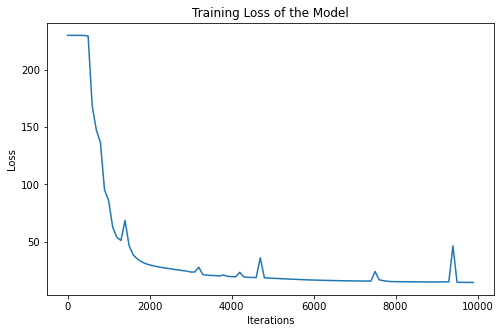

In [48]:
indexs = np.arange(0, 100) * 100
value = [x * 100 for x in model.loss_list]
plt.figure(figsize = (8,5))
plt.title("Training Loss of the Model")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.plot(indexs,value)
plt.show()

In [29]:
# model  = Classifier(1024, [32,16, 10])
# model.forward_pass(X_train)
# loss = model.compute_loss_with_l2(model.output3_act, y_train)
# model.backward_pass(y_train)


In [42]:
model  = Classifier(1024, [32,32, 10])
model.forward_pass(X_train)
loss = model.compute_loss_with_l2(model.output3_act, y_train)
model.backward_pass_with_l2(y_train, iteration = 6000)

Loss after a iteration 0:2.302677164824908 || Accuracy: 9.88970588235294
Loss after a iteration 100:2.3025389759383508 || Accuracy: 9.88970588235294
Loss after a iteration 200:2.302351830029192 || Accuracy: 9.88970588235294
Loss after a iteration 300:2.3017235407476075 || Accuracy: 9.88970588235294
Loss after a iteration 400:2.2929413144350352 || Accuracy: 21.404411764705884
Loss after a iteration 500:1.6143845966005945 || Accuracy: 29.772058823529413
Loss after a iteration 600:1.423897904104247 || Accuracy: 41.61764705882353
Loss after a iteration 700:0.8854916359191214 || Accuracy: 66.31617647058825
Loss after a iteration 800:0.6372958570952105 || Accuracy: 76.52941176470588
Loss after a iteration 900:0.5454960065193428 || Accuracy: 79.02941176470588
Loss after a iteration 1000:0.5032702979940298 || Accuracy: 80.83088235294117
Loss after a iteration 1100:0.47472469876328915 || Accuracy: 83.41911764705883
Loss after a iteration 1200:0.43057262951013375 || Accuracy: 86.66176470588235
L

In [43]:
# saving the model
model.save_model(f'model.pkl')

In [7]:
y_test_pred = model.predict(X_test)
y_acc = np.mean((y_test == y_test_pred))
print(f'Test Accuracy of the model: {y_acc * 100}')

Test Accuracy of the model: 88.17647058823529


In [8]:
y_test_pred

array([3, 3, 6, ..., 6, 4, 3])

In [10]:
weights = {'1': model.weights1, '2': model.weights2, '3': model.weights3, 
           'b1':model.biases1,'b2':model.biases1,'b3':model.biases1}

In [11]:
import pickle
filename = 'base_model_weights_88.pkl'
pickle.dump(weights, open(filename, 'wb'))

In [11]:
import pickle
filename = 'base_model_100.pkl'
pickle.dump(model, open(filename, 'wb'))

In [12]:
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.predict(X_test)
print(result)

[6 2 6 ... 6 4 3]


In [56]:
import PIL
from PIL import Image
# foo = Image.open('dataset/Test/digit_0/103277.png')  # My image is a 200x374 jpeg that is 102kb large
foo = Image.open('number-5.png')
foo= foo.convert('L')
foo = foo.resize((32,32))
# print(foo.size)  # (200, 374)
image = np.array(foo)

image = image.reshape(-1)
image.shape

(1024,)

In [57]:
data = Image.fromarray(image)
      
    # saving the final output 
    # as a PNG file
data.save('gfg_dummy_pic.png')

In [58]:
model.predict(image)

array([5])

In [ ]:
# from fastapi import FastAPI, File
# from fastapi.middleware.cors import CORSMiddleware
# from PIL import Image
# import io
# import pickle
# import numpy as np
# import pandas as pd
# import uvicorn
# # import Classifier

# app = FastAPI()
# origins = [
#     'http://localhost:8000',
# ]
# model = Classifier(1024, [32,32,10])
# filename = 'base_model.pkl'
# loaded_model = pickle.load(open(filename, 'rb'))
# # print(loaded_model.weights1)
# result = loaded_model.predict(X_test)

# @app.get("/")
# async def root():
#     return {"message": "Wrong Method"}

# @app.post("/image")
# async def upload(file: bytes = File(...)):
#     print(result)
#     image = Image.open(io.BytesIO(file))
# #     image.show()
#     image = np.array(image)
# #     image = image.resize((32, 32))
# #     image = image.reshape(-1,)
#     print(image.shape)
#     # result = model.predict(image)
#     print("The result is :", result)
#     return {"Upload Status": "Complete"}



# if __name__ == '__main__':
#     config = uvicorn.Config(app)
#     server = uvicorn.Server(config)
#     await server.serve()